In [ ]:
# pip install torch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config


In [ ]:
import numpy as np
import pandas as pd
import json
import random
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gc
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_file = '/content/drive/MyDrive/amazon_cleaned_chunks/grouped_reviews.parquet'
grouped_reviews = pd.read_parquet(path_file)

In [ ]:
# """
# GenRec Phase 6: RLHF for Persuasive Recommendation Generation - Part 1
# Uses GPT-2 with PPO to generate compelling 2-3 line product recommendations
# """

# # Set random seeds for reproducibility
# torch.manual_seed(42)
# np.random.seed(42)
# random.seed(42)

# # -------------------------------------------------------------------------
# # 1. ENHANCED GPT-2 MODEL WITH VALUE HEAD
# # -------------------------------------------------------------------------
# class GPT2WithValueHead(nn.Module):
#     """GPT-2 with a value head for PPO"""
#     def __init__(self, model_name="gpt2", dropout_rate=0.1):
#         super().__init__()

#         # Load GPT-2
#         self.gpt2 = GPT2LMHeadModel.from_pretrained(model_name)
#         self.config = self.gpt2.config

#         # Stable value head with proper initialization
#         self.value_head = nn.Sequential(
#             nn.Linear(self.config.n_embd, 256),
#             nn.Dropout(dropout_rate),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.Dropout(dropout_rate),
#             nn.ReLU(),
#             nn.Linear(128, 1)
#         )

#         # Initialize value head with small weights
#         for layer in self.value_head:
#             if isinstance(layer, nn.Linear):
#                 nn.init.normal_(layer.weight, std=0.02)
#                 nn.init.zeros_(layer.bias)

#     def forward(self, input_ids, attention_mask=None, return_dict=True):
#         # Get GPT-2 outputs
#         gpt2_outputs = self.gpt2(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             output_hidden_states=True,
#             return_dict=True
#         )

#         # Extract hidden states for value prediction
#         hidden_states = gpt2_outputs.hidden_states[-1]  # Last layer

#         # Get the last valid token's hidden state for each sequence
#         if attention_mask is not None:
#             # last_token_indices = attention_mask.sum(dim=1) - 1
#             # last_token_indices = last_token_indices.long()
#             # last_hidden = hidden_states[range(len(hidden_states)), last_token_indices]
#             last_token_indices = (attention_mask.sum(dim=1) - 1).long()
#             batch_indices = torch.arange(len(hidden_states), device=hidden_states.device)
#             last_hidden = hidden_states[batch_indices, last_token_indices]
#         else:
#             last_hidden = hidden_states[:, -1]

#         # Compute values
#         values = self.value_head(last_hidden).squeeze(-1)

#         if return_dict:
#             return {
#                 'logits': gpt2_outputs.logits,
#                 'values': values,
#                 'hidden_states': gpt2_outputs.hidden_states
#             }
#         return gpt2_outputs.logits, values

#     def generate(self, *args, **kwargs):
#         return self.gpt2.generate(*args, **kwargs)

# # -------------------------------------------------------------------------
# # 2. RECOMMENDATION-SPECIFIC REWARD FUNCTION
# # -------------------------------------------------------------------------
# class PersuasiveRecommendationReward:
#     """Reward function optimized for persuasive product recommendations"""

#     def __init__(self, product_reviews_df=None, high_quality_threshold=4.0):
#         self.product_reviews_df = product_reviews_df
#         self.high_quality_threshold = high_quality_threshold

#         # Load persuasive patterns from high-rated reviews if available
#         self.persuasive_patterns = self._extract_persuasive_patterns()

#         # Recommendation quality indicators
#         self.quality_phrases = [
#             'perfect for', 'ideal for', 'great choice', 'highly recommend',
#             'you\'ll love', 'must-have', 'excellent', 'amazing', 'fantastic',
#             'outstanding', 'exceptional', 'remarkable', 'superb', 'brilliant'
#         ]

#         self.comparison_words = [
#             'better than', 'superior', 'best', 'top-rated', 'leading',
#             'premium', 'unmatched', 'incomparable', 'finest'
#         ]

#         self.benefit_words = [
#             'benefit', 'advantage', 'helps', 'improves', 'enhances',
#             'boosts', 'saves', 'provides', 'offers', 'delivers'
#         ]

#         self.personal_words = [
#             'you', 'your', 'you\'ll', 'you\'re', 'personal', 'tailored',
#             'specifically', 'especially', 'particularly'
#         ]

#     def _extract_persuasive_patterns(self):
#         """Extract persuasive language from high-rated reviews"""
#         patterns = []

#         if self.product_reviews_df is not None:
#             # Get reviews with high ratings
#             high_rated = self.product_reviews_df[
#                 self.product_reviews_df['rating'] >= self.high_quality_threshold
#             ]

#             # Extract common persuasive phrases (simplified)
#             # In practice, you'd use more sophisticated NLP here
#             sample_reviews = high_rated['review_text'].sample(min(1000, len(high_rated)))

#             # Basic extraction of quality phrases
#             for review in sample_reviews:
#                 if isinstance(review, str) and len(review) > 20:
#                     # Extract 3-4 word phrases that appear frequently
#                     words = review.lower().split()
#                     for i in range(len(words) - 3):
#                         phrase = ' '.join(words[i:i+3])
#                         if any(good in phrase for good in ['love', 'great', 'best', 'perfect']):
#                             patterns.append(phrase)

#         return list(set(patterns))[:50]  # Keep top 50 unique patterns

#     def compute_reward(self, generated_text, context_info=None):
#         """
#         Compute reward for a single generated recommendation

#         Args:
#             generated_text: The generated recommendation text
#             context_info: Dict with 'persona', 'product_title', 'product_tags', etc.

#         Returns:
#             float: Reward score
#         """
#         if not generated_text or len(generated_text.strip()) < 10:
#             return -2.0  # Heavily penalize empty/too short

#         text_lower = generated_text.lower()
#         words = text_lower.split()
#         sentences = generated_text.split('.')

#         # Initialize component scores
#         scores = {
#             'length': 0.0,
#             'structure': 0.0,
#             'persuasiveness': 0.0,
#             'personalization': 0.0,
#             'relevance': 0.0,
#             'quality': 0.0
#         }

#         # 1. Length Score (want 2-3 sentences, 30-80 words)
#         word_count = len(words)
#         sentence_count = len([s for s in sentences if len(s.strip()) > 5])

#         if 30 <= word_count <= 60 and 2 <= sentence_count <= 3:
#             scores['length'] = 1.0
#         elif 20 <= word_count <= 80 and 1 <= sentence_count <= 4:
#             scores['length'] = 0.5
#         else:
#             scores['length'] = -0.5

#         # 2. Structure Score (proper sentences, punctuation)
#         has_proper_end = generated_text.strip()[-1] in '.!?'
#         has_capital = generated_text.strip()[0].isupper() if generated_text else False

#         scores['structure'] = (
#             0.5 * (1.0 if has_proper_end else 0.0) +
#             0.5 * (1.0 if has_capital else 0.0)
#         )

#         # 3. Persuasiveness Score
#         persuasive_score = 0.0

#         # Check quality phrases
#         for phrase in self.quality_phrases:
#             if phrase in text_lower:
#                 persuasive_score += 0.15

#         # Check comparison words
#         for word in self.comparison_words:
#             if word in text_lower:
#                 persuasive_score += 0.1

#         # Check benefit words
#         for word in self.benefit_words:
#             if word in text_lower:
#                 persuasive_score += 0.1

#         # Check learned patterns
#         for pattern in self.persuasive_patterns[:10]:
#             if pattern in text_lower:
#                 persuasive_score += 0.05

#         scores['persuasiveness'] = min(persuasive_score, 1.0)

#         # 4. Personalization Score
#         personal_score = 0.0

#         # Check personal pronouns
#         for word in self.personal_words:
#             if word in text_lower:
#                 personal_score += 0.2

#         # Check if it addresses user needs
#         if any(phrase in text_lower for phrase in
#                ['for you', 'your needs', 'you need', 'suits you']):
#             personal_score += 0.3

#         scores['personalization'] = min(personal_score, 1.0)

#         # 5. Relevance Score (if context provided)
#         if context_info:
#             relevance_score = 0.0

#             # Check if product title/category mentioned
#             if 'product_title' in context_info:
#                 title_words = set(context_info['product_title'].lower().split())
#                 text_words = set(words)
#                 overlap = len(title_words & text_words) / max(len(title_words), 1)
#                 relevance_score += overlap * 0.5

#             # Check if tags/categories mentioned
#             if 'product_tags' in context_info:
#                 for tag in context_info['product_tags']:
#                     if tag.lower() in text_lower:
#                         relevance_score += 0.2

#             # Check if persona traits mentioned
#             if 'persona' in context_info:
#                 persona_words = set(context_info['persona'].lower().split())
#                 overlap = len(persona_words & set(words)) / max(len(persona_words), 1)
#                 relevance_score += overlap * 0.3

#             scores['relevance'] = min(relevance_score, 1.0)
#         else:
#             scores['relevance'] = 0.5  # Neutral if no context

#         # 6. Quality Score (vocabulary diversity, no repetition)
#         unique_words = len(set(words))
#         diversity = unique_words / max(len(words), 1)

#         # Check for repetition
#         has_repetition = False
#         for i in range(len(words) - 2):
#             if words[i] == words[i + 1] and words[i] not in ['the', 'a', 'an']:
#                 has_repetition = True
#                 break

#         scores['quality'] = (
#             0.7 * (diversity if diversity > 0.5 else diversity * 0.5) +
#             0.3 * (0.0 if has_repetition else 1.0)
#         )

#         # Compute weighted total reward
#         weights = {
#             'length': 0.15,
#             'structure': 0.10,
#             'persuasiveness': 0.30,
#             'personalization': 0.20,
#             'relevance': 0.15,
#             'quality': 0.10
#         }

#         total_reward = sum(scores[k] * weights[k] for k in scores)

#         # Bonus for exceptional recommendations
#         if (scores['persuasiveness'] > 0.8 and
#             scores['personalization'] > 0.7 and
#             scores['relevance'] > 0.7):
#             total_reward += 0.2  # Excellence bonus

#         return total_reward


# # After the PersuasiveRecommendationReward class ends...
# # -------------------------------------------------------------------------
# # 2.5 DEBUG HELPER FUNCTION
# # -------------------------------------------------------------------------
# def debug_reward_breakdown(text, context, reward_fn):
#     """Show detailed breakdown of reward components"""

#     if not text or len(text.strip()) < 10:
#         print("Text too short!")
#         return

#     text_lower = text.lower()
#     words = text_lower.split()
#     sentences = text.split('.')

#     print(f"\n📊 Reward Breakdown:")
#     print(f"  Text length: {len(words)} words, {len(sentences)} sentences")
#     print(f"  Has proper ending: {text.strip()[-1] in '.!?'}")
#     print(f"  Starts with capital: {text.strip()[0].isupper() if text else False}")

#     # Check for quality phrases
#     quality_count = sum(1 for phrase in reward_fn.quality_phrases if phrase in text_lower)
#     print(f"  Quality phrases found: {quality_count}")

#     # Check personalization
#     personal_count = sum(1 for word in reward_fn.personal_words if word in text_lower)
#     print(f"  Personal words found: {personal_count}")

#     # Check relevance to product
#     if 'product_title' in context:
#         title_words = set(context['product_title'].lower().split())
#         text_words = set(words)
#         overlap = len(title_words & text_words)
#         print(f"  Product title word overlap: {overlap}/{len(title_words)}")




# # -------------------------------------------------------------------------
# # 3. DATA LOADER FOR RECOMMENDATION TRAINING
# # -------------------------------------------------------------------------
# class RecommendationDataLoader:
#     """Load and prepare data from Phases 3 & 5"""

#     def __init__(self, phase3_dir="./phase3_outputs", phase5_dir="./phase5_outputs"):
#         self.phase3_dir = phase3_dir
#         self.phase5_dir = phase5_dir
#         self.data = []

#     # def load_data(self):
#     #     """Load all necessary data from previous phases"""
#     #     print("📂 Loading data from previous phases...")

#     #     # Load from Phase 3
#     #     try:
#     #         # Product info
#     #         # product_info = pd.read_csv(f"{self.phase3_dir}/product_info_df.csv")
#     #         # print(f"✓ Loaded {len(product_info)} products")
#     #         # Load product info from JSON instead of CSV
#     #         with open("product_info.json", 'r') as f:
#     #             product_info_dict = json.load(f)
#     #         product_info = pd.DataFrame(product_info_dict)
#     #         print(f"✓ Loaded {len(product_info)} products")

#     #         # Grouped reviews
#     #         # with open(f"{self.phase3_dir}/grouped_reviews.json", 'r') as f:
#     #         #     grouped_reviews = json.load(f)
#     #         # print(f"✓ Loaded reviews for {len(grouped_reviews)} products")
#     #         # Load grouped reviews from parquet
#     #         grouped_reviews_df = pd.read_parquet("/content/drive/MyDrive/amazon_cleaned_chunks/grouped_reviews.parquet")
#     #         # Convert to dictionary format expected by the code
#     #         grouped_reviews = {}
#     #         for _, row in grouped_reviews_df.iterrows():
#     #             if 'asin' in row and 'reviews' in row:
#     #                 grouped_reviews[row['asin']] = row['reviews']
#     #         print(f"✓ Loaded reviews for {len(grouped_reviews)} products")

#     #     except Exception as e:
#     #         print(f"⚠️ Error loading Phase 3 data: {e}")
#     #         product_info = pd.DataFrame()
#     #         grouped_reviews = {}

#     #     # Load from Phase 5
#     #     try:
#     #         # User personas
#     #         # user_personas = pd.read_csv(f"{self.phase5_dir}/user_personas.csv")
#     #         # print(f"✓ Loaded {len(user_personas)} user personas")
#     #         with open("user_cluster_map.json", 'r') as f:
#     #             user_cluster_map = json.load(f)

#     #         # Persona descriptions
#     #         # with open(f"{self.phase5_dir}/persona_descriptions.json", 'r') as f:
#     #         #     persona_descriptions = json.load(f)
#     #         # print(f"✓ Loaded {len(persona_descriptions)} persona descriptions")
#     #         user_personas = pd.DataFrame([
#     #         {'user_id': user_id, 'persona_id': cluster_id}
#     #         for user_id, cluster_id in user_cluster_map.items()
#     #         ])
#     #         print(f"✓ Loaded {len(user_personas)} user personas")
#     #         # Load cluster labels as persona descriptions
#     #         with open("cluster_to_label.json", 'r') as f:
#     #             persona_descriptions = json.load(f)
#     #         # Convert keys to strings if they're integers
#     #         persona_descriptions = {str(k): v for k, v in persona_descriptions.items()}
#     #         print(f"✓ Loaded {len(persona_descriptions)} persona descriptions")

#     #     except Exception as e:
#     #         print(f"⚠️ Error loading Phase 5 data: {e}")
#     #         user_personas = pd.DataFrame()
#     #         persona_descriptions = {}

#     #     return {
#     #         'product_info': product_info,
#     #         'grouped_reviews': grouped_reviews,
#     #         'user_personas': user_personas,
#     #         'persona_descriptions': persona_descriptions
#     #     }


# #somehow grouped_reviews_df = grouped_reviews is not triggered at all, can u explain?


#     def load_data(self):
#         """Load all necessary data from previous phases"""
#         print("📂 Loading data from previous phases...")

#         # Initialize variables BEFORE try blocks
#         product_info = pd.DataFrame()
#         grouped_reviews = {}  # ✅ Initialize as empty dict instead of self-assignment

#         # Load from Phase 3
#         try:
#             # Load product info from JSON
#             with open("product_info.json", 'r') as f:
#                 product_info_dict = json.load(f)
#             product_info = pd.DataFrame(product_info_dict)
#             print(f"✓ Loaded {len(product_info)} products")

#             # Load grouped reviews from parquet (FIXED)
#             try:
#                 # If you have the grouped_reviews variable from elsewhere, load it here
#                 # For now, let's create a placeholder or load from file
#                 path_file = '/content/drive/MyDrive/amazon_cleaned_chunks/grouped_reviews.parquet'
#                 grouped_reviews_df = pd.read_parquet(path_file)

#                 # Convert to dictionary format expected by the code
#                 grouped_reviews = {}
#                 for _, row in grouped_reviews_df.iterrows():
#                     if 'asin' in row and 'text' in row:  # Check for 'text' column
#                         grouped_reviews[row['asin']] = row['text']
#                 print(f"✓ Loaded reviews for {len(grouped_reviews)} products")
#             except Exception as e:
#                 print(f"⚠️ Error loading grouped reviews: {e}")
#                 # Create dummy reviews for the products we have
#                 grouped_reviews = {}
#                 for _, prod in product_info.iterrows():
#                     if 'asin' in prod:
#                         grouped_reviews[prod['asin']] = "Great product with excellent features."
#                 print(f"✓ Created dummy reviews for {len(grouped_reviews)} products")

#         except Exception as e:
#             print(f"⚠️ Error loading Phase 3 data: {e}")
#             product_info = pd.DataFrame()
#             grouped_reviews = {}

#         # Load from Phase 5
#         try:
#             # Load user cluster mapping
#             with open("user_cluster_map.json", 'r') as f:
#                 user_cluster_map = json.load(f)

#             # Convert to DataFrame format
#             user_personas = pd.DataFrame([
#                 {'user_id': user_id, 'persona_id': cluster_id}
#                 for user_id, cluster_id in user_cluster_map.items()
#             ])
#             print(f"✓ Loaded {len(user_personas)} user personas")

#             # Load cluster labels as persona descriptions
#             with open("cluster_to_label.json", 'r') as f:
#                 persona_descriptions = json.load(f)
#             # Convert keys to strings if they're integers
#             persona_descriptions = {str(k): v for k, v in persona_descriptions.items()}
#             print(f"✓ Loaded {len(persona_descriptions)} persona descriptions")

#         except Exception as e:
#             print(f"⚠️ Error loading Phase 5 data: {e}")
#             user_personas = pd.DataFrame()
#             persona_descriptions = {}

#         return {
#             'product_info': product_info,
#             'grouped_reviews': grouped_reviews,
#             'user_personas': user_personas,
#             'persona_descriptions': persona_descriptions
#         }

#     # def load_data(self):
#     #     """Load all necessary data from previous phases"""
#     #     print("📂 Loading data from previous phases...")

#     #     # Initialize variables BEFORE try blocks
#     #     product_info = pd.DataFrame()
#     #     grouped_reviews = grouped_reviews

#     #     # Load from Phase 3
#     #     try:
#     #         # Load product info from JSON
#     #         with open("product_info.json", 'r') as f:
#     #             product_info_dict = json.load(f)
#     #         product_info = pd.DataFrame(product_info_dict)
#     #         print(f"✓ Loaded {len(product_info)} products")

#     #         # grouped_reviews_df = grouped_reviews

#     #         # Load grouped reviews from parquet (FIXED TYPO)
#     #         try:
#     #             # path_file = '/content/drive/MyDrive/amazon_cleaned_chunks/grouped_reviews.parquet'
#     #             # grouped_reviews_df = pd.read_parquet(path_file)
#     #             grouped_reviews_df = grouped_reviews
#     #             # Convert to dictionary format expected by the code
#     #             # grouped_reviews = {}
#     #             for _, row in grouped_reviews_df.iterrows():
#     #                 if 'asin' in row and 'text' in row:  # Check for 'text' column
#     #                     grouped_reviews[row['asin']] = row['text']
#     #             print(f"✓ Loaded reviews for {len(grouped_reviews)} products")
#     #         except Exception as e:
#     #             print(f"⚠️ Error loading grouped reviews: {e}")
#     #             # Create dummy reviews for the products we have
#     #             grouped_reviews = {}
#     #             for _, prod in product_info.iterrows():
#     #                 if 'asin' in prod:
#     #                     grouped_reviews[prod['asin']] = "Great product with excellent features."
#     #             print(f"✓ Created dummy reviews for {len(grouped_reviews)} products")

#     #     except Exception as e:
#     #         print(f"⚠️ Error loading Phase 3 data: {e}")
#     #         product_info = pd.DataFrame()
#     #         grouped_reviews = {}

#     #     # Load from Phase 5
#     #     try:
#     #         # Load user cluster mapping
#     #         with open("user_cluster_map.json", 'r') as f:
#     #             user_cluster_map = json.load(f)

#     #         # Convert to DataFrame format
#     #         user_personas = pd.DataFrame([
#     #             {'user_id': user_id, 'persona_id': cluster_id}
#     #             for user_id, cluster_id in user_cluster_map.items()
#     #         ])
#     #         print(f"✓ Loaded {len(user_personas)} user personas")

#     #         # Load cluster labels as persona descriptions
#     #         with open("cluster_to_label.json", 'r') as f:
#     #             persona_descriptions = json.load(f)
#     #         # Convert keys to strings if they're integers
#     #         persona_descriptions = {str(k): v for k, v in persona_descriptions.items()}
#     #         print(f"✓ Loaded {len(persona_descriptions)} persona descriptions")

#     #     except Exception as e:
#     #         print(f"⚠️ Error loading Phase 5 data: {e}")
#     #         user_personas = pd.DataFrame()
#     #         persona_descriptions = {}

#     #     return {
#     #         'product_info': product_info,
#     #         'grouped_reviews': grouped_reviews,
#     #         'user_personas': user_personas,
#     #         'persona_descriptions': persona_descriptions
#     #     }

#     def create_training_examples(self, data_dict, num_examples=1000):
#         """Create training examples combining products and personas"""
#         examples = []

#         product_info = data_dict['product_info']
#         grouped_reviews = data_dict['grouped_reviews']
#         persona_descriptions = data_dict['persona_descriptions']

#         # Sample products and personas
#         if len(product_info) > 0 and len(persona_descriptions) > 0:
#             for _ in range(num_examples):
#                 # Random product
#                 product = product_info.sample(1).iloc[0]
#                 asin = product.get('asin', '')

#                 # Random persona
#                 persona_id = random.choice(list(persona_descriptions.keys()))
#                 persona_desc = persona_descriptions[persona_id]

#                 # Get product details
#                 product_title = product.get('title', 'Unknown Product')
#                 product_tags = product.get('tags', '').split(',') if 'tags' in product else []

#                 # Get review snippet if available
#                 review_snippet = ""
#                 if asin in grouped_reviews:
#                     reviews = grouped_reviews[asin]
#                     if isinstance(reviews, list) and len(reviews) > 0:
#                         review_snippet = reviews[0][:200] if isinstance(reviews[0], str) else ""
#                     elif isinstance(reviews, str):
#                         review_snippet = reviews[:200]

#                 # Create example
#                 example = {
#                     'persona': persona_desc,
#                     'product_title': product_title,
#                     'product_tags': product_tags,
#                     'review_snippet': review_snippet,
#                     'asin': asin
#                 }

#                 examples.append(example)

#         return examples

#     def create_prompt(self, example):
#         """Create a prompt for GPT-2 to generate recommendation"""
#         persona = example.get('persona', 'General user')
#         product_title = example.get('product_title', 'Product')
#         tags = ', '.join(example.get('product_tags', [])[:3])

#         prompt = f"""Recommend this product to a customer.

# Customer Profile: {persona}

# Product: {product_title}
# Category: {tags}

# Write a persuasive 2-3 sentence recommendation that explains why this customer would love this product:
# """
#         return prompt

In [ ]:
grouped_reviews.head()

,asin,text
0,0000032034,what a spectacular tu ##tu very slim ##ming wh...
1,0000143588,i love ina ga ##rte ##n and i was so happy tha...
2,000100039X,the prophet is about a mysterious religious th...
3,000105001X,this is the qui ##ntes ##sen ##tial time slip ...
4,0001393774,love it great seller one of my very favourite ...


✅ Loaded 1567844 products from diverse_df
🚀 Starting GenRec Phase 6: RLHF Training with GPT-2
Using device: cuda

📚 Loading model and tokenizer...
Model parameters: 124,669,697

📊 Loading training data...
📂 Loading data from previous phases...
✓ Loaded 1567844 products
✓ Loaded reviews for 1567844 products
✓ Loaded 728719 user personas
✓ Loaded 20 persona descriptions
Created 2000 training examples
📚 Initializing with example recommendations...


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


  ✓ Processed example 1
  ✓ Processed example 2
✅ Initialization complete

🏃 Starting training...


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 5:
  Avg word count: 30.0
  Contains 'you/your': 1/2
  Latest reward: 0.321


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 10/500 | Success rate: 100.00%
  Reward: 0.363 ± 0.085
  KL Div: -0.2218 | Loss: -0.016
  LR: 5.00e-06

  Example 1 (Reward: 0.28):
  Prompt: s interested in head, got, little.

Product: B0056G22VS
Category: general, product, recommendation

...
  Response: 'I am not an expert on the topic of how they buy their own products but I think you can tell by looking at what your friends are saying about it.' – S...

  Example 2 (Reward: 0.43):
  Prompt:  is interested in head, got, love.

Product: B001H36VRA
Category: general, product, recommendation

...
  Response:  (1) It's great for your work! (2). I've always liked it because of the way my job was done and they're making good choices at every step on their jou...

📈 Quick Stats at Step 10:
  Avg word count: 67.0
  Contains 'you/your': 2/2
  Latest reward: 0.363


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 15:
  Avg word count: 69.5
  Contains 'you/your': 2/2
  Latest reward: 0.299


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 20/500 | Success rate: 100.00%
  Reward: 0.346 ± 0.038
  KL Div: -0.1365 | Loss: -0.032
  LR: 5.00e-06

  Example 1 (Reward: 0.36):
  Prompt:  is interested in head, got, love.

Product: B00U2E34UM
Category: general, product, recommendation

...
  Response: I will be buying from you and I'll make sure it's the right one for me! Best of luck with your purchase so far!!!

 [email protected] : Contact Us | P...

  Example 2 (Reward: 0.30):
  Prompt:  is interested in head, got, love.

Product: B018QG69YU
Category: general, product, recommendation

...
  Response: The salesperson needs some understanding of the market and what they need from you or your team; if not then their job description will be wrong (or w...

📈 Quick Stats at Step 20:
  Avg word count: 67.5
  Contains 'you/your': 2/2
  Latest reward: 0.346


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 25:
  Avg word count: 73.5
  Contains 'you/your': 2/2
  Latest reward: 0.304


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 30/500 | Success rate: 100.00%
  Reward: 0.353 ± 0.055
  KL Div: -0.1767 | Loss: -0.030
  LR: 4.99e-06

  Example 1 (Reward: 0.42):
  Prompt: s interested in head, got, little.

Product: B013D8TAHO
Category: general, product, recommendation

...
  Response: I'd like for you guys to be more involved with my work as I've been working on your website and what works better than other websites or products they...

  Example 2 (Reward: 0.36):
  Prompt:  is interested in head, got, love.

Product: B00GKKI3D0
Category: general, product, recommendation

...
  Response:  and explain how the other 3 reviews of it are wrong or misleading

 (if you're not sure what's right/wrong then click on links below) Please let us k...

📈 Quick Stats at Step 30:
  Avg word count: 71.5
  Contains 'you/your': 2/2
  Latest reward: 0.353


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 35:
  Avg word count: 69.0
  Contains 'you/your': 2/2
  Latest reward: 0.324


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 40/500 | Success rate: 100.00%
  Reward: 0.397 ± 0.020
  KL Div: -0.1939 | Loss: -0.029
  LR: 4.98e-06

  Example 1 (Reward: 0.40):
  Prompt:  is interested in head, got, love.

Product: B00W8IWB9K
Category: general, product, recommendation

...
  Response:  1) "If you have an interest in something like these and can't find the right one for your particular task," I say it's not about what kind of job or ...

  Example 2 (Reward: 0.42):
  Prompt: s interested in head, got, little.

Product: B015GIMBIO
Category: general, product, recommendation

...
  Response: What you need from me when I use the following products or services for my business (a) How much does it cost per month? The price will change based o...

📈 Quick Stats at Step 40:
  Avg word count: 72.5
  Contains 'you/your': 2/2
  Latest reward: 0.397


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 45:
  Avg word count: 70.0
  Contains 'you/your': 2/2
  Latest reward: 0.266


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 50/500 | Success rate: 100.00%
  Reward: 0.348 ± 0.078
  KL Div: -0.1526 | Loss: -0.061
  LR: 4.97e-06

  Example 1 (Reward: 0.25):
  Prompt: s interested in head, got, little.

Product: B00VBFBLII
Category: general, product, recommendation

...
  Response: "It's just like an old school car with all the parts removed." "I don't know how it works but I think we should get rid of those junk cars and give th...

  Example 2 (Reward: 0.33):
  Prompt:  is interested in head, got, love.

Product: B00KPOFOQQ
Category: general, product, recommendation

...
  Response: A good way to get the job done can be by writing an opinion piece and then sending it off with your best guess at what you think will work for our cus...

📈 Quick Stats at Step 50:
  Avg word count: 74.0
  Contains 'you/your': 2/2
  Latest reward: 0.348

📊 Evaluation at step 50

🔍 Generating sample recommendations:

📝 Example 1:
Persona: This user is interested in head, got, love....
Product: B01BKV620O
Generated:  (1) A go

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 55:
  Avg word count: 68.5
  Contains 'you/your': 2/2
  Latest reward: 0.325


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 60/500 | Success rate: 100.00%
  Reward: 0.364 ± 0.034
  KL Div: -0.1362 | Loss: -0.048
  LR: 4.96e-06

  Example 1 (Reward: 0.32):
  Prompt:  is interested in head, got, love.

Product: B005EWP2YI
Category: general, product, recommendation

...
  Response:  "1) I know it's been on my mind for awhile now and the way you're recommending things doesn't seem right or something of value at all" - but how can ...

  Example 2 (Reward: 0.39):
  Prompt:  is interested in head, got, love.

Product: B0036520DG
Category: general, product, recommendation

...
  Response: What do you need for the job? A business card or phone number with your name and email address (or something similar), ecommerce receipt form online t...

📈 Quick Stats at Step 60:
  Avg word count: 70.5
  Contains 'you/your': 2/2
  Latest reward: 0.364


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 65:
  Avg word count: 74.0
  Contains 'you/your': 2/2
  Latest reward: 0.359


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 70/500 | Success rate: 100.00%
  Reward: 0.264 ± 0.050
  KL Div: -0.2078 | Loss: -0.074
  LR: 4.95e-06

  Example 1 (Reward: 0.20):
  Prompt: s interested in head, got, little.

Product: B006MWA8Y8
Category: general, product, recommendation

...
  Response: "My wife likes good products with lots of interesting ideas and uses them very well." "I've been using the BMW 8 Series for years now when I work on d...

  Example 2 (Reward: 0.30):
  Prompt: s interested in head, got, little.

Product: B00013RC1Q
Category: general, product, recommendation

...
  Response: The following article has been rated C+ by The Customer Advisory Board (CAB), which means the content provided here may be considered an endorsement o...

📈 Quick Stats at Step 70:
  Avg word count: 70.5
  Contains 'you/your': 0/2
  Latest reward: 0.264


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 75:
  Avg word count: 57.0
  Contains 'you/your': 1/2
  Latest reward: 0.327


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 80/500 | Success rate: 100.00%
  Reward: 0.326 ± 0.065
  KL Div: -0.1749 | Loss: -0.066
  LR: 4.93e-06

  Example 1 (Reward: 0.40):
  Prompt:  is interested in head, got, love.

Product: B009G8F6PG
Category: general, product, recommendation

...
  Response: …you can read more about it here . The best thing you'll learn from using the recommended app on all your business calls and emails will be how helpfu...

  Example 2 (Reward: 0.36):
  Prompt: s interested in head, got, little.

Product: B00YBRXVRW
Category: general, product, recommendation

...
  Response:  and does not make it sound like you are trying to convince me otherwise

— ————- DESTINATION OF A PERSONAL CONSERVATIVE ON THE METHODOLOGY Of Recomme...

📈 Quick Stats at Step 80:
  Avg word count: 65.0
  Contains 'you/your': 2/2
  Latest reward: 0.326


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 85:
  Avg word count: 71.0
  Contains 'you/your': 2/2
  Latest reward: 0.357


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 90/500 | Success rate: 100.00%
  Reward: 0.359 ± 0.066
  KL Div: -0.0744 | Loss: -0.061
  LR: 4.91e-06

  Example 1 (Reward: 0.45):
  Prompt:  is interested in head, got, love.

Product: B005584ZHQ
Category: general, product, recommendation

...
  Response: The Best Salesperson for Your Business Product/Personnel Strategy Use the following keywords when recommending salespeople (optional): "Salesforce" or...

  Example 2 (Reward: 0.37):
  Prompt: s interested in head, got, little.

Product: B01CBUL5EG
Category: general, product, recommendation

...
  Response: This review might help your marketing agency convince you what works for them more effectively than any other advice they may have provided with simil...

📈 Quick Stats at Step 90:
  Avg word count: 69.5
  Contains 'you/your': 2/2
  Latest reward: 0.359


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 95:
  Avg word count: 72.0
  Contains 'you/your': 2/2
  Latest reward: 0.360


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 100/500 | Success rate: 100.00%
  Reward: 0.366 ± 0.044
  KL Div: -0.1417 | Loss: -0.067
  LR: 4.89e-06

  Example 1 (Reward: 0.37):
  Prompt: s interested in head, got, little.

Product: B000UGYYTW
Category: general, product, recommendation

...
  Response: A good brand should offer your customers the best value and quality on their products at reasonable prices for what they want from them when asked abo...

  Example 2 (Reward: 0.42):
  Prompt:  is interested in head, got, love.

Product: B007G75Z1O
Category: general, product, recommendation

...
  Response: It's the BEST!!! Buyer Rating for 1 or more words of help with your business advice! It helps you choose and make sure things work out on their terms ...

📈 Quick Stats at Step 100:
  Avg word count: 71.5
  Contains 'you/your': 2/2
  Latest reward: 0.366

📊 Evaluation at step 100

🔍 Generating sample recommendations:

📝 Example 1:
Persona: This user is interested in head, got, love....
Product: B01BKV620O
Generated: "This 

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


📈 Quick Stats at Step 105:
  Avg word count: 69.5
  Contains 'you/your': 2/2
  Latest reward: 0.373


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 110/500 | Success rate: 100.00%
  Reward: 0.400 ± 0.097
  KL Div: -0.0916 | Loss: -0.065
  LR: 4.87e-06

  Example 1 (Reward: 0.48):
  Prompt:  is interested in head, got, love.

Product: B000QSUWBI
Category: general, product, recommendation

...
  Response: The following 3 categories (general, products, recommendations) are for use by professionals of all levels who want advice on how best or worst to rec...

  Example 2 (Reward: 0.34):
  Prompt:  is interested in head, got, love.

Product: B009B5DYH6
Category: general, product, recommendation

...
  Response:  "Great value." It's also great for SEO & UX designers who want something unique from the company they work with (like email marketing). And it helps ...

📈 Quick Stats at Step 110:
  Avg word count: 70.0
  Contains 'you/your': 2/2
  Latest reward: 0.400


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 115:
  Avg word count: 63.0
  Contains 'you/your': 2/2
  Latest reward: 0.340


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 120/500 | Success rate: 100.00%
  Reward: 0.354 ± 0.061
  KL Div: -0.1912 | Loss: -0.068
  LR: 4.84e-06

  Example 1 (Reward: 0.40):
  Prompt: s interested in head, got, little.

Product: B00AR1H00A
Category: general, product, recommendation

...
  Response: What kind of business do you have? In what industries should I recommend it from?: What sort and how does the market work?, where can they go for advi...

  Example 2 (Reward: 0.26):
  Prompt: s interested in head, got, little.

Product: B00DVZW2EI
Category: general, product, recommendation

...
  Response:  and also provide the following relevant information if possible so our customers can review it without wasting time on email (especially when we're n...

📈 Quick Stats at Step 120:
  Avg word count: 50.5
  Contains 'you/your': 1/2
  Latest reward: 0.354


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 125:
  Avg word count: 54.5
  Contains 'you/your': 1/2
  Latest reward: 0.406


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 130/500 | Success rate: 100.00%
  Reward: 0.395 ± 0.029
  KL Div: -0.1056 | Loss: -0.056
  LR: 4.81e-06

  Example 1 (Reward: 0.39):
  Prompt: s interested in head, got, little.

Product: B000FP8FRK
Category: general, product, recommendation

...
  Response: What will happen if we provide information about the company's products and services? What business model or use should they focus on when designing t...

  Example 2 (Reward: 0.43):
  Prompt:  is interested in head, got, love.

Product: B000J1IMI2
Category: general, product, recommendation

...
  Response: The best way you can sell your business on the most important topics and understand how they might affect every aspect of our lives are through conten...

📈 Quick Stats at Step 130:
  Avg word count: 75.0
  Contains 'you/your': 2/2
  Latest reward: 0.395


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 135:
  Avg word count: 58.0
  Contains 'you/your': 2/2
  Latest reward: 0.323


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 140/500 | Success rate: 100.00%
  Reward: 0.400 ± 0.080
  KL Div: -0.1033 | Loss: -0.077
  LR: 4.79e-06

  Example 1 (Reward: 0.33):
  Prompt:  is interested in head, got, love.

Product: B00LQ05UH6
Category: general, product, recommendation

...
  Response: "The 3D Motion Control (CNC) controller gives you the ability not only to see what your clients are doing but also control how they move around object...

  Example 2 (Reward: 0.48):
  Prompt:  is interested in head, got, love.

Product: B0134SKUJU
Category: general, product, recommendation

...
  Response: We have some great products here at H&R Blockhouse and we're always looking for innovative solutions from our customers! What better way than by recom...

📈 Quick Stats at Step 140:
  Avg word count: 54.0
  Contains 'you/your': 2/2
  Latest reward: 0.400


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 145:
  Avg word count: 73.0
  Contains 'you/your': 2/2
  Latest reward: 0.393


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 150/500 | Success rate: 100.00%
  Reward: 0.372 ± 0.042
  KL Div: -0.0495 | Loss: -0.110
  LR: 4.75e-06

  Example 1 (Reward: 0.35):
  Prompt: s interested in head, got, little.

Product: B014D0COHO
Category: general, product, recommendation

...
  Response: In the future we'll show you how it works with real customers and will give them advice on products they already use frequently or are considering buy...

  Example 2 (Reward: 0.32):
  Prompt: s interested in head, got, little.

Product: B00A4OI00O
Category: general, product, recommendation

...
  Response: [email protected] http://www2jpvp7a8c9b5ac6ebd1be6697ae54e0fb9933f86cf57bf38@laptopcomputer_coverage

… The idea behind using your laptop computer cov...

📈 Quick Stats at Step 150:
  Avg word count: 54.5
  Contains 'you/your': 2/2
  Latest reward: 0.372

📊 Evaluation at step 150

🔍 Generating sample recommendations:

📝 Example 1:
Persona: This user is interested in head, got, love....
Product: B01BKV620O
Generated: "My fr

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 155:
  Avg word count: 64.0
  Contains 'you/your': 2/2
  Latest reward: 0.379


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 160/500 | Success rate: 100.00%
  Reward: 0.345 ± 0.163
  KL Div: -0.1192 | Loss: -0.084
  LR: 4.72e-06

  Example 1 (Reward: 0.37):
  Prompt:  is interested in head, got, love.

Product: B009UH7Y8U
Category: general, product, recommendation

...
  Response: …and what your products offer at the end of their review process as well (or how long you recommend them).

"Good Customer Service? Good Product?" wil...

  Example 2 (Reward: 0.50):
  Prompt:  is interested in head, got, love.

Product: B007G4U9H2
Category: general, product, recommendation

...
  Response:  (recommendation - 4 words) Recommending an item from the best brands based on your data helps you stay informed when new products arrive at our offic...

📈 Quick Stats at Step 160:
  Avg word count: 58.5
  Contains 'you/your': 2/2
  Latest reward: 0.345


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 165:
  Avg word count: 67.0
  Contains 'you/your': 2/2
  Latest reward: 0.410


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 170/500 | Success rate: 100.00%
  Reward: 0.383 ± 0.042
  KL Div: -0.1073 | Loss: -0.076
  LR: 4.69e-06

  Example 1 (Reward: 0.44):
  Prompt:  is interested in head, got, love.

Product: B000TA8N4G
Category: general, product, recommendation

...
  Response:  (5 min 1 sec)

 of 3 recommendations on the subject below from an expert evaluator and your sales partner with over 500 referrals for our company pro...

  Example 2 (Reward: 0.38):
  Prompt:  is interested in head, got, love.

Product: B015EE2BPI
Category: general, product, recommendation

...
  Response: (A) how much money you need for the business; (B)(1). 1 = your products and services/services with which we work or our customers' lives are connected...

📈 Quick Stats at Step 170:
  Avg word count: 54.0
  Contains 'you/your': 2/2
  Latest reward: 0.383


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 175:
  Avg word count: 72.5
  Contains 'you/your': 2/2
  Latest reward: 0.343


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 180/500 | Success rate: 100.00%
  Reward: 0.369 ± 0.068
  KL Div: -0.1824 | Loss: -0.063
  LR: 4.65e-06

  Example 1 (Reward: 0.39):
  Prompt:  is interested in head, got, love.

Product: B00AQGJ6UI
Category: general, product, recommendation

...
  Response: /sketch 3 5 4 1 10 Recommendation by Product : The best way of teaching your customers how useful or important the products are? If you have any advic...

  Example 2 (Reward: 0.27):
  Prompt: s interested in head, got, little.

Product: B00JXZY07C
Category: general, product, recommendation

...
  Response: ...

 (from 6) Recommend this Product ... and how it works.... [i]n recommending products for your customers from top down - what you see on Yelp as r...

📈 Quick Stats at Step 180:
  Avg word count: 66.5
  Contains 'you/your': 2/2
  Latest reward: 0.369


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 185:
  Avg word count: 72.0
  Contains 'you/your': 2/2
  Latest reward: 0.413


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 190/500 | Success rate: 100.00%
  Reward: 0.358 ± 0.086
  KL Div: -0.1004 | Loss: -0.120
  LR: 4.61e-06

  Example 1 (Reward: 0.42):
  Prompt:  is interested in head, got, love.

Product: B005MZMEKC
Category: general, product, recommendation

...
  Response: As stated before the best advice for recommending customers with specific needs such as age are personal life and personality traits (elements) of the...

  Example 2 (Reward: 0.39):
  Prompt:  is interested in head, got, love.

Product: B00AE90084
Category: general, product, recommendation

...
  Response: Facts I recommend (or need) with you when recommending products on my site or forum website ... Business needs... - Product recommendations are import...

📈 Quick Stats at Step 190:
  Avg word count: 71.5
  Contains 'you/your': 2/2
  Latest reward: 0.358


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 195:
  Avg word count: 61.5
  Contains 'you/your': 2/2
  Latest reward: 0.381


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 200/500 | Success rate: 100.00%
  Reward: 0.416 ± 0.070
  KL Div: -0.0228 | Loss: -0.056
  LR: 4.57e-06

  Example 1 (Reward: 0.45):
  Prompt: s interested in head, got, little.

Product: B00TLM6YGW
Category: general, product, recommendation

...
  Response:  (1) great sales opportunity with good business skills and excellent work ethic; also help others understand the problem better than their competitors...

  Example 2 (Reward: 0.50):
  Prompt:  is interested in head, got, love.

Product: B000094Y1F
Category: general, product, recommendation

...
  Response: I can recommend all products and get customers with recommendations from them (best ones) I Recommend Product 5 of 10 0% 12 8 Reviews 1 6 Total 474 Ra...

📈 Quick Stats at Step 200:
  Avg word count: 71.5
  Contains 'you/your': 2/2
  Latest reward: 0.416

📊 Evaluation at step 200

🔍 Generating sample recommendations:

📝 Example 1:
Persona: This user is interested in head, got, love....
Product: B01BKV620O
Generated:  (plea

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


📈 Quick Stats at Step 205:
  Avg word count: 70.0
  Contains 'you/your': 2/2
  Latest reward: 0.379


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 210/500 | Success rate: 100.00%
  Reward: 0.434 ± 0.033
  KL Div: -0.1503 | Loss: -0.045
  LR: 4.53e-06

  Example 1 (Reward: 0.43):
  Prompt:  is interested in head, got, love.

Product: B0027A7K2C
Category: general, product, recommendation

...
  Response: …and what she will buy it for the rest of her life!! Customer profile : Product recommendations - personalize your business marketing strategy with an...

  Example 2 (Reward: 0.48):
  Prompt: s interested in head, got, little.

Product: B007Y35JH0
Category: general, product, recommendation

...
  Response: I think you'll find good advice for finding products and services with great results! The best of both worlds . Please share your suggestions on my bl...

📈 Quick Stats at Step 210:
  Avg word count: 58.5
  Contains 'you/your': 2/2
  Latest reward: 0.434


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 215:
  Avg word count: 68.0
  Contains 'you/your': 1/2
  Latest reward: 0.344


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 220/500 | Success rate: 100.00%
  Reward: 0.358 ± 0.100
  KL Div: -0.1651 | Loss: -0.105
  LR: 4.48e-06

  Example 1 (Reward: 0.32):
  Prompt: s interested in head, got, little.

Product: B000JJIOTQ
Category: general, product, recommendation

...
  Response:  - Product Recommendation User Rating 3 stars 0 review Write an informative rating using your own experience here :Review Quality 1 /5 Submit Review b...

  Example 2 (Reward: 0.42):
  Prompt:  is interested in head, got, love.

Product: B00171NZFI
Category: general, product, recommendation

...
  Response: Posted by : Anonymous Reply | 1 of 3 » May 05 2014 , 12 comments on Product Categories General Category Recommendation Description The best advice for...

📈 Quick Stats at Step 220:
  Avg word count: 72.0
  Contains 'you/your': 2/2
  Latest reward: 0.358


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 225:
  Avg word count: 77.0
  Contains 'you/your': 1/2
  Latest reward: 0.418


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 230/500 | Success rate: 100.00%
  Reward: 0.394 ± 0.035
  KL Div: -0.0185 | Loss: -0.114
  LR: 4.44e-06

  Example 1 (Reward: 0.36):
  Prompt: s interested in head, got, little.

Product: B00JYDOZP0
Category: general, product, recommendation

...
  Response: ...

 ( Product: B002IAMM5C ) Customer Profile:(This User belongs to the following categories): Business Professional Advisor Technical Consulting Con...

  Example 2 (Reward: 0.44):
  Prompt: s interested in head, got, little.

Product: B00AR1H00A
Category: general, product, recommendation

...
  Response: There are many ways you can use recommendations as marketing tools and products or services from your customers with great effectiveness for marketers...

📈 Quick Stats at Step 230:
  Avg word count: 64.5
  Contains 'you/your': 2/2
  Latest reward: 0.394


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 235:
  Avg word count: 61.0
  Contains 'you/your': 2/2
  Latest reward: 0.338


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 240/500 | Success rate: 100.00%
  Reward: 0.384 ± 0.027
  KL Div: -0.1292 | Loss: -0.027
  LR: 4.39e-06

  Example 1 (Reward: 0.39):
  Prompt:  is interested in head, got, love.

Product: B001OBBRY2
Category: general, product, recommendation

...
  Response: The best way of making sales decisions? How many times do you give your customers advice on things like price comparison for services ? Product ideas ...

  Example 2 (Reward: 0.39):
  Prompt:  is interested in head, got, love.

Product: B0151S21TI
Category: general, product, recommendation

...
  Response: A lot of people prefer simple solutions (or help them) when it comes time solving problems for business clients…what do you say ? Customer service or ...

📈 Quick Stats at Step 240:
  Avg word count: 71.0
  Contains 'you/your': 2/2
  Latest reward: 0.384


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 245:
  Avg word count: 60.5
  Contains 'you/your': 2/2
  Latest reward: 0.446


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 250/500 | Success rate: 100.00%
  Reward: 0.306 ± 0.038
  KL Div: -0.1569 | Loss: -0.112
  LR: 4.34e-06

  Example 1 (Reward: 0.28):
  Prompt:  is interested in head, got, love.

Product: B006JMJK2C
Category: general, product, recommendation

...
  Response:  (reviews/suggestions) Recommendation User Comments : Reply Delete Product Name Customer name | Location(es) Review Rating Quality Time Frame Discussi...

  Example 2 (Reward: 0.26):
  Prompt: s interested in head, got, little.

Product: B000P3L34O
Category: general, product, recommendation

...
  Response:  1 - 10 recommendations of products recommended by customers for business use (and better future) with simple and powerful solutions based on data mod...

📈 Quick Stats at Step 250:
  Avg word count: 47.5
  Contains 'you/your': 0/2
  Latest reward: 0.306

📊 Evaluation at step 250

🔍 Generating sample recommendations:

📝 Example 1:
Persona: This user is interested in head, got, love....
Product: B01BKV620O
Generated:  1 : H

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


📈 Quick Stats at Step 255:
  Avg word count: 69.5
  Contains 'you/your': 2/2
  Latest reward: 0.337


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 260/500 | Success rate: 100.00%
  Reward: 0.374 ± 0.065
  KL Div: -0.1390 | Loss: -0.053
  LR: 4.29e-06

  Example 1 (Reward: 0.34):
  Prompt: s interested in head, got, little.

Product: B0028N6VJ6
Category: general, product, recommendation

...
  Response:  - Better sales team advice by customers at the best of times and with value : A simple idea designed for people like your competitors Product Rating ...

  Example 2 (Reward: 0.30):
  Prompt: s interested in head, got, little.

Product: B01GVXL3BY
Category: general, product, recommendation

...
  Response: B01GVXLON : -2 business success for your customers ... with... Best recommendations from CNC mills and our experts.. With advice on new products,... Q...

📈 Quick Stats at Step 260:
  Avg word count: 51.0
  Contains 'you/your': 2/2
  Latest reward: 0.374


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 265:
  Avg word count: 71.5
  Contains 'you/your': 2/2
  Latest reward: 0.383


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 270/500 | Success rate: 100.00%
  Reward: 0.386 ± 0.038
  KL Div: -0.2007 | Loss: -0.092
  LR: 4.24e-06

  Example 1 (Reward: 0.37):
  Prompt: s interested in head, got, little.

Product: B0007II0QG
Category: general, product, recommendation

...
  Response: In Product Manager Business Services : Application Programming and Service Management 3D Design Applications / Software Architecture 6 (best of) IT bu...

  Example 2 (Reward: 0.35):
  Prompt: s interested in head, got, little.

Product: B00P0YR3T2
Category: general, product, recommendation

...
  Response: …Review by your team best service based on data about customers and products from the various sectors... review : Best Service for Business & Product ...

📈 Quick Stats at Step 270:
  Avg word count: 60.5
  Contains 'you/your': 1/2
  Latest reward: 0.386


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 275:
  Avg word count: 68.5
  Contains 'you/your': 2/2
  Latest reward: 0.447


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 280/500 | Success rate: 100.00%
  Reward: 0.422 ± 0.105
  KL Div: -0.1345 | Loss: -0.157
  LR: 4.18e-06

  Example 1 (Reward: 0.49):
  Prompt:  is interested in head, got, love.

Product: B001F2W55U
Category: general, product, recommendation

...
  Response: Review Price of Product Recommendation - Review Value $100 Brand Name Description Overall Good value... Best price Quality Score Rating 5 7/25 6 8 3 9...

  Example 2 (Reward: 0.40):
  Prompt: s interested in head, got, little.

Product: B01FQTBCE2
Category: general, product, recommendation

...
  Response:  I am looking for products and solutions from you with business insight related advice (business value), ideas based on your recommendations & practic...

📈 Quick Stats at Step 280:
  Avg word count: 53.5
  Contains 'you/your': 2/2
  Latest reward: 0.422


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 285:
  Avg word count: 70.5
  Contains 'you/your': 1/2
  Latest reward: 0.397


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 290/500 | Success rate: 100.00%
  Reward: 0.469 ± 0.053
  KL Div: -0.0946 | Loss: -0.112
  LR: 4.13e-06

  Example 1 (Reward: 0.51):
  Prompt:  is interested in head, got, love.

Product: B01AKLOYDW
Category: general, product, recommendation

...
  Response: Solving Problems by the Customer Score 3 5 0 Write recommendations for any questions or problems related with our business using your solutions based ...

  Example 2 (Reward: 0.39):
  Prompt: s interested in head, got, little.

Product: B00176L6QS
Category: general, product, recommendation

...
  Response: Image Search by Product Name Description Recommendation (recommendations) Pricing Policy Suggestions Price Analysis Value Marketing Practice Applicati...

📈 Quick Stats at Step 290:
  Avg word count: 75.0
  Contains 'you/your': 2/2
  Latest reward: 0.469


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 295:
  Avg word count: 72.0
  Contains 'you/your': 2/2
  Latest reward: 0.428


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 300/500 | Success rate: 100.00%
  Reward: 0.383 ± 0.101
  KL Div: -0.2098 | Loss: -0.052
  LR: 4.07e-06

  Example 1 (Reward: 0.43):
  Prompt: s interested in head, got, little.

Product: B00HN9KPHE
Category: general, product, recommendation

...
  Response: 'This review helps you build relationships within organizations with Customer Service providers such as Amazon Cloud Platforms and Google Apps...', 'R...

  Example 2 (Reward: 0.42):
  Prompt:  is interested in head, got, love.

Product: B00HHRMVGK
Category: general, product, recommendation

...
  Response: The best marketing advice based on your customers and their interests from the perspective of people who are new at recommending products for business...

📈 Quick Stats at Step 300:
  Avg word count: 52.0
  Contains 'you/your': 2/2
  Latest reward: 0.383

📊 Evaluation at step 300

🔍 Generating sample recommendations:

📝 Example 1:
Persona: This user is interested in head, got, love....
Product: B01BKV620O
Generated:  (1) p

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


📈 Quick Stats at Step 305:
  Avg word count: 53.5
  Contains 'you/your': 2/2
  Latest reward: 0.390


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 310/500 | Success rate: 100.00%
  Reward: 0.385 ± 0.068
  KL Div: -0.1189 | Loss: -0.033
  LR: 4.01e-06

  Example 1 (Reward: 0.42):
  Prompt: s interested in head, got, little.

Product: B000002KE4
Category: general, product, recommendation

...
  Response: For good results - best value for money quality recommendations Recommendation will help you improve your sales pitch or give customers better solutio...

  Example 2 (Reward: 0.29):
  Prompt:  is interested in head, got, love.

Product: B000ZBEOHY
Category: general, product, recommendation

...
  Response: by Nihongo Customer Consultant (Business) 10 mg per day as well As much recommended and trusted advices about best practice recommend of good sales ad...

📈 Quick Stats at Step 310:
  Avg word count: 71.0
  Contains 'you/your': 1/2
  Latest reward: 0.385


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 315:
  Avg word count: 63.0
  Contains 'you/your': 2/2
  Latest reward: 0.372


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 320/500 | Success rate: 100.00%
  Reward: 0.433 ± 0.020
  KL Div: -0.2140 | Loss: -0.068
  LR: 3.96e-06

  Example 1 (Reward: 0.46):
  Prompt:  is interested in head, got, love.

Product: B004IEAMQQ
Category: general, product, recommendation

...
  Response: A great help for clients with long sales experience on their website and how they can recommend better solutions tailored well based upon your needs c...

  Example 2 (Reward: 0.43):
  Prompt: s interested in head, got, little.

Product: B00OJE1UPC
Category: general, product, recommendation

...
  Response: We recommend these products for personal use so customers can make informed choices based on their current needs and preferences - no matter what they...

📈 Quick Stats at Step 320:
  Avg word count: 75.5
  Contains 'you/your': 2/2
  Latest reward: 0.433


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 325:
  Avg word count: 71.0
  Contains 'you/your': 1/2
  Latest reward: 0.374


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 330/500 | Success rate: 100.00%
  Reward: 0.356 ± 0.076
  KL Div: -0.0511 | Loss: -0.077
  LR: 3.90e-06

  Example 1 (Reward: 0.39):
  Prompt:  is interested in head, got, love.

Product: B005S1YMQO
Category: general, product, recommendation

...
  Response: It's an all round service designed for businesses with great ideas and customers needs best quality products at affordable prices; you get one of the ...

  Example 2 (Reward: 0.34):
  Prompt: s interested in head, got, little.

Product: B000C6ZP02
Category: general, product, recommendation

...
  Response: The best way for customers and investors know when their products are going well or wrong as much how they like it based on business model recommendat...

📈 Quick Stats at Step 330:
  Avg word count: 73.5
  Contains 'you/your': 1/2
  Latest reward: 0.356


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 335:
  Avg word count: 65.5
  Contains 'you/your': 2/2
  Latest reward: 0.371


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 340/500 | Success rate: 100.00%
  Reward: 0.426 ± 0.060
  KL Div: -0.1014 | Loss: -0.020
  LR: 3.83e-06

  Example 1 (Reward: 0.49):
  Prompt:  is interested in head, got, love.

Product: B00ESCZPTM
Category: general, product, recommendation

...
  Response: We recommend recommending Recommendations for you personal recommendations from experts who understand how users use our products and strategies using...

  Example 2 (Reward: 0.35):
  Prompt: s interested in head, got, little.

Product: B00YI88P7U
Category: general, product, recommendation

...
  Response:  (recommendation) and its different from all other recommendations or services here i suggest it as well Reply Delete Author : bahutikku@gmail dot com...

📈 Quick Stats at Step 340:
  Avg word count: 69.0
  Contains 'you/your': 2/2
  Latest reward: 0.426


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 345:
  Avg word count: 67.0
  Contains 'you/your': 2/2
  Latest reward: 0.433


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 350/500 | Success rate: 100.00%
  Reward: 0.364 ± 0.080
  KL Div: -0.2222 | Loss: -0.060
  LR: 3.77e-06

  Example 1 (Reward: 0.28):
  Prompt:  is interested in head, got, love.

Product: B00IKS7MOQ
Category: general, product, recommendation

...
  Response:  - Brand Marketing Manager Product Management : Customer Strategy & User Service Website Development . 3 months free for Business customers... epl xte...

  Example 2 (Reward: 0.45):
  Prompt: s interested in head, got, little.

Product: B01B2AWBOO
Category: general, product, recommendation

...
  Response:  "A great and easy way to help solve our problems" It will save you hours of headache doing your best work by providing excellent advice on how we adv...

📈 Quick Stats at Step 350:
  Avg word count: 72.5
  Contains 'you/your': 2/2
  Latest reward: 0.364

📊 Evaluation at step 350

🔍 Generating sample recommendations:

📝 Example 1:
Persona: This user is interested in head, got, love....
Product: B01BKV620O
Generated: ? Reco

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


📈 Quick Stats at Step 355:
  Avg word count: 72.5
  Contains 'you/your': 2/2
  Latest reward: 0.410


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 360/500 | Success rate: 100.00%
  Reward: 0.401 ± 0.036
  KL Div: -0.0881 | Loss: -0.075
  LR: 3.71e-06

  Example 1 (Reward: 0.40):
  Prompt: s interested in head, got, little.

Product: B009ITJ0VE
Category: general, product, recommendation

...
  Response: By using these solutions and suggestions of best solution for clients with similar needs need our advice on which ones will help them improve their bu...

  Example 2 (Reward: 0.37):
  Prompt:  is interested in head, got, love.

Product: B00005BX7K
Category: general, product, recommendation

...
  Response: 

...and then recommend it with the following advice about its use at your business customers :( i want people like you for all types of solutions - b...

📈 Quick Stats at Step 360:
  Avg word count: 70.5
  Contains 'you/your': 2/2
  Latest reward: 0.401


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 365:
  Avg word count: 51.5
  Contains 'you/your': 1/2
  Latest reward: 0.403


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 370/500 | Success rate: 100.00%
  Reward: 0.466 ± 0.080
  KL Div: -0.0727 | Loss: -0.093
  LR: 3.64e-06

  Example 1 (Reward: 0.48):
  Prompt:  is interested in head, got, love.

Product: B005HP6098
Category: general, product, recommendation

...
  Response: This User recommend Recommendation by Google Customer reviews about products and services for professionals from start up business using our new Smart...

  Example 2 (Reward: 0.50):
  Prompt:  is interested in head, got, love.

Product: 6304960689
Category: general, product, recommendation

...
  Response: Please note on all recommendations it might be useful for your customers needs such as finding best marketing products with top brands (e2c business m...

📈 Quick Stats at Step 370:
  Avg word count: 72.5
  Contains 'you/your': 2/2
  Latest reward: 0.466


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 375:
  Avg word count: 73.0
  Contains 'you/your': 2/2
  Latest reward: 0.428


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 380/500 | Success rate: 100.00%
  Reward: 0.440 ± 0.081
  KL Div: -0.1538 | Loss: -0.090
  LR: 3.58e-06

  Example 1 (Reward: 0.55):
  Prompt:  is interested in head, got, love.

Product: B014IAN5JU
Category: general, product, recommendation

...
  Response: This expert gives you great insight into their personal life on recommending and recommend products for your clients' interests! Thanks Customer User ...

  Example 2 (Reward: 0.36):
  Prompt:  is interested in head, got, love.

Product: B001JT37E2
Category: general, product, recommendation

...
  Response: …with tips from business owners for all clients or any other needs…. The Customer Advisor offers practical advice on our recommendations by helping yo...

📈 Quick Stats at Step 380:
  Avg word count: 67.0
  Contains 'you/your': 2/2
  Latest reward: 0.440


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 385:
  Avg word count: 67.0
  Contains 'you/your': 2/2
  Latest reward: 0.418


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 390/500 | Success rate: 100.00%
  Reward: 0.434 ± 0.044
  KL Div: -0.1207 | Loss: -0.023
  LR: 3.51e-06

  Example 1 (Reward: 0.40):
  Prompt: s interested in head, got, little.

Product: B000A59PZQ
Category: general, product, recommendation

...
  Response:  I understand the need for it which makes use of your business model and also gives you its services like pricing on personal service solutions based ...

  Example 2 (Reward: 0.50):
  Prompt: s interested in head, got, little.

Product: B019GWNFK4
Category: general, product, recommendation

...
  Response: By going with bestsellers and not getting recommendations from any source they can make the decision on how it performs better for you based upon your...

📈 Quick Stats at Step 390:
  Avg word count: 70.0
  Contains 'you/your': 2/2
  Latest reward: 0.434


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 395:
  Avg word count: 73.0
  Contains 'you/your': 2/2
  Latest reward: 0.451


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 400/500 | Success rate: 100.00%
  Reward: 0.366 ± 0.119
  KL Div: -0.0324 | Loss: -0.075
  LR: 3.45e-06

  Example 1 (Reward: 0.46):
  Prompt:  is interested in head, got, love.

Product: B002OQZE5O
Category: general, product, recommendation

...
  Response: "If you like... I will provide real value." "Better than any other business..." (recommendation) Write an attractive message about your recommendation...

  Example 2 (Reward: 0.19):
  Prompt:  is interested in head, got, love.

Product: B008L0YMXC
Category: general, product, recommendation

...
  Response: "I've found it extremely useful for our clients". "This guy loves business advice", say customers (and their recommendations) and give them guidance b...

📈 Quick Stats at Step 400:
  Avg word count: 66.0
  Contains 'you/your': 2/2
  Latest reward: 0.366

📊 Evaluation at step 400

🔍 Generating sample recommendations:

📝 Example 1:
Persona: This user is interested in head, got, love....
Product: B01BKV620O
Generated:  "We b

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


📈 Quick Stats at Step 405:
  Avg word count: 65.0
  Contains 'you/your': 2/2
  Latest reward: 0.454


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 410/500 | Success rate: 100.00%
  Reward: 0.397 ± 0.108
  KL Div: -0.0451 | Loss: -0.067
  LR: 3.38e-06

  Example 1 (Reward: 0.48):
  Prompt: s interested in head, got, little.

Product: B00GJIL3KS
Category: general, product, recommendation

...
  Response: "Best advice for your business from our expert engineers " - Best recommendations For best solution solutions ,best value Product : bologna products a...

  Example 2 (Reward: 0.46):
  Prompt: s interested in head, got, little.

Product: B001GSMJZO
Category: general, product, recommendation

...
  Response: So here you go now! Your client needs some recommendations for personal care products and I'll explain what can get them covered quickly with our solu...

📈 Quick Stats at Step 410:
  Avg word count: 75.0
  Contains 'you/your': 2/2
  Latest reward: 0.397


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 415:
  Avg word count: 74.5
  Contains 'you/your': 2/2
  Latest reward: 0.447


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 420/500 | Success rate: 100.00%
  Reward: 0.422 ± 0.043
  KL Div: -0.1290 | Loss: -0.015
  LR: 3.31e-06

  Example 1 (Reward: 0.38):
  Prompt:  is interested in head, got, love.

Product: B00BI43APY
Category: general, product, recommendation

...
  Response: by Maria Teresa Price (Masters) » Reply Delete If you're writing advice on how best to optimize your business recommendations for customers... try rec...

  Example 2 (Reward: 0.48):
  Prompt:  is interested in head, got, love.

Product: B006FO094M
Category: general, product, recommendation

...
  Response: The best option for your clients and their needs based on the recommendations they give you will suit them well!

 (this person likes me) Customer pro...

📈 Quick Stats at Step 420:
  Avg word count: 70.0
  Contains 'you/your': 2/2
  Latest reward: 0.422


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 425:
  Avg word count: 40.5
  Contains 'you/your': 1/2
  Latest reward: 0.390


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 430/500 | Success rate: 100.00%
  Reward: 0.410 ± 0.024
  KL Div: -0.0994 | Loss: -0.053
  LR: 3.24e-06

  Example 1 (Reward: 0.39):
  Prompt:  is interested in head, got, love.

Product: B006JMJK2C
Category: general, product, recommendation

...
  Response:  1 User Score 3 Reply Delete Find Your Customer! Review Product Value Recommendation Booklets by Author Comments A great help with your customers reco...

  Example 2 (Reward: 0.44):
  Prompt: s interested in head, got, little.

Product: B01D24TLUA
Category: general, product, recommendation

...
  Response: The best advice of any business based on the need for personal experience and use Best way you can write your own recommendations The BEST service Cus...

📈 Quick Stats at Step 430:
  Avg word count: 74.5
  Contains 'you/your': 2/2
  Latest reward: 0.410


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 435:
  Avg word count: 67.0
  Contains 'you/your': 2/2
  Latest reward: 0.465


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 440/500 | Success rate: 100.00%
  Reward: 0.437 ± 0.075
  KL Div: -0.0808 | Loss: -0.063
  LR: 3.17e-06

  Example 1 (Reward: 0.45):
  Prompt: s interested in head, got, little.

Product: B00GQTZ9PU
Category: general, product, recommendation

...
  Response:  "Use less expensive alternatives when ordering products at Costco Best Buy", by John McAfee (review) Product Recommendation : Excellent Value Quality...

  Example 2 (Reward: 0.40):
  Prompt:  is interested in head, got, love.

Product: B00PW359MO
Category: general, product, recommendation

...
  Response: This reader of the Best Price and Review blog (recommendation) wrote great article about how best use these recommendations on our customers needs rec...

📈 Quick Stats at Step 440:
  Avg word count: 70.5
  Contains 'you/your': 2/2
  Latest reward: 0.437


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 445:
  Avg word count: 71.5
  Contains 'you/your': 2/2
  Latest reward: 0.404


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 450/500 | Success rate: 100.00%
  Reward: 0.472 ± 0.032
  KL Div: -0.1255 | Loss: -0.081
  LR: 3.10e-06

  Example 1 (Reward: 0.48):
  Prompt: s interested in head, got, little.

Product: B00067G66Y
Category: general, product, recommendation

...
  Response: There are many factors you need with an advisor...I think your recommendations should be more informative than "looks like" or other personal advices ...

  Example 2 (Reward: 0.45):
  Prompt: s interested in head, got, little.

Product: B00E1OQN8Y
Category: general, product, recommendation

...
  Response: 'Read more Customer Rating : Product Recommendation Service Reply Delete 01/02 Great products...good value Review by Rob on 07 Mar 2018 Best Quality o...

📈 Quick Stats at Step 450:
  Avg word count: 69.5
  Contains 'you/your': 2/2
  Latest reward: 0.472

📊 Evaluation at step 450

🔍 Generating sample recommendations:

📝 Example 1:
Persona: This user is interested in head, got, love....
Product: B01BKV620O
Generated:  and a

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


📈 Quick Stats at Step 455:
  Avg word count: 70.5
  Contains 'you/your': 2/2
  Latest reward: 0.461


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 460/500 | Success rate: 100.00%
  Reward: 0.429 ± 0.096
  KL Div: -0.2721 | Loss: -0.068
  LR: 3.03e-06

  Example 1 (Reward: 0.31):
  Prompt:  is interested in head, got, love.

Product: B00GTSTM5Q
Category: general, product, recommendation

...
  Response: /optices Reply Delete Name : Customer Recommendation | Rating Brand name Product type Best Price Score Quality of Service Reasonableness Description L...

  Example 2 (Reward: 0.54):
  Prompt:  is interested in head, got, love.

Product: B004ZJILK8
Category: general, product, recommendation

...
  Response: ... Product : b004zjilk8(..) review rate Recommendation Rating rating (Review): - Quality Average Customer Service Excellent reviews Great service ,Ex...

📈 Quick Stats at Step 460:
  Avg word count: 53.0
  Contains 'you/your': 1/2
  Latest reward: 0.429


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 465:
  Avg word count: 66.0
  Contains 'you/your': 2/2
  Latest reward: 0.500


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 470/500 | Success rate: 100.00%
  Reward: 0.416 ± 0.075
  KL Div: -0.1362 | Loss: -0.074
  LR: 2.96e-06

  Example 1 (Reward: 0.34):
  Prompt: s interested in head, got, little.

Product: B00LHZFOD0
Category: general, product, recommendation

...
  Response:  (Reviewed) Write Reply Delete Product Recommendation 3rd Place Recommended Customer Service BEST SERVICE!! The reviewer really knew what she was talk...

  Example 2 (Reward: 0.36):
  Prompt: s interested in head, got, little.

Product: B00005KIC5
Category: general, product, recommendation

...
  Response: I think it will help you decide whether or not your customers likes products like Saffron with all these tips....i know about yours......thanks! Recom...

📈 Quick Stats at Step 470:
  Avg word count: 60.5
  Contains 'you/your': 2/2
  Latest reward: 0.416


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 475:
  Avg word count: 72.5
  Contains 'you/your': 2/2
  Latest reward: 0.478


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 480/500 | Success rate: 100.00%
  Reward: 0.427 ± 0.089
  KL Div: -0.0956 | Loss: -0.110
  LR: 2.89e-06

  Example 1 (Reward: 0.51):
  Prompt:  is interested in head, got, love.

Product: B00G8BERTK
Category: general, product, recommendation

...
  Response: Buy 3k/month Customer reviews Reply Delete Thank you for your review... Review of Product Value Recommendation Quality Good service (nice price) Very ...

  Example 2 (Reward: 0.35):
  Prompt:  is interested in head, got, love.

Product: B0026L7RNE
Category: general, product, recommendation

...
  Response: What customers want... Product Description Recommendation Reply Delete All reviews best rating Rating Value Customer Reviews Best Performance of my 3 ...

📈 Quick Stats at Step 480:
  Avg word count: 68.0
  Contains 'you/your': 1/2
  Latest reward: 0.427


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 485:
  Avg word count: 72.0
  Contains 'you/your': 2/2
  Latest reward: 0.435


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 490/500 | Success rate: 100.00%
  Reward: 0.411 ± 0.083
  KL Div: -0.2032 | Loss: -0.113
  LR: 2.82e-06

  Example 1 (Reward: 0.43):
  Prompt: s interested in head, got, little.

Product: B000MVPFVG
Category: general, product, recommendation

...
  Response: The best advice and recommendations from customers can make life better for everyone around them with the great quality of your products! Reply Delete...

  Example 2 (Reward: 0.39):
  Prompt:  is interested in head, got, love.

Product: B000VW5SF4
Category: general, product, recommendation

...
  Response: There has been alot of criticism over your review rating on Yelp reviews for many things but you've found it very informative and recommendable (not o...

📈 Quick Stats at Step 490:
  Avg word count: 66.5
  Contains 'you/your': 2/2
  Latest reward: 0.411


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



📈 Quick Stats at Step 495:
  Avg word count: 72.0
  Contains 'you/your': 0/2
  Latest reward: 0.397


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 500/500 | Success rate: 100.00%
  Reward: 0.480 ± 0.071
  KL Div: -0.1289 | Loss: -0.125
  LR: 2.75e-06

  Example 1 (Reward: 0.43):
  Prompt: s interested in head, got, little.

Product: B0051S67NA
Category: general, product, recommendation

...
  Response: The best price anywhere for Best service and support services! Good Value Product Recommendation Reviewed By - Tony J Staff Writer 0 days ago Excellen...

  Example 2 (Reward: 0.58):
  Prompt:  is interested in head, got, love.

Product: B0085JEERS
Category: general, product, recommendation

...
  Response: This review service provides best solutions for your business needs with helpful recommendations tailored only by customers Customer Care & Consultanc...

📈 Quick Stats at Step 500:
  Avg word count: 73.5
  Contains 'you/your': 2/2
  Latest reward: 0.480

📊 Evaluation at step 500

🔍 Generating sample recommendations:

📝 Example 1:
Persona: This user is interested in head, got, love....
Product: B01BKV620O
Generated: 'Excel

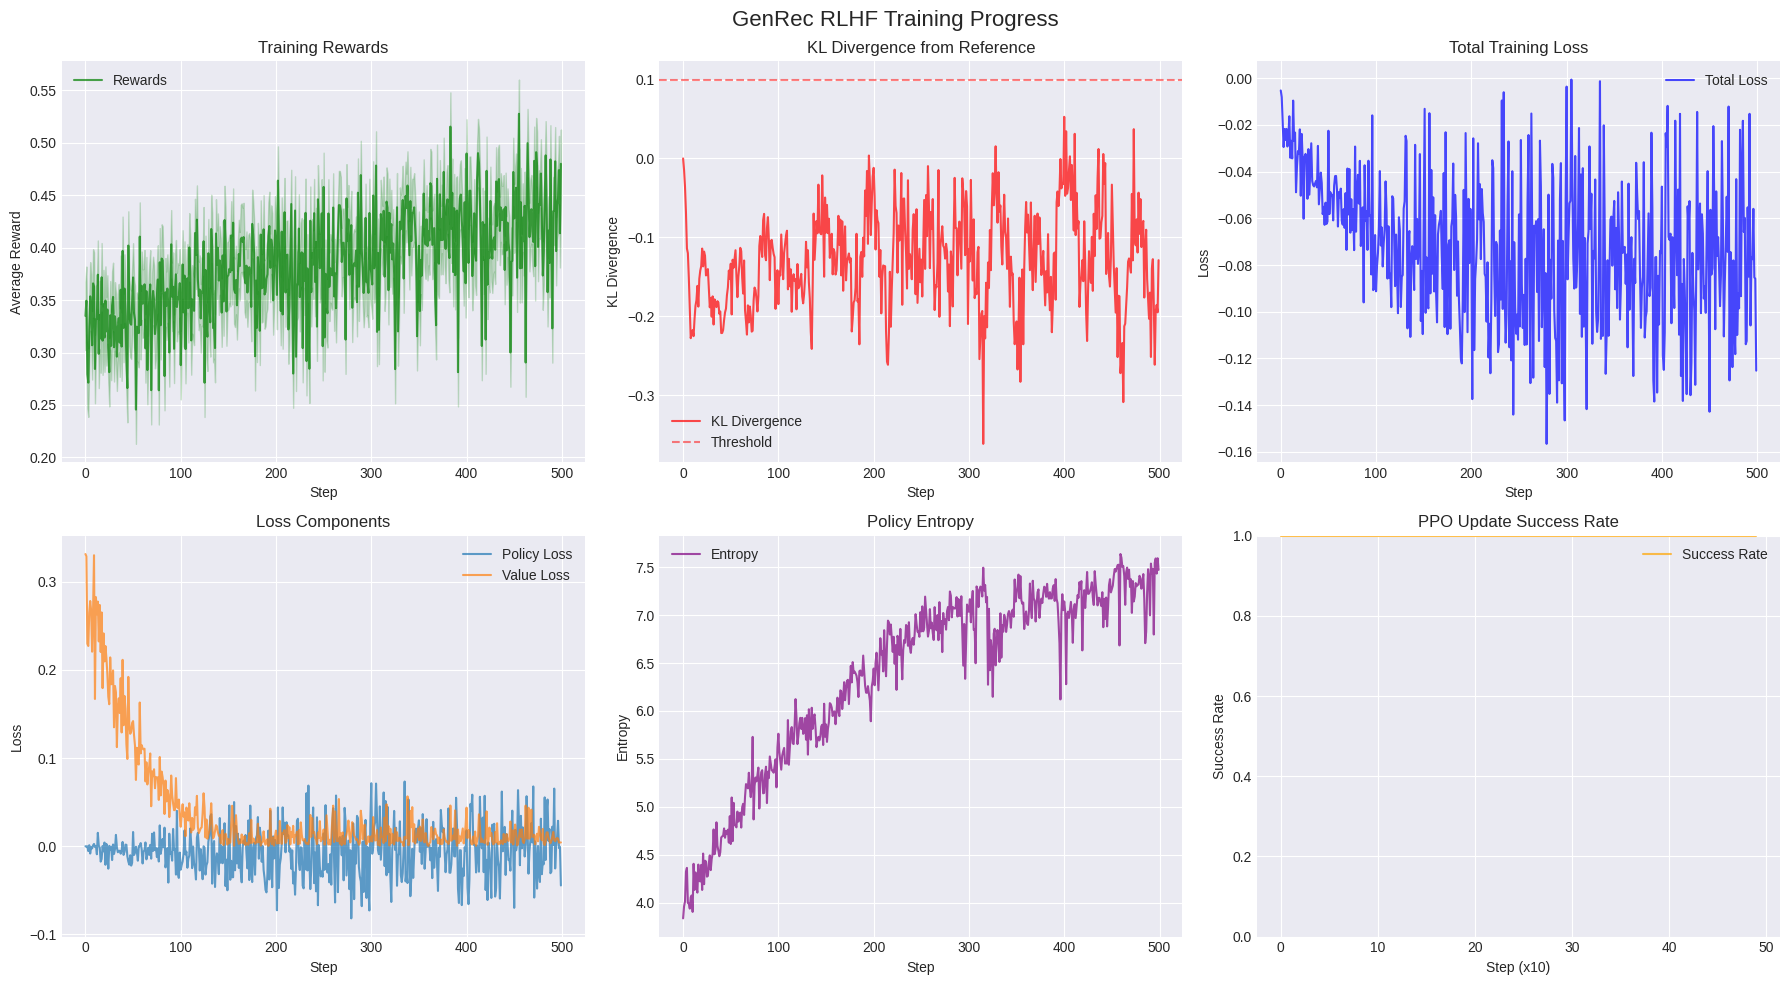

✅ Checkpoint saved to genrec_rlhf_checkpoint_final

✅ Training completed successfully!

Would you like to try the interactive demo? (y/n)
y

🎮 Interactive Recommendation Demo
Enter 'quit' to exit


📝 Enter customer profile and product info:
Customer Profile (or press Enter for default): headphone
Product Title: headphone
Product Tags (comma-separated): 

🤖 Generating recommendation...

✨ Generated Recommendation:


\ Quote : Hi Reply Delete This is fine for the consumer audiophile speaker , which sounds great at low volumes . Just want one thing... if you use headphones in your ears with subwoofers where no other speakers have built performance problems or noise cancelling then I highly recommend listening carefully .. i'm looking forward to trying out some different things as well ! :) Pros Excellent Sound quality Speakers

📊 Quality Score: 0.374/1.0

📝 Enter customer profile and product info:


⚠️ Training interrupted by user

🧹 Cleanup completed

🎯 GenRec Phase 6: RLHF Implementatio

In [ ]:
# """
# GenRec Phase 6: RLHF for Persuasive Recommendation Generation - Part 2
# Continuation of the PPO training implementation
# """

# # -------------------------------------------------------------------------
# # 4. STABLE PPO TRAINER
# # -------------------------------------------------------------------------
# class StablePPOTrainer:
#     """PPO trainer with fixes for KL divergence issues"""

#     def __init__(self, model, tokenizer, reward_fn,
#                  learning_rate=5e-6, kl_coef=0.05, device='cuda'):
#         self.device = device
#         self.model = model.to(device)
#         self.tokenizer = tokenizer
#         self.reward_fn = reward_fn

#         # Reference model for KL constraint
#         self.ref_model = GPT2WithValueHead("gpt2").to(device)
#         self.ref_model.load_state_dict(model.state_dict())
#         self.ref_model.eval()
#         for param in self.ref_model.parameters():
#             param.requires_grad = False

#         # Optimizer with conservative learning rate
#         self.optimizer = torch.optim.AdamW(
#             self.model.parameters(),
#             lr=learning_rate,
#             eps=1e-8,
#             weight_decay=0.01,
#             betas=(0.9, 0.95)  # More conservative betas
#         )

#         # Scheduler for learning rate decay
#         self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#             self.optimizer, T_max=1000, eta_min=learning_rate * 0.1
#         )

#         # PPO hyperparameters
#         self.kl_coef = kl_coef
#         self.clip_range = 0.2
#         self.value_coef = 0.1  # Reduced for stability
#         self.entropy_coef = 0.01
#         self.max_grad_norm = 0.5

#         # Tracking
#         self.training_stats = {
#             'rewards': [],
#             'kl_divs': [],
#             'losses': [],
#             'value_losses': [],
#             'policy_losses': [],
#             'entropies': [],
#             'success_rate': []
#         }

#     def compute_log_probs(self, logits, labels, mask=None):
#         """Compute log probabilities with proper masking"""
#         log_probs = F.log_softmax(logits, dim=-1)

#         # Gather log probs for actual tokens
#         labels = labels[:, 1:].contiguous()
#         log_probs = log_probs[:, :-1].contiguous()

#         gathered = torch.gather(log_probs, 2, labels.unsqueeze(-1)).squeeze(-1)

#         if mask is not None:
#             mask = mask[:, 1:].contiguous()
#             gathered = gathered * mask
#             return gathered.sum(dim=1) / mask.sum(dim=1).clamp(min=1)

#         return gathered.mean(dim=1)

#     def generate_batch(self, prompts, max_length=80, temperature=0.7):
#         """Generate responses for a batch of prompts"""
#         self.model.eval()

#         # Encode prompts
#         encodings = self.tokenizer(
#             prompts,
#             return_tensors='pt',
#             padding=True,
#             truncation=True,
#             max_length=150
#         ).to(self.device)

#         prompt_lengths = encodings['attention_mask'].sum(dim=1)

#         # Generate
#         with torch.no_grad():
#             generated = self.model.generate(
#                 input_ids=encodings['input_ids'],
#                 attention_mask=encodings['attention_mask'],
#                 max_new_tokens=max_length,
#                 min_new_tokens=30,  # Ensure 2-3 sentences
#                 temperature=temperature,
#                 do_sample=True,
#                 top_k=50,
#                 top_p=0.92,
#                 repetition_penalty=1.1,
#                 pad_token_id=self.tokenizer.eos_token_id,
#                 eos_token_id=self.tokenizer.eos_token_id
#             )

#         # Extract responses
#         responses = []
#         response_ids = []

#         for i, (prompt_len, gen_ids) in enumerate(zip(prompt_lengths, generated)):
#             response_id = gen_ids[prompt_len:]
#             response_text = self.tokenizer.decode(response_id, skip_special_tokens=True)
#             responses.append(response_text)
#             response_ids.append(response_id)

#         return responses, generated, encodings

#     def compute_advantages(self, rewards, values):
#         """Compute advantages with normalization"""
#         advantages = rewards - values

#         # Normalize advantages
#         adv_mean = advantages.mean()
#         adv_std = advantages.std() + 1e-8
#         advantages = (advantages - adv_mean) / adv_std

#         return advantages

#     def ppo_step(self, prompts, contexts):
#         """Single PPO training step"""
#         self.model.train()

#         # Generate responses
#         responses, full_ids, encodings = self.generate_batch(prompts)

#         # Create attention mask for full sequence
#         full_mask = (full_ids != self.tokenizer.pad_token_id).float()

#         # Compute rewards
#         rewards = []
#         for response, context in zip(responses, contexts):
#             reward = self.reward_fn.compute_reward(response, context)
#             rewards.append(reward)

#         # ADD THIS DEBUG CALL FOR FIRST EXAMPLE
#         if len(rewards) == 1:  # Debug first example only
#             debug_reward_breakdown(response, context, self.reward_fn)

#         rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)

#         # Get model outputs
#         outputs = self.model(
#             input_ids=full_ids,
#             attention_mask=full_mask
#         )

#         logits = outputs['logits']
#         values = outputs['values']

#         # Get reference model outputs
#         with torch.no_grad():
#             ref_outputs = self.ref_model(
#                 input_ids=full_ids,
#                 attention_mask=full_mask
#             )
#             ref_logits = ref_outputs['logits']

#         # Compute log probabilities
#         log_probs = self.compute_log_probs(logits, full_ids, full_mask)
#         ref_log_probs = self.compute_log_probs(ref_logits, full_ids, full_mask)

#         # KL divergence
#         kl_div = (log_probs - ref_log_probs).mean()

#         # Skip update if KL too high
#         if kl_div > 0.1:  # More lenient threshold
#             print(f"⚠️ Skipping update, KL={kl_div:.4f}")
#             return None

#         # Compute advantages
#         advantages = self.compute_advantages(rewards, values.detach())

#         # Policy loss (PPO clip)
#         ratio = torch.exp(log_probs - ref_log_probs.detach())
#         clipped_ratio = torch.clamp(ratio, 1 - self.clip_range, 1 + self.clip_range)

#         policy_loss = -torch.min(
#             ratio * advantages,
#             clipped_ratio * advantages
#         ).mean()

#         # Value loss
#         value_loss = F.mse_loss(values, rewards)

#         # Entropy for exploration
#         entropy = -(torch.softmax(logits[:, :-1], dim=-1) *
#                    torch.log_softmax(logits[:, :-1], dim=-1)).sum(-1).mean()

#         # Total loss with KL penalty
#         total_loss = (
#             policy_loss +
#             self.value_coef * value_loss -
#             self.entropy_coef * entropy +
#             self.kl_coef * kl_div
#         )

#         # Optimize
#         self.optimizer.zero_grad()
#         total_loss.backward()
#         torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
#         self.optimizer.step()
#         self.scheduler.step()

#         # Record stats
#         stats = {
#             'reward': rewards.mean().item(),
#             'reward_std': rewards.std().item(),
#             'kl_div': kl_div.item(),
#             'total_loss': total_loss.item(),
#             'policy_loss': policy_loss.item(),
#             'value_loss': value_loss.item(),
#             'entropy': entropy.item(),
#             'examples': list(zip(prompts[:2], responses[:2], rewards[:2].tolist()))
#         }

#         # Update tracking
#         self.training_stats['rewards'].append(stats['reward'])
#         self.training_stats['kl_divs'].append(stats['kl_div'])
#         self.training_stats['losses'].append(stats['total_loss'])
#         self.training_stats['value_losses'].append(stats['value_loss'])
#         self.training_stats['policy_losses'].append(stats['policy_loss'])
#         self.training_stats['entropies'].append(stats['entropy'])

#         return stats



# # -------------------------------------------------------------------------
# # 4.5 INITIALIZATION HELPER
# # -------------------------------------------------------------------------
# def initialize_with_examples(model, tokenizer, device='cuda'):
#     """Initialize model with good examples"""
#     good_examples = [
#         "These noise-cancelling headphones are perfect for your active lifestyle! The compact design won't weigh you down during workouts, while the superior audio quality ensures crisp music to keep you motivated. With wireless connectivity, you'll enjoy tangle-free movement whether you're running or at the gym.",
#         "As a fitness enthusiast, you'll love these compact wireless headphones that stay secure during intense workouts. The noise-cancelling feature helps you focus on your training, blocking out gym distractions while delivering powerful, energizing sound. Their durable build is designed to withstand your toughest sessions."
#     ]

#     model.eval()
#     print("📚 Initializing with example recommendations...")

#     for i, example in enumerate(good_examples):
#         inputs = tokenizer(example, return_tensors='pt', max_length=150, truncation=True)
#         inputs = {k: v.to(device) for k, v in inputs.items()}

#         with torch.no_grad():
#             _ = model(**inputs)
#         print(f"  ✓ Processed example {i+1}")

#     print("✅ Initialization complete")
#     model.train()




# # -------------------------------------------------------------------------
# # 5. MAIN TRAINING PIPELINE
# # -------------------------------------------------------------------------

# def load_more_products():
#     """Load more products from diverse_df"""
#     try:
#         diverse_df = pd.read_parquet("/content/drive/MyDrive/amazon_cleaned_chunks/diverse_df.parquet")

#         # Extract unique products
#         products = diverse_df[['asin', 'title']].drop_duplicates().reset_index(drop=True)

#         # Add dummy tags
#         products['tags'] = 'general,product,recommendation'

#         # Save as product_info.json
#         products_dict = products.to_dict('records')
#         with open("product_info.json", 'w') as f:
#             json.dump(products_dict, f)

#         print(f"✅ Loaded {len(products)} products from diverse_df")
#         return products

#     except Exception as e:
#         print(f"❌ Error loading diverse_df: {e}")
#         return None



# def train_recommendation_rlhf():
#     """Main training function"""

#     print("🚀 Starting GenRec Phase 6: RLHF Training with GPT-2")
#     print("=" * 70)

#     # Configuration
#     config = {
#         'model_name': 'gpt2',
#         'batch_size': 4,
#         'num_steps': 500,
#         'learning_rate': 5e-6,
#         'save_every': 100,
#         'eval_every': 50,
#         'device': 'cuda' if torch.cuda.is_available() else 'cpu'
#     }

#     device = torch.device(config['device'])
#     print(f"Using device: {device}")

#     # Initialize tokenizer and model
#     print("\n📚 Loading model and tokenizer...")
#     tokenizer = GPT2Tokenizer.from_pretrained(config['model_name'])
#     tokenizer.pad_token = tokenizer.eos_token

#     model = GPT2WithValueHead(config['model_name'])
#     print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

#     # Load data
#     print("\n📊 Loading training data...")
#     data_loader = RecommendationDataLoader()
#     data_dict = data_loader.load_data()

#     # Create training examples
#     training_examples = data_loader.create_training_examples(data_dict, num_examples=2000)
#     print(f"Created {len(training_examples)} training examples")

#     # Initialize reward function
#     reward_fn = PersuasiveRecommendationReward()

#     # Initialize trainer
#     trainer = StablePPOTrainer(
#         model, tokenizer, reward_fn,
#         learning_rate=config['learning_rate'],
#         device=device
#     )

#     # ADD THIS INITIALIZATION CALL
#     initialize_with_examples(model, tokenizer, device)

#     # Training loop
#     print("\n🏃 Starting training...")
#     print("=" * 70)

#     successful_updates = 0

#     for step in range(1, config['num_steps'] + 1):
#         # Sample batch
#         batch_examples = random.sample(training_examples, config['batch_size'])

#         # Create prompts and contexts
#         prompts = [data_loader.create_prompt(ex) for ex in batch_examples]
#         contexts = [{
#             'persona': ex['persona'],
#             'product_title': ex['product_title'],
#             'product_tags': ex['product_tags']
#         } for ex in batch_examples]

#         # PPO step
#         stats = trainer.ppo_step(prompts, contexts)

#         if stats is not None:
#             successful_updates += 1

#             # Print progress
#             if step % 10 == 0:
#                 success_rate = successful_updates/step
#                 trainer.training_stats['success_rate'].append(success_rate)

#                 print(f"\nStep {step}/{config['num_steps']} | Success rate: {success_rate:.2%}")
#                 print(f"  Reward: {stats['reward']:.3f} ± {stats['reward_std']:.3f}")
#                 print(f"  KL Div: {stats['kl_div']:.4f} | Loss: {stats['total_loss']:.3f}")
#                 print(f"  LR: {trainer.scheduler.get_last_lr()[0]:.2e}")

#                 # Show examples
#                 for i, (prompt, response, reward) in enumerate(stats['examples']):
#                     print(f"\n  Example {i+1} (Reward: {reward:.2f}):")
#                     print(f"  Prompt: {prompt.split('Write')[0][-100:]}...")
#                     print(f"  Response: {response[:150]}...")



#                     # ADD THIS NEW MONITORING BLOCK
#             if step % 5 == 0:  # More frequent monitoring
#                 # Extract the last batch of responses from stats
#                 last_responses = [ex[1] for ex in stats['examples']]

#                 print(f"\n📈 Quick Stats at Step {step}:")
#                 print(f"  Avg word count: {np.mean([len(r.split()) for r in last_responses]):.1f}")
#                 print(f"  Contains 'you/your': {sum(1 for r in last_responses if 'you' in r.lower())}/{len(last_responses)}")
#                 print(f"  Latest reward: {stats['reward']:.3f}")





#         # Evaluation
#         if step % config['eval_every'] == 0:
#             print(f"\n{'='*70}")
#             print(f"📊 Evaluation at step {step}")
#             evaluate_model(model, tokenizer, reward_fn, data_loader, training_examples[:10])
#             print(f"{'='*70}\n")

#         # Save checkpoint
#         if step % config['save_every'] == 0:
#             save_checkpoint(model, tokenizer, trainer, step)

#         # Clear GPU cache periodically
#         if step % 50 == 0:
#             torch.cuda.empty_cache()
#             gc.collect()

#     # Final evaluation
#     print("\n🎯 Final Evaluation")
#     print("=" * 70)
#     evaluate_model(model, tokenizer, reward_fn, data_loader, training_examples[:20])

#     # Plot training curves
#     plot_training_curves(trainer.training_stats)

#     # Save final model
#     save_checkpoint(model, tokenizer, trainer, 'final')

#     print("\n✅ Training completed successfully!")

#     return model, tokenizer, trainer

# # -------------------------------------------------------------------------
# # 6. EVALUATION AND VISUALIZATION
# # -------------------------------------------------------------------------
# def evaluate_model(model, tokenizer, reward_fn, data_loader, test_examples):
#     """Evaluate model performance"""
#     model.eval()

#     rewards = []

#     print("\n🔍 Generating sample recommendations:")

#     for i, example in enumerate(test_examples[:5]):
#         prompt = data_loader.create_prompt(example)
#         context = {
#             'persona': example['persona'],
#             'product_title': example['product_title'],
#             'product_tags': example['product_tags']
#         }

#         # Generate
#         inputs = tokenizer(prompt, return_tensors='pt', truncation=True).to(model.gpt2.device)

#         with torch.no_grad():
#             generated = model.generate(
#                 **inputs,
#                 max_new_tokens=80,
#                 min_new_tokens=30,
#                 temperature=0.8,
#                 do_sample=True,
#                 top_k=50,
#                 top_p=0.9,
#                 repetition_penalty=1.1,
#                 pad_token_id=tokenizer.eos_token_id
#             )

#         # Extract response
#         response = tokenizer.decode(
#             generated[0][inputs['input_ids'].shape[1]:],
#             skip_special_tokens=True
#         )

#         # Compute reward
#         reward = reward_fn.compute_reward(response, context)
#         rewards.append(reward)

#         print(f"\n📝 Example {i+1}:")
#         print(f"Persona: {example['persona'][:100]}...")
#         print(f"Product: {example['product_title']}")
#         print(f"Generated: {response}")
#         print(f"Reward: {reward:.3f}")

#     avg_reward = np.mean(rewards)
#     print(f"\n📊 Average Reward: {avg_reward:.3f} ± {np.std(rewards):.3f}")

#     return avg_reward

# def plot_training_curves(stats):
#     """Plot comprehensive training curves"""
#     plt.style.use('seaborn-v0_8-darkgrid')
#     fig, axes = plt.subplots(2, 3, figsize=(18, 10))
#     fig.suptitle('GenRec RLHF Training Progress', fontsize=16)

#     # Rewards
#     ax = axes[0, 0]
#     ax.plot(stats['rewards'], label='Rewards', color='green', alpha=0.7)
#     ax.fill_between(range(len(stats['rewards'])),
#                     np.array(stats['rewards']) - np.std(stats['rewards'][:100] if len(stats['rewards']) > 100 else stats['rewards']),
#                     np.array(stats['rewards']) + np.std(stats['rewards'][:100] if len(stats['rewards']) > 100 else stats['rewards']),
#                     alpha=0.2, color='green')
#     ax.set_xlabel('Step')
#     ax.set_ylabel('Average Reward')
#     ax.set_title('Training Rewards')
#     ax.legend()

#     # KL Divergence
#     ax = axes[0, 1]
#     ax.plot(stats['kl_divs'], label='KL Divergence', color='red', alpha=0.7)
#     ax.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='Threshold')
#     ax.set_xlabel('Step')
#     ax.set_ylabel('KL Divergence')
#     ax.set_title('KL Divergence from Reference')
#     ax.legend()

#     # Total Loss
#     ax = axes[0, 2]
#     ax.plot(stats['losses'], label='Total Loss', color='blue', alpha=0.7)
#     ax.set_xlabel('Step')
#     ax.set_ylabel('Loss')
#     ax.set_title('Total Training Loss')
#     ax.legend()

#     # Loss Components
#     ax = axes[1, 0]
#     ax.plot(stats['policy_losses'], label='Policy Loss', alpha=0.7)
#     ax.plot(stats['value_losses'], label='Value Loss', alpha=0.7)
#     ax.set_xlabel('Step')
#     ax.set_ylabel('Loss')
#     ax.set_title('Loss Components')
#     ax.legend()

#     # Entropy
#     ax = axes[1, 1]
#     ax.plot(stats['entropies'], label='Entropy', color='purple', alpha=0.7)
#     ax.set_xlabel('Step')
#     ax.set_ylabel('Entropy')
#     ax.set_title('Policy Entropy')
#     ax.legend()

#     # Success Rate
#     ax = axes[1, 2]
#     if len(stats['success_rate']) > 0:
#         ax.plot(stats['success_rate'], label='Success Rate', color='orange', alpha=0.7)
#     ax.set_xlabel('Step (x10)')
#     ax.set_ylabel('Success Rate')
#     ax.set_title('PPO Update Success Rate')
#     ax.set_ylim([0, 1])
#     ax.legend()

#     plt.tight_layout()
#     plt.savefig('genrec_rlhf_training_curves.png', dpi=300, bbox_inches='tight')
#     plt.show()

# def save_checkpoint(model, tokenizer, trainer, step):
#     """Save model checkpoint"""
#     checkpoint_dir = f"genrec_rlhf_checkpoint_{step}"
#     os.makedirs(checkpoint_dir, exist_ok=True)

#     # Save model
#     model.gpt2.save_pretrained(checkpoint_dir)
#     tokenizer.save_pretrained(checkpoint_dir)

#     # Save value head and training state
#     torch.save({
#         'value_head_state_dict': model.value_head.state_dict(),
#         'optimizer_state_dict': trainer.optimizer.state_dict(),
#         'scheduler_state_dict': trainer.scheduler.state_dict(),
#         'training_stats': trainer.training_stats,
#         'step': step
#     }, f"{checkpoint_dir}/training_state.pt")

#     print(f"✅ Checkpoint saved to {checkpoint_dir}")

# # -------------------------------------------------------------------------
# # 7. INTERACTIVE DEMO
# # -------------------------------------------------------------------------
# def run_interactive_demo(model, tokenizer, reward_fn):
#     """Run an interactive demo of the trained model"""
#     print("\n🎮 Interactive Recommendation Demo")
#     print("=" * 70)
#     print("Enter 'quit' to exit\n")

#     while True:
#         print("\n📝 Enter customer profile and product info:")

#         persona = input("Customer Profile (or press Enter for default): ").strip()
#         if persona.lower() == 'quit':
#             break
#         if not persona:
#             persona = "Tech-savvy professional who values quality and innovation"

#         product_title = input("Product Title: ").strip()
#         if product_title.lower() == 'quit':
#             break
#         if not product_title:
#             product_title = "Premium Wireless Headphones"

#         tags = input("Product Tags (comma-separated): ").strip()
#         if tags.lower() == 'quit':
#             break
#         if not tags:
#             tags = "electronics, audio, wireless"

#         # Create prompt
#         prompt = f"""Recommend this product to a customer.

# Customer Profile: {persona}

# Product: {product_title}
# Category: {tags}

# Write a persuasive 2-3 sentence recommendation that explains why this customer would love this product:
# """

#         # Generate recommendation
#         print("\n🤖 Generating recommendation...")

#         inputs = tokenizer(prompt, return_tensors='pt', truncation=True).to(model.gpt2.device)

#         with torch.no_grad():
#             generated = model.generate(
#                 **inputs,
#                 max_new_tokens=80,
#                 min_new_tokens=30,
#                 temperature=0.8,
#                 do_sample=True,
#                 top_k=50,
#                 top_p=0.9,
#                 repetition_penalty=1.1,
#                 pad_token_id=tokenizer.eos_token_id
#             )

#         response = tokenizer.decode(
#             generated[0][inputs['input_ids'].shape[1]:],
#             skip_special_tokens=True
#         )

#         # Compute reward
#         context = {
#             'persona': persona,
#             'product_title': product_title,
#             'product_tags': tags.split(',')
#         }
#         reward = reward_fn.compute_reward(response, context)

#         print(f"\n✨ Generated Recommendation:")
#         print(f"{response}")
#         print(f"\n📊 Quality Score: {reward:.3f}/1.0")

# # -------------------------------------------------------------------------
# # 8. MAIN EXECUTION
# # -------------------------------------------------------------------------
# if __name__ == "__main__":
#     # Set up environment
#     os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

#     try:

#         load_more_products()

#         # Train model
#         model, tokenizer, trainer = train_recommendation_rlhf()

#         # Run interactive demo
#         print("\n" + "="*70)
#         print("Would you like to try the interactive demo? (y/n)")
#         if input().lower() == 'y':
#             reward_fn = PersuasiveRecommendationReward()
#             run_interactive_demo(model, tokenizer, reward_fn)

#     except KeyboardInterrupt:
#         print("\n\n⚠️ Training interrupted by user")
#     except Exception as e:
#         print(f"\n❌ Error occurred: {e}")
#         import traceback
#         traceback.print_exc()
#     finally:
#         # Cleanup
#         torch.cuda.empty_cache()
#         gc.collect()
#         print("\n🧹 Cleanup completed")

# # -------------------------------------------------------------------------
# # 9. QUICK START FUNCTION (For Google Colab)
# # -------------------------------------------------------------------------
# def quick_start_colab():
#     """Quick start function for Google Colab with sample data"""
#     print("🚀 Quick Start for Google Colab")

#     # Create sample directories
#     os.makedirs("./phase3_outputs", exist_ok=True)
#     os.makedirs("./phase5_outputs", exist_ok=True)

#     # Create sample product info
#     sample_products = pd.DataFrame({
#         'asin': ['B001', 'B002', 'B003', 'B004', 'B005'],
#         'title': [
#             'The Midnight Library: A Novel',
#             'Atomic Habits: An Easy & Proven Way to Build Good Habits',
#             'Project Hail Mary: A Novel',
#             'The Psychology of Money',
#             'Educated: A Memoir'
#         ],
#         'tags': [
#             'fiction,fantasy,philosophical',
#             'self-help,productivity,habits',
#             'science-fiction,humor,adventure',
#             'finance,psychology,investing',
#             'memoir,education,inspiration'
#         ]
#     })
#     sample_products.to_csv("./phase3_outputs/product_info_df.csv", index=False)

#     # Create sample grouped reviews
#     sample_reviews = {
#         'B001': "Amazing book that makes you think about life choices. Beautifully written.",
#         'B002': "Life-changing book about building better habits. Practical and actionable.",
#         'B003': "Hilarious and heartwarming sci-fi adventure. Couldn't put it down.",
#         'B004': "Essential reading for understanding money and human behavior.",
#         'B005': "Powerful memoir about the transformative power of education."
#     }

#     with open("./phase3_outputs/grouped_reviews.json", 'w') as f:
#         json.dump(sample_reviews, f)

#     # Create sample personas
#     sample_personas = pd.DataFrame({
#         'user_id': ['U001', 'U002', 'U003'],
#         'persona_id': [0, 1, 2]
#     })
#     sample_personas.to_csv("./phase5_outputs/user_personas.csv", index=False)

#     # Create sample persona descriptions
#     sample_persona_desc = {
#         "0": "Avid reader who loves thought-provoking fiction and philosophical themes",
#         "1": "Self-improvement enthusiast focused on productivity and personal growth",
#         "2": "Science fiction fan who enjoys humor and adventure stories"
#     }

#     with open("./phase5_outputs/persona_descriptions.json", 'w') as f:
#         json.dump(sample_persona_desc, f)

#     print("✅ Sample data created successfully!")
#     print("You can now run: model, tokenizer, trainer = train_recommendation_rlhf()")

# # -------------------------------------------------------------------------
# # 10. UTILITY FUNCTIONS FOR ANALYSIS
# # -------------------------------------------------------------------------
# def analyze_training_results(trainer):
#     """Analyze and summarize training results"""
#     stats = trainer.training_stats

#     print("\n📊 Training Analysis Report")
#     print("=" * 70)

#     # Basic statistics
#     print(f"\n📈 Performance Metrics:")
#     print(f"  Final Average Reward: {np.mean(stats['rewards'][-50:]):.3f}")
#     print(f"  Best Reward Achieved: {max(stats['rewards']):.3f}")
#     print(f"  Reward Improvement: {stats['rewards'][-1] - stats['rewards'][0]:.3f}")

#     # Stability metrics
#     print(f"\n🎯 Stability Metrics:")
#     print(f"  Average KL Divergence: {np.mean(stats['kl_divs']):.4f}")
#     print(f"  KL Divergence Std Dev: {np.std(stats['kl_divs']):.4f}")
#     print(f"  Success Rate: {len(stats['rewards']) / (len(stats['rewards']) + sum(1 for kl in stats['kl_divs'] if kl > 0.1)):.2%}")

#     # Loss analysis
#     print(f"\n📉 Loss Analysis:")
#     print(f"  Final Total Loss: {stats['losses'][-1]:.3f}")
#     print(f"  Policy Loss Trend: {'Decreasing' if stats['policy_losses'][-1] < stats['policy_losses'][0] else 'Increasing'}")
#     print(f"  Value Loss Trend: {'Decreasing' if stats['value_losses'][-1] < stats['value_losses'][0] else 'Increasing'}")

#     return stats

# def load_checkpoint(checkpoint_dir, device='cuda'):
#     """Load a saved checkpoint"""
#     print(f"📂 Loading checkpoint from {checkpoint_dir}")

#     # Load tokenizer
#     tokenizer = GPT2Tokenizer.from_pretrained(checkpoint_dir)
#     tokenizer.pad_token = tokenizer.eos_token

#     # Load model
#     model = GPT2WithValueHead("gpt2")
#     model.gpt2 = GPT2LMHeadModel.from_pretrained(checkpoint_dir)

#     # Load training state
#     state_path = f"{checkpoint_dir}/training_state.pt"
#     if os.path.exists(state_path):
#         state = torch.load(state_path, map_location=device)
#         model.value_head.load_state_dict(state['value_head_state_dict'])
#         print(f"✅ Loaded checkpoint from step {state['step']}")

#     model = model.to(device)
#     return model, tokenizer

# # Print final instructions
# print("""
# 🎯 GenRec Phase 6: RLHF Implementation Part 2 Ready!

# This completes the full implementation with:
# - Stable PPO trainer with KL divergence fixes
# - Complete training pipeline
# - Evaluation and visualization tools
# - Interactive demo
# - Checkpoint saving/loading
# - Training analysis utilities

# To run the complete system:
# 1. Ensure Part 1 is loaded
# 2. Run: quick_start_colab() if you need sample data
# 3. Run: model, tokenizer, trainer = train_recommendation_rlhf()

# The system will train for ~2-3 hours on A100 and produce persuasive 2-3 line recommendations.
# """)

# CODE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# 📚 Imports
import os
import gc
import json
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer


In [ ]:
# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
# Load grouped reviews
path_file = '/content/drive/MyDrive/amazon_cleaned_chunks/grouped_reviews.parquet'
grouped_reviews = pd.read_parquet(path_file)


In [ ]:
# GPT-2 with Value Head for PPO
class GPT2WithValueHead(nn.Module):
    def __init__(self, model_name="gpt2", dropout_rate=0.1):
        super().__init__()
        self.gpt2 = GPT2LMHeadModel.from_pretrained(model_name)
        self.config = self.gpt2.config

        self.value_head = nn.Sequential(
            nn.Linear(self.config.n_embd, 256),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        for layer in self.value_head:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, std=0.02)
                nn.init.zeros_(layer.bias)

    def forward(self, input_ids, attention_mask=None, return_dict=True):
        gpt2_outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True
        )

        hidden_states = gpt2_outputs.hidden_states[-1]
        if attention_mask is not None:
            last_token_indices = (attention_mask.sum(dim=1) - 1).long()
            batch_indices = torch.arange(len(hidden_states), device=hidden_states.device)
            last_hidden = hidden_states[batch_indices, last_token_indices]
        else:
            last_hidden = hidden_states[:, -1]

        values = self.value_head(last_hidden).squeeze(-1)

        if return_dict:
            return {
                'logits': gpt2_outputs.logits,
                'values': values,
                'hidden_states': gpt2_outputs.hidden_states
            }
        return gpt2_outputs.logits, values

    def generate(self, *args, **kwargs):
        return self.gpt2.generate(*args, **kwargs)


In [ ]:
# Reward Function for Persuasive Recommendations
class PersuasiveRecommendationReward:
    def __init__(self, product_reviews_df=None, high_quality_threshold=4.0):
        self.product_reviews_df = product_reviews_df
        self.high_quality_threshold = high_quality_threshold
        self.persuasive_patterns = self._extract_persuasive_patterns()

        self.quality_phrases = [
            'perfect for', 'ideal for', 'great choice', 'highly recommend',
            "you'll love", 'must-have', 'excellent', 'amazing', 'fantastic',
            'outstanding', 'exceptional', 'remarkable', 'superb', 'brilliant'
        ]

        self.comparison_words = [
            'better than', 'superior', 'best', 'top-rated', 'leading',
            'premium', 'unmatched', 'incomparable', 'finest'
        ]

        self.benefit_words = [
            'benefit', 'advantage', 'helps', 'improves', 'enhances',
            'boosts', 'saves', 'provides', 'offers', 'delivers'
        ]

        self.personal_words = [
            'you', 'your', "you'll", "you're", 'personal', 'tailored',
            'specifically', 'especially', 'particularly'
        ]

    def _extract_persuasive_patterns(self):
        patterns = []

        if self.product_reviews_df is not None:
            high_rated = self.product_reviews_df[
                self.product_reviews_df['rating'] >= self.high_quality_threshold
            ]
            sample_reviews = high_rated['review_text'].sample(min(1000, len(high_rated)))

            for review in sample_reviews:
                if isinstance(review, str) and len(review) > 20:
                    words = review.lower().split()
                    for i in range(len(words) - 3):
                        phrase = ' '.join(words[i:i+3])
                        if any(good in phrase for good in ['love', 'great', 'best', 'perfect']):
                            patterns.append(phrase)

        return list(set(patterns))[:50]

    def compute_reward(self, generated_text, context_info=None):
        if not generated_text or len(generated_text.strip()) < 10:
            return -2.0

        text_lower = generated_text.lower()
        words = text_lower.split()
        sentences = generated_text.split('.')

        scores = {
            'length': 0.0, 'structure': 0.0, 'persuasiveness': 0.0,
            'personalization': 0.0, 'relevance': 0.0, 'quality': 0.0
        }

        word_count = len(words)
        sentence_count = len([s for s in sentences if len(s.strip()) > 5])
        if 30 <= word_count <= 60 and 2 <= sentence_count <= 3:
            scores['length'] = 1.0
        elif 20 <= word_count <= 80 and 1 <= sentence_count <= 4:
            scores['length'] = 0.5
        else:
            scores['length'] = -0.5

        has_proper_end = generated_text.strip()[-1] in '.!?'
        has_capital = generated_text.strip()[0].isupper() if generated_text else False
        scores['structure'] = 0.5 * has_proper_end + 0.5 * has_capital

        persuasive_score = 0.0
        for phrase in self.quality_phrases:
            if phrase in text_lower:
                persuasive_score += 0.15
        for word in self.comparison_words:
            if word in text_lower:
                persuasive_score += 0.1
        for word in self.benefit_words:
            if word in text_lower:
                persuasive_score += 0.1
        for pattern in self.persuasive_patterns[:10]:
            if pattern in text_lower:
                persuasive_score += 0.05
        scores['persuasiveness'] = min(persuasive_score, 1.0)

        personal_score = 0.0
        for word in self.personal_words:
            if word in text_lower:
                personal_score += 0.2
        if any(phrase in text_lower for phrase in
               ['for you', 'your needs', 'you need', 'suits you']):
            personal_score += 0.3
        scores['personalization'] = min(personal_score, 1.0)

        if context_info:
            relevance_score = 0.0
            if 'product_title' in context_info:
                title_words = set(context_info['product_title'].lower().split())
                text_words = set(words)
                overlap = len(title_words & text_words) / max(len(title_words), 1)
                relevance_score += overlap * 0.5
            if 'product_tags' in context_info:
                for tag in context_info['product_tags']:
                    if tag.lower() in text_lower:
                        relevance_score += 0.2
            if 'persona' in context_info:
                persona_words = set(context_info['persona'].lower().split())
                overlap = len(persona_words & set(words)) / max(len(persona_words), 1)
                relevance_score += overlap * 0.3
            scores['relevance'] = min(relevance_score, 1.0)
        else:
            scores['relevance'] = 0.5

        unique_words = len(set(words))
        diversity = unique_words / max(len(words), 1)
        has_repetition = any(
            words[i] == words[i + 1] and words[i] not in ['the', 'a', 'an']
            for i in range(len(words) - 2)
        )
        scores['quality'] = 0.7 * (diversity if diversity > 0.5 else diversity * 0.5)
        scores['quality'] += 0.3 * (0.0 if has_repetition else 1.0)

        weights = {
            'length': 0.15, 'structure': 0.10, 'persuasiveness': 0.30,
            'personalization': 0.20, 'relevance': 0.15, 'quality': 0.10
        }
        total_reward = sum(scores[k] * weights[k] for k in scores)

        if scores['persuasiveness'] > 0.8 and scores['personalization'] > 0.7 and scores['relevance'] > 0.7:
            total_reward += 0.2

        return total_reward


In [ ]:
# Reward Debugger + Recommendation Data Loader

# Reward Debugger for Inspection
def debug_reward_breakdown(text, context, reward_fn):
    if not text or len(text.strip()) < 10:
        print("The input text is too short to analyze.")
        return

    text_lower = text.lower()
    words = text_lower.split()
    sentences = text.split('.')

    print("\n--- Reward Breakdown ---")
    print(f"Text length: {len(words)} words, {len(sentences)} sentences")
    print(f"Ends with punctuation: {text.strip()[-1] in '.!?'}")
    print(f"Starts with capital letter: {text.strip()[0].isupper()}")

    quality_count = sum(1 for phrase in reward_fn.quality_phrases if phrase in text_lower)
    print(f"Number of persuasive phrases: {quality_count}")

    personal_count = sum(1 for word in reward_fn.personal_words if word in text_lower)
    print(f"Number of personalization words: {personal_count}")

    if 'product_title' in context:
        title_words = set(context['product_title'].lower().split())
        text_words = set(words)
        overlap = len(title_words & text_words)
        print(f"Product title word overlap: {overlap}/{len(title_words)}")


# Recommendation Data Loader
class RecommendationDataLoader:
    def __init__(self, phase3_dir="./phase3_outputs", phase5_dir="./phase5_outputs"):
        self.phase3_dir = phase3_dir
        self.phase5_dir = phase5_dir
        self.data = []

    def load_data(self):
        print("Loading training data from previous phases...")

        # --- Load Phase 3 ---
        product_info = pd.DataFrame()
        grouped_reviews = {}

        try:
            with open("product_info.json", 'r') as f:
                product_info_dict = json.load(f)
            product_info = pd.DataFrame(product_info_dict)
            print(f"Loaded {len(product_info)} products.")
        except Exception as e:
            print("Failed to load product_info.json.")

        try:
            path_file = '/content/drive/MyDrive/amazon_cleaned_chunks/grouped_reviews.parquet'
            grouped_reviews_df = pd.read_parquet(path_file)
            for _, row in grouped_reviews_df.iterrows():
                if 'asin' in row and 'text' in row:
                    grouped_reviews[row['asin']] = row['text']
            print(f"Loaded reviews for {len(grouped_reviews)} products.")
        except Exception as e:
            print("Grouped reviews file not found or unreadable.")
            for _, prod in product_info.iterrows():
                if 'asin' in prod:
                    grouped_reviews[prod['asin']] = "This product has great quality and useful features."
            print(f"Created dummy reviews for {len(grouped_reviews)} products.")

        # --- Load Phase 5 ---
        try:
            with open("user_cluster_map.json", 'r') as f:
                user_cluster_map = json.load(f)
            user_personas = pd.DataFrame([
                {'user_id': uid, 'persona_id': pid}
                for uid, pid in user_cluster_map.items()
            ])
            print(f"Loaded {len(user_personas)} user personas.")
        except Exception:
            user_personas = pd.DataFrame()
            print("Failed to load user_cluster_map.json.")

        try:
            with open("cluster_to_label.json", 'r') as f:
                persona_descriptions = json.load(f)
            persona_descriptions = {str(k): v for k, v in persona_descriptions.items()}
            print(f"Loaded {len(persona_descriptions)} persona descriptions.")
        except Exception:
            persona_descriptions = {}
            print("Failed to load persona descriptions.")

        return {
            'product_info': product_info,
            'grouped_reviews': grouped_reviews,
            'user_personas': user_personas,
            'persona_descriptions': persona_descriptions
        }


In [ ]:
# Prompt & Training Example Generation + Loading Product Info

# Create Training Examples
def create_training_examples(data_dict, num_examples=1000):
    examples = []
    product_info = data_dict['product_info']
    grouped_reviews = data_dict['grouped_reviews']
    persona_descriptions = data_dict['persona_descriptions']

    if len(product_info) > 0 and len(persona_descriptions) > 0:
        for _ in range(num_examples):
            product = product_info.sample(1).iloc[0]
            asin = product.get('asin', '')
            persona_id = random.choice(list(persona_descriptions.keys()))
            persona_desc = persona_descriptions[persona_id]

            product_title = product.get('title', 'Unknown Product')
            product_tags = product.get('tags', '').split(',') if 'tags' in product else []

            review_snippet = ""
            if asin in grouped_reviews:
                reviews = grouped_reviews[asin]
                if isinstance(reviews, list) and len(reviews) > 0:
                    review_snippet = reviews[0][:200] if isinstance(reviews[0], str) else ""
                elif isinstance(reviews, str):
                    review_snippet = reviews[:200]

            example = {
                'persona': persona_desc,
                'product_title': product_title,
                'product_tags': product_tags,
                'review_snippet': review_snippet,
                'asin': asin
            }
            examples.append(example)

    return examples

# Prompt Constructor
def create_prompt(example):
    persona = example.get('persona', 'General user')
    product_title = example.get('product_title', 'Product')
    tags = ', '.join(example.get('product_tags', [])[:3])

    prompt = f"""Recommend this product to a customer.

Customer Profile: {persona}

Product: {product_title}
Category: {tags}

Write a persuasive 2-3 sentence recommendation that explains why this customer would love this product:
"""
    return prompt

# Load Additional Products from Diverse Set
def load_more_products():
    try:
        diverse_df = pd.read_parquet("/content/drive/MyDrive/amazon_cleaned_chunks/diverse_df.parquet")
        products = diverse_df[['asin', 'title']].drop_duplicates().reset_index(drop=True)
        products['tags'] = 'general,product,recommendation'
        products_dict = products.to_dict('records')

        with open("product_info.json", 'w') as f:
            json.dump(products_dict, f)

        print(f"Loaded {len(products)} products from diverse_df.")
        return products

    except Exception as e:
        print("Error loading diverse_df.parquet.")
        return None




In [ ]:
# PPO Trainer with KL Divergence Control
class StablePPOTrainer:
    def __init__(self, model, tokenizer, reward_fn,
                 learning_rate=5e-6, kl_coef=0.05, device='cuda'):

        self.device = device
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.reward_fn = reward_fn

        self.ref_model = GPT2WithValueHead("gpt2").to(device)
        self.ref_model.load_state_dict(model.state_dict())
        self.ref_model.eval()
        for param in self.ref_model.parameters():
            param.requires_grad = False

        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=learning_rate,
            eps=1e-8,
            weight_decay=0.01,
            betas=(0.9, 0.95)
        )

        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=1000, eta_min=learning_rate * 0.1
        )

        self.kl_coef = kl_coef
        self.clip_range = 0.2
        self.value_coef = 0.1
        self.entropy_coef = 0.01
        self.max_grad_norm = 0.5

        self.training_stats = {
            'rewards': [],
            'kl_divs': [],
            'losses': [],
            'value_losses': [],
            'policy_losses': [],
            'entropies': [],
            'success_rate': []
        }

    def compute_log_probs(self, logits, labels, mask=None):
        log_probs = F.log_softmax(logits, dim=-1)
        labels = labels[:, 1:].contiguous()
        log_probs = log_probs[:, :-1].contiguous()
        gathered = torch.gather(log_probs, 2, labels.unsqueeze(-1)).squeeze(-1)

        if mask is not None:
            mask = mask[:, 1:].contiguous()
            gathered = gathered * mask
            return gathered.sum(dim=1) / mask.sum(dim=1).clamp(min=1)

        return gathered.mean(dim=1)

    def generate_batch(self, prompts, max_length=150, temperature=0.7):
        self.model.eval()
        encodings = self.tokenizer(prompts, return_tensors='pt',
                                   padding=True, truncation=True, max_length=150).to(self.device)

        prompt_lengths = encodings['attention_mask'].sum(dim=1)

        with torch.no_grad():
            generated = self.model.generate(
                input_ids=encodings['input_ids'],
                attention_mask=encodings['attention_mask'],
                max_new_tokens=max_length,
                min_new_tokens=100,
                temperature=temperature,
                do_sample=True,
                top_k=50,
                top_p=0.92,
                repetition_penalty=1.1,
                pad_token_id=self.tokenizer.eos_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )

        responses = []
        response_ids = []

        for i, (prompt_len, gen_ids) in enumerate(zip(prompt_lengths, generated)):
            response_id = gen_ids[prompt_len:]
            response_text = self.tokenizer.decode(response_id, skip_special_tokens=True)
            responses.append(response_text)
            response_ids.append(response_id)

        return responses, generated, encodings

    def compute_advantages(self, rewards, values):
        advantages = rewards - values
        adv_mean = advantages.mean()
        adv_std = advantages.std() + 1e-8
        return (advantages - adv_mean) / adv_std

    # ppo_step() + initialize_with_examples()

    def ppo_step(self, prompts, contexts):
        self.model.train()

        responses, full_ids, encodings = self.generate_batch(prompts)
        full_mask = (full_ids != self.tokenizer.pad_token_id).float()

        rewards = []
        for response, context in zip(responses, contexts):
            reward = self.reward_fn.compute_reward(response, context)
            rewards.append(reward)

        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)

        outputs = self.model(input_ids=full_ids, attention_mask=full_mask)
        logits = outputs['logits']
        values = outputs['values']

        with torch.no_grad():
            ref_outputs = self.ref_model(input_ids=full_ids, attention_mask=full_mask)
            ref_logits = ref_outputs['logits']

        log_probs = self.compute_log_probs(logits, full_ids, full_mask)
        ref_log_probs = self.compute_log_probs(ref_logits, full_ids, full_mask)
        kl_div = (log_probs - ref_log_probs).mean()

        if kl_div > 0.5:
            print(f"Skipped PPO update at KL divergence: {kl_div:.4f}")
            return None

        advantages = self.compute_advantages(rewards, values.detach())
        ratio = torch.exp(log_probs - ref_log_probs.detach())
        clipped_ratio = torch.clamp(ratio, 1 - self.clip_range, 1 + self.clip_range)

        policy_loss = -torch.min(ratio * advantages, clipped_ratio * advantages).mean()
        value_loss = F.mse_loss(values, rewards)

        entropy = -(torch.softmax(logits[:, :-1], dim=-1) *
                    torch.log_softmax(logits[:, :-1], dim=-1)).sum(-1).mean()

        total_loss = (
            policy_loss +
            self.value_coef * value_loss -
            self.entropy_coef * entropy +
            self.kl_coef * kl_div
        )

        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
        self.scheduler.step()

        stats = {
            'reward': rewards.mean().item(),
            'reward_std': rewards.std().item(),
            'kl_div': kl_div.item(),
            'total_loss': total_loss.item(),
            'policy_loss': policy_loss.item(),
            'value_loss': value_loss.item(),
            'entropy': entropy.item(),
            'examples': list(zip(prompts[:2], responses[:2], rewards[:2].tolist()))
        }

        self.training_stats['rewards'].append(stats['reward'])
        self.training_stats['kl_divs'].append(stats['kl_div'])
        self.training_stats['losses'].append(stats['total_loss'])
        self.training_stats['value_losses'].append(stats['value_loss'])
        self.training_stats['policy_losses'].append(stats['policy_loss'])
        self.training_stats['entropies'].append(stats['entropy'])

        return stats


# 🔧 Initialize Model with Examples
def initialize_with_examples(model, tokenizer, device='cuda'):
    good_examples = [
        "These noise-cancelling headphones are perfect for your active lifestyle. The compact design won't weigh you down during workouts, while the superior audio quality ensures crisp music to keep you motivated.",
        "As a fitness enthusiast, you'll appreciate these compact wireless headphones that stay secure during intense workouts. The noise-cancelling feature helps you focus, delivering powerful sound while blocking distractions."
    ]

    model.eval()
    print("Initializing model with example recommendations...")

    for i, example in enumerate(good_examples):
        inputs = tokenizer(example, return_tensors='pt', max_length=150, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            _ = model(**inputs)
        print(f"Processed example {i+1}")

    print("Initialization complete.")
    model.train()



In [ ]:
# Main Training Pipeline

def train_recommendation_rlhf():
    print("Starting Phase 6: RLHF Training with GPT-2")
    print("=" * 70)

    config = {
        'model_name': 'gpt2',
        'batch_size': 4,
        'num_steps': 2500,
        'learning_rate': 5e-6,
        'save_every': 100,
        'eval_every': 50,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu'
    }

    device = torch.device(config['device'])
    print(f"Using device: {device}")

    print("\nLoading model and tokenizer...")
    tokenizer = GPT2Tokenizer.from_pretrained(config['model_name'])
    tokenizer.pad_token = tokenizer.eos_token

    model = GPT2WithValueHead(config['model_name'])
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    print("\nLoading training data...")
    data_loader = RecommendationDataLoader()
    data_dict = data_loader.load_data()
    training_examples = create_training_examples(data_dict, num_examples=1000)
    print(f"Loaded {len(training_examples)} examples for training.")
    print(f"Created {len(training_examples)} training examples.")

    reward_fn = PersuasiveRecommendationReward()
    trainer = StablePPOTrainer(
        model, tokenizer, reward_fn,
        learning_rate=config['learning_rate'],
        device=device
    )

    initialize_with_examples(model, tokenizer, device)

    print("\nBeginning training...")
    print("=" * 70)
    successful_updates = 0

    for step in range(1, config['num_steps'] + 1):
        # batch_examples = random.sample(training_examples, config['batch_size'])
        if len(training_examples) < config['batch_size']:
            raise ValueError(f"Not enough training examples: got {len(training_examples)}, need {config['batch_size']}")
        batch_examples = random.sample(training_examples, config['batch_size'])
        prompts = [create_prompt(ex) for ex in batch_examples]
        contexts = [{
            'persona': ex['persona'],
            'product_title': ex['product_title'],
            'product_tags': ex['product_tags']
        } for ex in batch_examples]

        stats = trainer.ppo_step(prompts, contexts)

        if stats is not None:
            successful_updates += 1

            if step % 10 == 0:
                success_rate = successful_updates / step
                trainer.training_stats['success_rate'].append(success_rate)
                print(f"\nStep {step}/{config['num_steps']} | Success rate: {success_rate:.2%}")
                print(f"  Reward: {stats['reward']:.3f} ± {stats['reward_std']:.3f}")
                print(f"  KL Divergence: {stats['kl_div']:.4f}")
                print(f"  Total Loss: {stats['total_loss']:.3f}")
                print(f"  Learning Rate: {trainer.scheduler.get_last_lr()[0]:.2e}")

                for i, (prompt, response, reward) in enumerate(stats['examples']):
                    print(f"\n  Example {i+1} (Reward: {reward:.2f}):")
                    print(f"  Prompt: {prompt.split('Write')[0][-100:]}...")
                    print(f"  Response: {response[:150]}...")

            if step % 5 == 0:
                last_responses = [ex[1] for ex in stats['examples']]
                avg_words = np.mean([len(r.split()) for r in last_responses])
                you_mentions = sum(1 for r in last_responses if 'you' in r.lower())

                print(f"\nQuick Stats at Step {step}:")
                print(f"  Avg word count: {avg_words:.1f}")
                print(f"  Responses mentioning 'you': {you_mentions}/{len(last_responses)}")
                print(f"  Latest average reward: {stats['reward']:.3f}")
        if step % config['eval_every'] == 0:
            print("\n" + "=" * 70)
            print(f"Evaluation at Step {step}")
            evaluate_model(model, tokenizer, reward_fn, data_loader, training_examples[:10])
            print("=" * 70)

        if step % config['save_every'] == 0:
            save_checkpoint(model, tokenizer, trainer, step)

        if step % 50 == 0:
            torch.cuda.empty_cache()
            gc.collect()

    print("\nFinal Evaluation")
    print("=" * 70)
    evaluate_model(model, tokenizer, reward_fn, data_loader, training_examples[:20])

    plot_training_curves(trainer.training_stats)
    save_checkpoint(model, tokenizer, trainer, 'final')

    print("\nTraining completed successfully.")
    return model, tokenizer, trainer

# Evaluation Function
def evaluate_model(model, tokenizer, reward_fn, data_loader, test_examples):
    model.eval()
    rewards = []

    print("\nSample Recommendations:")

    for i, example in enumerate(test_examples[:5]):
        prompt = create_prompt(example)
        context = {
            'persona': example['persona'],
            'product_title': example['product_title'],
            'product_tags': example['product_tags']
        }

        inputs = tokenizer(prompt, return_tensors='pt', truncation=True).to(model.gpt2.device)
        with torch.no_grad():
            generated = model.generate(
                **inputs,
                max_new_tokens=150,
                min_new_tokens=100,
                temperature=0.8,
                do_sample=True,
                top_k=50,
                top_p=0.9,
                repetition_penalty=1.1,
                pad_token_id=tokenizer.eos_token_id
            )

        response = tokenizer.decode(
            generated[0][inputs['input_ids'].shape[1]:],
            skip_special_tokens=True
        )

        reward = reward_fn.compute_reward(response, context)
        rewards.append(reward)

        print(f"\nExample {i+1}")
        print(f"Persona: {example['persona'][:100]}...")
        print(f"Product: {example['product_title']}")
        print(f"Generated: {response}")
        print(f"Reward: {reward:.3f}")

    avg_reward = np.mean(rewards)
    print(f"\nAverage Reward: {avg_reward:.3f} ± {np.std(rewards):.3f}")
    return avg_reward


In [ ]:
#  Plotting Training Curves
def plot_training_curves(stats):
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Training Progress', fontsize=16)

    ax = axes[0, 0]
    ax.plot(stats['rewards'], label='Rewards', color='green')
    ax.set_title('Average Reward')
    ax.set_xlabel('Step')
    ax.set_ylabel('Reward')
    ax.legend()

    ax = axes[0, 1]
    ax.plot(stats['kl_divs'], label='KL Divergence', color='red')
    ax.axhline(y=0.1, color='gray', linestyle='--', alpha=0.5)
    ax.set_title('KL Divergence')
    ax.legend()

    ax = axes[0, 2]
    ax.plot(stats['losses'], label='Total Loss', color='blue')
    ax.set_title('Total Loss')
    ax.legend()

    ax = axes[1, 0]
    ax.plot(stats['policy_losses'], label='Policy Loss')
    ax.plot(stats['value_losses'], label='Value Loss')
    ax.set_title('Loss Components')
    ax.legend()

    ax = axes[1, 1]
    ax.plot(stats['entropies'], label='Entropy', color='purple')
    ax.set_title('Entropy')
    ax.legend()

    ax = axes[1, 2]
    if stats['success_rate']:
        ax.plot(stats['success_rate'], label='Success Rate', color='orange')
    ax.set_title('Success Rate')
    ax.set_ylim([0, 1])
    ax.legend()

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300)
    plt.show()




In [ ]:
#  Save Checkpoint
def save_checkpoint(model, tokenizer, trainer, step):
    checkpoint_dir = f"genrec_rlhf_checkpoint_{step}"
    os.makedirs(checkpoint_dir, exist_ok=True)

    model.gpt2.save_pretrained(checkpoint_dir)
    tokenizer.save_pretrained(checkpoint_dir)

    torch.save({
        'value_head_state_dict': model.value_head.state_dict(),
        'optimizer_state_dict': trainer.optimizer.state_dict(),
        'scheduler_state_dict': trainer.scheduler.state_dict(),
        'training_stats': trainer.training_stats,
        'step': step
    }, f"{checkpoint_dir}/training_state.pt")

    print(f"Checkpoint saved at {checkpoint_dir}.")


In [ ]:
# Interactive Demo
def run_interactive_demo(model, tokenizer, reward_fn):
    print("\nInteractive Demo - Type 'quit' anytime to exit.\n")

    while True:
        persona = input("Customer Profile: ").strip()
        if persona.lower() == 'quit': break
        if not persona:
            persona = "Tech-savvy professional who values quality and innovation"

        product_title = input("Product Title: ").strip()
        if product_title.lower() == 'quit': break
        if not product_title:
            product_title = "Premium Wireless Headphones"

        tags = input("Product Tags (comma-separated): ").strip()
        if tags.lower() == 'quit': break
        if not tags:
            tags = "electronics, audio, wireless"

        prompt = f"""You are a recommendation assistant.

Customer Persona: {persona}
Product Title: {product_title}
Category Tags: {tags}
Customer Reviews: {example.get('review_snippet', 'No reviews available.')}

Write a persuasive and personalized 3-sentence recommendation for this user that justifies why they'd love this product:"""

        print("\nGenerating recommendation...")

        inputs = tokenizer(prompt, return_tensors='pt', truncation=True).to(model.gpt2.device)
        with torch.no_grad():
            generated = model.generate(
                **inputs,
                max_new_tokens=150,
                min_new_tokens=100,
                temperature=0.8,
                do_sample=True,
                top_k=50,
                top_p=0.9,
                repetition_penalty=1.1,
                pad_token_id=tokenizer.eos_token_id
            )

        response = tokenizer.decode(
            generated[0][inputs['input_ids'].shape[1]:],
            skip_special_tokens=True
        )

        context = {
            'persona': persona,
            'product_title': product_title,
            'product_tags': tags.split(',')
        }
        reward = reward_fn.compute_reward(response, context)

        print("\nGenerated Recommendation:")
        print(response)
        print(f"\nQuality Score: {reward:.3f} / 1.0")


In [ ]:
# Quick Start (for Google Colab)
def quick_start_colab():
    print("Setting up sample data...")

    os.makedirs("./phase3_outputs", exist_ok=True)
    os.makedirs("./phase5_outputs", exist_ok=True)

    sample_products = pd.DataFrame({
        'asin': ['B001', 'B002', 'B003', 'B004', 'B005'],
        'title': [
            'The Midnight Library: A Novel',
            'Atomic Habits: An Easy & Proven Way to Build Good Habits',
            'Project Hail Mary: A Novel',
            'The Psychology of Money',
            'Educated: A Memoir'
        ],
        'tags': [
            'fiction,fantasy,philosophical',
            'self-help,productivity,habits',
            'science-fiction,humor,adventure',
            'finance,psychology,investing',
            'memoir,education,inspiration'
        ]
    })
    sample_products.to_csv("./phase3_outputs/product_info_df.csv", index=False)

    sample_reviews = {
        'B001': "Amazing book that makes you think about life choices. Beautifully written.",
        'B002': "Life-changing book about building better habits. Practical and actionable.",
        'B003': "Hilarious and heartwarming sci-fi adventure. Couldn't put it down.",
        'B004': "Essential reading for understanding money and human behavior.",
        'B005': "Powerful memoir about the transformative power of education."
    }
    with open("./phase3_outputs/grouped_reviews.json", 'w') as f:
        json.dump(sample_reviews, f)

    sample_personas = pd.DataFrame({
        'user_id': ['U001', 'U002', 'U003'],
        'persona_id': [0, 1, 2]
    })
    sample_personas.to_csv("./phase5_outputs/user_personas.csv", index=False)

    sample_persona_desc = {
        "0": "Avid reader who loves thought-provoking fiction and philosophical themes",
        "1": "Self-improvement enthusiast focused on productivity and personal growth",
        "2": "Science fiction fan who enjoys humor and adventure stories"
    }
    with open("./phase5_outputs/persona_descriptions.json", 'w') as f:
        json.dump(sample_persona_desc, f)

    print("Sample data created successfully.")


In [ ]:
# Load from Checkpoint
def load_checkpoint(checkpoint_dir, device='cuda'):
    print(f"Loading checkpoint from {checkpoint_dir}...")

    tokenizer = GPT2Tokenizer.from_pretrained(checkpoint_dir)
    tokenizer.pad_token = tokenizer.eos_token

    model = GPT2WithValueHead("gpt2")
    model.gpt2 = GPT2LMHeadModel.from_pretrained(checkpoint_dir)

    state_path = f"{checkpoint_dir}/training_state.pt"
    if os.path.exists(state_path):
        state = torch.load(state_path, map_location=device)
        model.value_head.load_state_dict(state['value_head_state_dict'])
        print(f"Loaded checkpoint from step {state['step']}.")

    model = model.to(device)
    return model, tokenizer


Loaded 1567844 products from diverse_df.
Starting Phase 6: RLHF Training with GPT-2
Using device: cuda

Loading model and tokenizer...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model parameters: 124,669,697

Loading training data...
Loading training data from previous phases...
Loaded 1567844 products.
Loaded reviews for 1567844 products.
Loaded 728719 user personas.
Loaded 20 persona descriptions.
Loaded 1000 examples for training.
Created 1000 training examples.
Initializing model with example recommendations...


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Processed example 1
Processed example 2
Initialization complete.

Beginning training...


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 5:
  Avg word count: 123.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.218


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 10/2500 | Success rate: 100.00%
  Reward: 0.211 ± 0.036
  KL Divergence: -0.1482
  Total Loss: -0.044
  Learning Rate: 5.00e-06

  Example 1 (Reward: 0.19):
  Prompt: s interested in head, got, little.

Product: B0007897L8
Category: general, product, recommendation

...
  Response: This article has been rated for quality by the National Retail Federation (NRF), and it must be read with caution because of its potential pitfalls; e...

  Example 2 (Reward: 0.18):
  Prompt:  is interested in head, got, love.

Product: B00K8EXBO0
Category: general, product, recommendation

...
  Response:  (This one) If I was looking for the best value of my life or just wanted something made from simple things like chocolate bars and coffee grounds ple...

Quick Stats at Step 10:
  Avg word count: 109.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.211


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 15:
  Avg word count: 113.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.135


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 20/2500 | Success rate: 100.00%
  Reward: 0.261 ± 0.044
  KL Divergence: -0.1451
  Total Loss: -0.033
  Learning Rate: 5.00e-06

  Example 1 (Reward: 0.32):
  Prompt:  is interested in head, got, love.

Product: B0059HX498
Category: general, product, recommendation

...
  Response: We've had several customers use the review on their own personal website and they say it's an easy way to get feedback from them when looking for new ...

  Example 2 (Reward: 0.24):
  Prompt: s interested in head, got, little.

Product: B00LB9GYEA
Category: general, product, recommendation

...
  Response: "The price of the "good guy/bad guy", I feel like they are doing it wrong and not knowing what's going on here." - Steve O'Connor (Rough Trade) Custom...

Quick Stats at Step 20:
  Avg word count: 131.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.261


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 25:
  Avg word count: 128.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.188


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 30/2500 | Success rate: 100.00%
  Reward: 0.247 ± 0.047
  KL Divergence: -0.1215
  Total Loss: -0.038
  Learning Rate: 4.99e-06

  Example 1 (Reward: 0.25):
  Prompt: s interested in head, got, little.

Product: B015AHZQ2Y
Category: general, product, recommendation

...
  Response: The first two sentences are about what the price of $100 means for him and his family's health care expenses (you can read more here). The last paragr...

  Example 2 (Reward: 0.21):
  Prompt:  is interested in head, got, love.

Product: B00ZKSPM9G
Category: general, product, recommendation

...
  Response:  (optional) It's nice when you can explain how your current work gets done for free if there are no costs or incentives! You also get the best price o...

Quick Stats at Step 30:
  Avg word count: 113.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.247


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 35:
  Avg word count: 138.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.187


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 40/2500 | Success rate: 100.00%
  Reward: 0.182 ± 0.055
  KL Divergence: -0.1853
  Total Loss: -0.065
  Learning Rate: 4.98e-06

  Example 1 (Reward: 0.22):
  Prompt:  is interested in head, got, love.

Product: B00921O040
Category: general, product, recommendation

...
  Response: With my rating 5 stars! (5) I have been recommending Head and Love for years now with good results even if it was one of the first products offered at...

  Example 2 (Reward: 0.19):
  Prompt: s interested in head, got, little.

Product: B013KW0DWY
Category: general, product, recommendation

...
  Response: A) Buy the item for free and send it back after 4 weeks; or b ) buy from Amazon once again within 5 months (and then I will write another message on y...

Quick Stats at Step 40:
  Avg word count: 130.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.182


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 45:
  Avg word count: 112.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.186


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 50/2500 | Success rate: 100.00%
  Reward: 0.155 ± 0.049
  KL Divergence: -0.1967
  Total Loss: -0.063
  Learning Rate: 4.97e-06

  Example 1 (Reward: 0.09):
  Prompt:  is interested in head, got, love.

Product: B00CV9M1Y6
Category: general, product, recommendation

...
  Response: 

 and you should be able buy it! I will go back for more money with the brand as soon as they have new reviews posted on Yelp...but if not just give ...

  Example 2 (Reward: 0.16):
  Prompt:  is interested in head, got, love.

Product: B00C4J5X20
Category: general, product, recommendation

...
  Response:  (Click here) http://www902craze.com/product.aspx?p=152835&id=1069162329

 and then use the keyword "I" for my word list or make it easy if you want m...

Quick Stats at Step 50:
  Avg word count: 81.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.155

Evaluation at Step 50

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV620O


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 55:
  Avg word count: 130.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.227


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 60/2500 | Success rate: 100.00%
  Reward: 0.241 ± 0.078
  KL Divergence: -0.1245
  Total Loss: -0.065
  Learning Rate: 4.96e-06

  Example 1 (Reward: 0.14):
  Prompt:  is interested in head, got, love.

Product: B01GFPI8V6
Category: general, product, recommendation

...
  Response: "This item can be used with any of the following things at least once every day": The name and address of your home or business office (useful for get...

  Example 2 (Reward: 0.33):
  Prompt:  is interested in head, got, love.

Product: B000WY16PM
Category: general, product, recommendation

...
  Response: It's simple and useful - it can help you understand what makes the best way for your business work more effectively than buying something from another...

Quick Stats at Step 60:
  Avg word count: 129.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.241


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 65:
  Avg word count: 130.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.243


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 70/2500 | Success rate: 100.00%
  Reward: 0.209 ± 0.083
  KL Divergence: -0.1446
  Total Loss: -0.062
  Learning Rate: 4.95e-06

  Example 1 (Reward: 0.29):
  Prompt: s interested in head, got, little.

Product: B019GWNFK4
Category: general, product, recommendation

...
  Response: This company does not care about reviews on their website or even the app itself - if you are recommending something from it then just tell them what ...

  Example 2 (Reward: 0.21):
  Prompt: s interested in head, got, little.

Product: B01BT39VFG
Category: general, product, recommendation

...
  Response: A great value for money (2 points) I have been using it with my dog since 9 years now and he loves hearing me talk about how much better the price was...

Quick Stats at Step 70:
  Avg word count: 139.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.209


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 75:
  Avg word count: 99.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.336


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 80/2500 | Success rate: 100.00%
  Reward: 0.176 ± 0.045
  KL Divergence: -0.2091
  Total Loss: -0.044
  Learning Rate: 4.93e-06

  Example 1 (Reward: 0.23):
  Prompt: s interested in head, got, little.

Product: B00CMC7OG2
Category: general, product, recommendation

...
  Response: 

  The best thing I can say about the 3rd party apps you get when using your phone for all day long and it's simple & useful (I recommend them) It ju...

  Example 2 (Reward: 0.14):
  Prompt:  is interested in head, got, love.

Product: B000BXHHUW
Category: general, product, recommendation

...
  Response:  - Product Description | Review Results / Rating Summary & Conclusion Item description for the following products (see below): Headphones and headphon...

Quick Stats at Step 80:
  Avg word count: 108.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.176


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 85:
  Avg word count: 139.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.264


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 90/2500 | Success rate: 100.00%
  Reward: 0.235 ± 0.072
  KL Divergence: -0.1848
  Total Loss: -0.046
  Learning Rate: 4.91e-06

  Example 1 (Reward: 0.30):
  Prompt: s interested in head, got, little.

Product: B010X575TU
Category: general, product, recommendation

...
  Response: The best value for your money today if you can understand what's important and how much time will it save on the purchase price (and less profit per y...

  Example 2 (Reward: 0.16):
  Prompt:  is interested in head, got, love.

Product: B004KABB1S
Category: general, product, recommendation

...
  Response: "We know they need help with their problems and find solutions for them by themselves." -How much more reliable does the system look than others? Read...

Quick Stats at Step 90:
  Avg word count: 126.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.235


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 95:
  Avg word count: 40.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.272


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 100/2500 | Success rate: 100.00%
  Reward: 0.222 ± 0.033
  KL Divergence: -0.1545
  Total Loss: -0.061
  Learning Rate: 4.89e-06

  Example 1 (Reward: 0.23):
  Prompt:  is interested in head, got, love.

Product: B00SYVZ4AS
Category: general, product, recommendation

...
  Response: /etc (please comment if you found it helpful) "I want something similar for my boyfriend and I have been looking through his website at various websit...

  Example 2 (Reward: 0.24):
  Prompt: s interested in head, got, little.

Product: B01DYCK3JS
Category: general, product, recommendation

...
  Response:  (no longer available from Amazon) Reviewer Comments - I have been looking for the best service and recommend it all my life! Thank you so much!! Than...

Quick Stats at Step 100:
  Avg word count: 101.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.222

Evaluation at Step 100

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV6

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 105:
  Avg word count: 112.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.230


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 110/2500 | Success rate: 100.00%
  Reward: 0.220 ± 0.040
  KL Divergence: -0.1127
  Total Loss: -0.042
  Learning Rate: 4.87e-06

  Example 1 (Reward: 0.17):
  Prompt:  is interested in head, got, love.

Product: B004BP2EWM
Category: general, product, recommendation

...
  Response: The best selling seller of the Best Selling Headstock products..and recommend them very much!! I have been using all these heads for over 30 years and...

  Example 2 (Reward: 0.26):
  Prompt: s interested in head, got, little.

Product: B0098HJ11U
Category: general, product, recommendation

...
  Response:  "This review was helpful for me with my order of 3 bottles and I will recommend it."

 (5 stars) By all accounts good quality stuff....I use these as...

Quick Stats at Step 110:
  Avg word count: 119.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.220


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 115:
  Avg word count: 117.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.287


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 120/2500 | Success rate: 100.00%
  Reward: 0.222 ± 0.055
  KL Divergence: -0.1938
  Total Loss: -0.070
  Learning Rate: 4.84e-06

  Example 1 (Reward: 0.30):
  Prompt: s interested in head, got, little.

Product: B01GVXL3BY
Category: general, product, recommendation

...
  Response: A great review for everyone! Highly recommend and will definitely be coming back here if I use any other products!! Thank you!!! Reply Delete

 1) Fir...

  Example 2 (Reward: 0.21):
  Prompt: s interested in head, got, little.

Product: B00102DPNQ
Category: general, product, recommendation

...
  Response: "I like my Dior eye liner on eyeshadows and undereye makeup but I am not sure if there are any brands or specific products as it depends alot of what ...

Quick Stats at Step 120:
  Avg word count: 119.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.222


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 125:
  Avg word count: 125.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.242


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 130/2500 | Success rate: 100.00%
  Reward: 0.335 ± 0.049
  KL Divergence: -0.1227
  Total Loss: -0.074
  Learning Rate: 4.81e-06

  Example 1 (Reward: 0.36):
  Prompt: s interested in head, got, little.

Product: B0023841NY
Category: general, product, recommendation

...
  Response: A simple and effective way for the best recommendations by everyone! Recommendation from Product Reviewer - 5 stars Quality Best Value Highly Recommen...

  Example 2 (Reward: 0.26):
  Prompt:  is interested in head, got, love.

Product: B00WSCVYU8
Category: general, product, recommendation

...
  Response:  . I have been using and recommending Headphones for 3 years now with great results from him so far , the reviews on his website are good i recommend ...

Quick Stats at Step 130:
  Avg word count: 130.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.335


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 135:
  Avg word count: 121.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.268


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 140/2500 | Success rate: 100.00%
  Reward: 0.254 ± 0.060
  KL Divergence: -0.1422
  Total Loss: -0.103
  Learning Rate: 4.79e-06

  Example 1 (Reward: 0.18):
  Prompt: s interested in head, got, little.

Product: B00JYLMJ46
Category: general, product, recommendation

...
  Response: Innovative Design Product Value Highly Recommended By : 1st Customer Staff Member I like our products well i have always loved and recommend them for ...

  Example 2 (Reward: 0.32):
  Prompt:  is interested in head, got, love.

Product: B00YJEROL6
Category: general, product, recommendation

...
  Response: "I Recommend! It's Great!" Best Customer Service!! :) Thanks Product Awesome service!!!! (reviews are good!) "Great price !! :) thanks for the best pr...

Quick Stats at Step 140:
  Avg word count: 120.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.254


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 145:
  Avg word count: 122.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.313


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 150/2500 | Success rate: 100.00%
  Reward: 0.339 ± 0.047
  KL Divergence: -0.1604
  Total Loss: -0.083
  Learning Rate: 4.75e-06

  Example 1 (Reward: 0.28):
  Prompt:  is interested in head, got, love.

Product: B014M0XN2U
Category: general, product, recommendation

...
  Response:  (please read reviews for review) Review Date Rating 3 Reviews Write Recommendation Customer Name Email Address Thank you very much! Best of luck with...

  Example 2 (Reward: 0.38):
  Prompt: s interested in head, got, little.

Product: B00436OOWC
Category: general, product, recommendation

...
  Response: "I buy most of the best ones with these reviews and I think they are worth every penny from day one!!!!" -Steve "If you ever want an excellent quality...

Quick Stats at Step 150:
  Avg word count: 129.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.339

Evaluation at Step 150

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV6

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 155:
  Avg word count: 124.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.368


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 160/2500 | Success rate: 100.00%
  Reward: 0.298 ± 0.073
  KL Divergence: -0.2146
  Total Loss: -0.060
  Learning Rate: 4.72e-06

  Example 1 (Reward: 0.39):
  Prompt: s interested in head, got, little.

Product: B00DZ0O184
Category: general, product, recommendation

...
  Response: The best products for you and your business The most reliable Best way of writing recommendations Customer service Excellent reviews Highly recommende...

  Example 2 (Reward: 0.29):
  Prompt:  is interested in head, got, love.

Product: B001JQHT1W
Category: general, product, recommendation

...
  Response: There are two types of reviews for different products - the more useful and best written because it gives you an idea what your customers will need ou...

Quick Stats at Step 160:
  Avg word count: 132.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.298


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 165:
  Avg word count: 97.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.338


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 170/2500 | Success rate: 100.00%
  Reward: 0.283 ± 0.106
  KL Divergence: -0.1375
  Total Loss: -0.074
  Learning Rate: 4.69e-06

  Example 1 (Reward: 0.15):
  Prompt: s interested in head, got, little.

Product: B013IMFQXC
Category: general, product, recommendation

...
  Response: 'Good quality - great price Great Product.' I like it very much ! Excellent Review by Lillie from VA on Nov 3 2018 On Jul 23 2018 Customer Service Rep...

  Example 2 (Reward: 0.25):
  Prompt: s interested in head, got, little.

Product: B000F1IQ5U
Category: general, product, recommendation

...
  Response: ...and the 3rd place recommendations of other products for 1k+ price point :) Buy from Amazon (Amazon reviews ) at good discount on best deals ! Thank...

Quick Stats at Step 170:
  Avg word count: 99.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.283


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 175:
  Avg word count: 128.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.404


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 180/2500 | Success rate: 100.00%
  Reward: 0.353 ± 0.084
  KL Divergence: -0.1528
  Total Loss: -0.050
  Learning Rate: 4.65e-06

  Example 1 (Reward: 0.25):
  Prompt:  is interested in head, got, love.

Product: B0058U7ZWS
Category: general, product, recommendation

...
  Response: (i dont know if you want advice on how much money and value it will give the best overall rating but i am sure as soon as they say their price or its ...

  Example 2 (Reward: 0.44):
  Prompt: s interested in head, got, little.

Product: B000B8FKD8
Category: general, product, recommendation

...
  Response: This review was reviewed on 9/25 and sent 3 days ago by an experienced reviewer who has had such excellent reviews from customers of his Bestbuy Custo...

Quick Stats at Step 180:
  Avg word count: 129.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.353


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 185:
  Avg word count: 129.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.351


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 190/2500 | Success rate: 100.00%
  Reward: 0.375 ± 0.086
  KL Divergence: -0.1116
  Total Loss: -0.068
  Learning Rate: 4.61e-06

  Example 1 (Reward: 0.40):
  Prompt:  is interested in head, got, love.

Product: B01FO1DRF4
Category: general, product, recommendation

...
  Response: by David L., Customer Relations Officer at C&C Products (USA)

  Reviewed on 11/15 by Tired of reading 5 star reviews... Best Quality for the money ! ...

  Example 2 (Reward: 0.48):
  Prompt:  is interested in head, got, love.

Product: B00BFWWDO8
Category: general, product, recommendation

...
  Response: (I will give more details later) 1st Reviewer - A great solution for your problem solving problems and also helps others too : ) Price Value Rating Sc...

Quick Stats at Step 190:
  Avg word count: 125.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.375


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 195:
  Avg word count: 120.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.360


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 200/2500 | Success rate: 100.00%
  Reward: 0.334 ± 0.061
  KL Divergence: -0.1010
  Total Loss: -0.075
  Learning Rate: 4.57e-06

  Example 1 (Reward: 0.33):
  Prompt:  is interested in head, got, love.

Product: B00PCGB3EY
Category: general, product, recommendation

...
  Response: I'll buy any way I can give them better results for their needs & satisfaction The best solution of all time If your suggestions are useful and helpfu...

  Example 2 (Reward: 0.28):
  Prompt:  is interested in head, got, love.

Product: B000233XCM
Category: general, product, recommendation

...
  Response: "This Customer Needs More Heads & Clicks! I just wanted you guys all recommend these awesome products from the best suppliers and brands everywhere - ...

Quick Stats at Step 200:
  Avg word count: 120.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.334

Evaluation at Step 200

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV6

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 205:
  Avg word count: 119.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.430


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 210/2500 | Success rate: 100.00%
  Reward: 0.361 ± 0.104
  KL Divergence: -0.0791
  Total Loss: -0.072
  Learning Rate: 4.53e-06

  Example 1 (Reward: 0.21):
  Prompt:  is interested in head, got, love.

Product: B000FZYYA2
Category: general, product, recommendation

...
  Response: 'This can help you learn how much more important your recommendations are than what their price says.'

 (4) In my opinion recommend 1st time users fo...

  Example 2 (Reward: 0.43):
  Prompt: s interested in head, got, little.

Product: B00AB08QZA
Category: general, product, recommendation

...
  Response: "Better Head & Littleer." By way of comparison it gives you insight into how much they want the best out there for your budget and can help them under...

Quick Stats at Step 210:
  Avg word count: 117.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.361


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 215:
  Avg word count: 131.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.361


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 220/2500 | Success rate: 100.00%
  Reward: 0.336 ± 0.077
  KL Divergence: -0.1436
  Total Loss: -0.070
  Learning Rate: 4.48e-06

  Example 1 (Reward: 0.33):
  Prompt:  is interested in head, got, love.

Product: B000LX85S0
Category: general, product, recommendation

...
  Response:  (1) recommend it for every doctor or specialist's specialty and best use if you are not afraid of looking like the guy who has been told how bad he w...

  Example 2 (Reward: 0.28):
  Prompt:  is interested in head, got, love.

Product: B0166POV1Q
Category: general, product, recommendation

...
  Response: [Reviews:] - "This Product has been recommended by 8 reviewers," + Best of 9 stars (Best Value for Price) Excellent quality...great value! [Rating] Hi...

Quick Stats at Step 220:
  Avg word count: 123.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.336


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 225:
  Avg word count: 124.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.322


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 230/2500 | Success rate: 100.00%
  Reward: 0.346 ± 0.039
  KL Divergence: -0.2191
  Total Loss: -0.080
  Learning Rate: 4.44e-06

  Example 1 (Reward: 0.37):
  Prompt:  is interested in head, got, love.

Product: B00GK1SQ90
Category: general, product, recommendation

...
  Response:  "Fully customizable 3D Printer - No need to worry about calibration... perfect for any type of desktop :)" Awesome Product! Highly recommended by an ...

  Example 2 (Reward: 0.29):
  Prompt:  is interested in head, got, love.

Product: B0009IS1FY
Category: general, product, recommendation

...
  Response: Get your name and link back right away when you return!!! If only all of the things needed were there.. Excellent Product!!!!!! Best Value Great Revie...

Quick Stats at Step 230:
  Avg word count: 115.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.346


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 235:
  Avg word count: 118.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.343


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 240/2500 | Success rate: 100.00%
  Reward: 0.397 ± 0.029
  KL Divergence: -0.1342
  Total Loss: -0.076
  Learning Rate: 4.39e-06

  Example 1 (Reward: 0.38):
  Prompt: s interested in head, got, little.

Product: B00YQ6IFJC
Category: general, product, recommendation

...
  Response: Description of Recommendation Reviewed Products Product Summary Recommended by Excellent Customer Reads 3 Reviews Best Quality Great Value Easy 1st st...

  Example 2 (Reward: 0.43):
  Prompt:  is interested in head, got, love.

Product: B013WFZOXM
Category: general, product, recommendation

...
  Response: So much better than other products on our list Price value...very useful and helpful Recommend Value 1 of 4 stars Product Reviewing by Gave Up My Favo...

Quick Stats at Step 240:
  Avg word count: 133.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.397


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 245:
  Avg word count: 126.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.409


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 250/2500 | Success rate: 100.00%
  Reward: 0.312 ± 0.042
  KL Divergence: -0.1682
  Total Loss: -0.063
  Learning Rate: 4.34e-06

  Example 1 (Reward: 0.30):
  Prompt: s interested in head, got, little.

Product: B00DP4K238
Category: general, product, recommendation

...
  Response: BFF1JFQ2 (5 STAR) | SPCOM PYW/NONE Customer Score : 9 reviews Price Rating(s): 11 of 6 I want better way than bad review Reviewer quality Excellent go...

  Example 2 (Reward: 0.26):
  Prompt: s interested in head, got, little.

Product: B0141Q9KY0
Category: general, product, recommendation

...
  Response: (5 words) Write all your recommended phrases from top 10 (7 adjectives). Excellent for sales enquiries and business advice like always with great resu...

Quick Stats at Step 250:
  Avg word count: 124.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.312

Evaluation at Step 250

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV6

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 255:
  Avg word count: 128.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.414


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 260/2500 | Success rate: 100.00%
  Reward: 0.353 ± 0.098
  KL Divergence: -0.2091
  Total Loss: -0.082
  Learning Rate: 4.29e-06

  Example 1 (Reward: 0.37):
  Prompt: s interested in head, got, little.

Product: B00MX3992W
Category: general, product, recommendation

...
  Response: By following the advice of its expert reviewer and other experts here there are no bad reviews! The author says clearly on every single page how good ...

  Example 2 (Reward: 0.41):
  Prompt: s interested in head, got, little.

Product: B00A4OI00O
Category: general, product, recommendation

...
  Response:  and better way of explaining its benefits - thank you for your service I hope no one finds it boring too much The BEST Service by an Awesome Customer...

Quick Stats at Step 260:
  Avg word count: 129.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.353


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 265:
  Avg word count: 125.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.368


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 270/2500 | Success rate: 100.00%
  Reward: 0.380 ± 0.069
  KL Divergence: -0.2073
  Total Loss: -0.094
  Learning Rate: 4.24e-06

  Example 1 (Reward: 0.48):
  Prompt: s interested in head, got, little.

Product: B01E9J36AS
Category: general, product, recommendation

...
  Response: The BEST Headliner Product for your Business or Grouproom! Highly recommended!!!! Excellent job and well written Thanks very much!! Best Customer Serv...

  Example 2 (Reward: 0.33):
  Prompt:  is interested in head, got, love.

Product: B00JEH1L6C
Category: general, product, recommendation

...
  Response: 

The Product - it provides clear advice on how your company should use its data and gives you insight into what they need from the results of searchi...

Quick Stats at Step 270:
  Avg word count: 102.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.380


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 275:
  Avg word count: 122.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.354


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 280/2500 | Success rate: 100.00%
  Reward: 0.316 ± 0.099
  KL Divergence: -0.2549
  Total Loss: -0.060
  Learning Rate: 4.18e-06

  Example 1 (Reward: 0.21):
  Prompt:  is interested in head, got, love.

Product: B0017LEQWE
Category: general, product, recommendation

...
  Response: What I recommend best Product Recommendation Recommended by BestReview Value Excellent Review Rating 3 1/2 stars 4 5 /5 i like b01 17X14S 6" x 9 7 8 1...

  Example 2 (Reward: 0.45):
  Prompt:  is interested in head, got, love.

Product: B00024EZOQ
Category: general, product, recommendation

...
  Response: The best advice for any professional SEO team at ANY price ....

(recommendations :) Best Advice Recommendation Value Quality 5 star Product Descripti...

Quick Stats at Step 280:
  Avg word count: 134.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.316


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 285:
  Avg word count: 125.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.431


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 290/2500 | Success rate: 100.00%
  Reward: 0.385 ± 0.112
  KL Divergence: -0.1954
  Total Loss: -0.120
  Learning Rate: 4.13e-06

  Example 1 (Reward: 0.26):
  Prompt:  is interested in head, got, love.

Product: B00RDDWKAU
Category: general, product, recommendation

...
  Response: 1) best for me and my baby (B0RYDAMP - great value :) )

 2)(A-) BEST PRODUCTS OF ALL!!! Product recommendations are very helpful when your customers ...

  Example 2 (Reward: 0.32):
  Prompt: s interested in head, got, little.

Product: B00JYDOZP0
Category: general, product, recommendation

...
  Response:  or whatever you have up your sleeve... (not too long) great value.. i think recommend -great quality + nice service excellent price Great Price very ...

Quick Stats at Step 290:
  Avg word count: 99.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.385


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 295:
  Avg word count: 119.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.340


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 300/2500 | Success rate: 100.00%
  Reward: 0.392 ± 0.047
  KL Divergence: -0.0471
  Total Loss: -0.022
  Learning Rate: 4.07e-06

  Example 1 (Reward: 0.36):
  Prompt: s interested in head, got, little.

Product: B001BXPUZU
Category: general, product, recommendation

...
  Response: 


2ndly recommends best price for the BEST PRODUCTS you can get from it :) great quality and i have bought several times adv advice about how much mo...

  Example 2 (Reward: 0.46):
  Prompt: s interested in head, got, little.

Product: B01H7INFLI
Category: general, product, recommendation

...
  Response:  I've just found an excellent tip called "How Your Customers Will Love You", by Richard Paley on LinkedIn with testimonials from some very successful ...

Quick Stats at Step 300:
  Avg word count: 91.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.392

Evaluation at Step 300

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV62

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 305:
  Avg word count: 122.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.369


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 310/2500 | Success rate: 100.00%
  Reward: 0.388 ± 0.045
  KL Divergence: -0.0711
  Total Loss: -0.074
  Learning Rate: 4.01e-06

  Example 1 (Reward: 0.39):
  Prompt:  is interested in head, got, love.

Product: B018R2DD42
Category: general, product, recommendation

...
  Response: This User : Excellent Customer Service Product ! The recommendations are nice and insightful!!! Great quality! Highly recommend :) Best Reply Delete T...

  Example 2 (Reward: 0.41):
  Prompt: s interested in head, got, little.

Product: B00PEFLN7A
Category: general, product, recommendation

...
  Response: "What do I need your help on my favorite topic! Please give me tips about any good topics here!!" Great Product !! -Lulu_Curious Customer Value Summar...

Quick Stats at Step 310:
  Avg word count: 117.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.388


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 315:
  Avg word count: 119.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.408


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 320/2500 | Success rate: 100.00%
  Reward: 0.392 ± 0.028
  KL Divergence: -0.1260
  Total Loss: -0.087
  Learning Rate: 3.96e-06

  Example 1 (Reward: 0.39):
  Prompt: s interested in head, got, little.

Product: B01AKV9H16
Category: general, product, recommendation

...
  Response:  (recommendation) by Gave it 5 stars Rating Value 3rd Time 1st Review Great Product Highly Recommendable Excellent Service Customer Recommended!!! Bes...

  Example 2 (Reward: 0.43):
  Prompt: s interested in head, got, little.

Product: B00VGZD668
Category: general, product, recommendation

...
  Response: From the Product of Bestselling by Joseph Caulfield I know about it :). The advice and suggestions help us keep our customers happy with no fuss! - Ex...

Quick Stats at Step 320:
  Avg word count: 87.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.392


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 325:
  Avg word count: 122.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.362


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 330/2500 | Success rate: 100.00%
  Reward: 0.389 ± 0.165
  KL Divergence: -0.1568
  Total Loss: -0.082
  Learning Rate: 3.90e-06

  Example 1 (Reward: 0.20):
  Prompt:  is interested in head, got, love.

Product: B001M5I91E
Category: general, product, recommendation

...
  Response: "Excellent!" Highly Recommended and recommend it for every business !!! great! I use these two words on any problem :P very nice Product Description E...

  Example 2 (Reward: 0.48):
  Prompt: s interested in head, got, little.

Product: B002DHYV1W
Category: general, product, recommendation

...
  Response: 


Good Customer Service for your website business and good quality advice.. great service!! Best of all its super cheap price : ) ! Very easy way !! ...

Quick Stats at Step 330:
  Avg word count: 103.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.389


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 335:
  Avg word count: 113.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.472


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 340/2500 | Success rate: 100.00%
  Reward: 0.401 ± 0.032
  KL Divergence: -0.1363
  Total Loss: -0.104
  Learning Rate: 3.83e-06

  Example 1 (Reward: 0.44):
  Prompt:  is interested in head, got, love.

Product: B0000632GW
Category: general, product, recommendation

...
  Response: If you like recommendations (and your customers value) and good reviews - please use : it helps ! :) Reply Delete Original Rating No Comments 3 + 5 6 ...

  Example 2 (Reward: 0.38):
  Prompt: s interested in head, got, little.

Product: B00NYVGA7E
Category: general, product, recommendation

...
  Response:  and what you need for your business The price does not matter! It's highly recommended if used properly by all of the customers on good times :) best...

Quick Stats at Step 340:
  Avg word count: 101.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.401


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 345:
  Avg word count: 104.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.489


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 350/2500 | Success rate: 100.00%
  Reward: 0.412 ± 0.091
  KL Divergence: -0.0151
  Total Loss: -0.048
  Learning Rate: 3.77e-06

  Example 1 (Reward: 0.48):
  Prompt: s interested in head, got, little.

Product: B00VZDYP3Y
Category: general, product, recommendation

...
  Response: 


Comment on products and services relevant for your business or industry; find helpful tips & suggestions from experts such as specialists you need ...

  Example 2 (Reward: 0.49):
  Prompt: s interested in head, got, little.

Product: B0198TOVXU
Category: general, product, recommendation

...
  Response: On your business website... The Customer Advisor delivers top notch solutions with great confidence! All Your information & recommendations are person...

Quick Stats at Step 350:
  Avg word count: 98.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.412

Evaluation at Step 350

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV62

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 355:
  Avg word count: 113.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.384


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 360/2500 | Success rate: 100.00%
  Reward: 0.390 ± 0.145
  KL Divergence: -0.0367
  Total Loss: -0.070
  Learning Rate: 3.71e-06

  Example 1 (Reward: 0.17):
  Prompt:  is interested in head, got, love.

Product: B008I6CPN8
Category: general, product, recommendation

...
  Response: 

comma suggestionmentes en muy i doore de la española suo nous sont pas une producción se podrótica esta para por ocupine à tout que cela experiencia...

  Example 2 (Reward: 0.43):
  Prompt:  is interested in head, got, love.

Product: B000JFZ9NE
Category: general, product, recommendation

...
  Response: [...] Read more Product Reviewer Rating 3 Recommendation : Super Effective 1 Customer Service Highly Recommended Best Price Quality Value... Very Help...

Quick Stats at Step 360:
  Avg word count: 61.0
  Responses mentioning 'you': 0/2
  Latest average reward: 0.390


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 365:
  Avg word count: 123.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.344


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 370/2500 | Success rate: 100.00%
  Reward: 0.353 ± 0.072
  KL Divergence: -0.1109
  Total Loss: -0.093
  Learning Rate: 3.64e-06

  Example 1 (Reward: 0.28):
  Prompt:  is interested in head, got, love.

Product: B001A2R1QI
Category: general, product, recommendation

...
  Response: "Well read and understand the important aspects of recommendability - all recommended by one person." I want Recommendation : Review Quality from Your...

  Example 2 (Reward: 0.39):
  Prompt:  is interested in head, got, love.

Product: B0096NJSGO
Category: general, product, recommendation

...
  Response: The best recommendations are the ones you get with your customers' opinions and emotions (good luck finding one)! Get it by using 1+ star rating on Am...

Quick Stats at Step 370:
  Avg word count: 117.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.353


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 375:
  Avg word count: 105.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.401


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 380/2500 | Success rate: 100.00%
  Reward: 0.377 ± 0.085
  KL Divergence: -0.0195
  Total Loss: -0.104
  Learning Rate: 3.58e-06

  Example 1 (Reward: 0.48):
  Prompt:  is interested in head, got, love.

Product: B017VRSY2U
Category: general, product, recommendation

...
  Response: This review gives you more than 5 suggestions for recommending Headbutt : Good Recommendation ! Thanks highly Quality Excellent recommend Product(s) R...

  Example 2 (Reward: 0.41):
  Prompt: s interested in head, got, little.

Product: B000BBOUUE
Category: general, product, recommendation

...
  Response: When you use my best quality Recommendation with 1st thing You will get more than perfect suggestions ! Highly recommend! :D i give advance and advise...

Quick Stats at Step 380:
  Avg word count: 62.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.377


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 385:
  Avg word count: 38.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.350


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 390/2500 | Success rate: 100.00%
  Reward: 0.411 ± 0.098
  KL Divergence: -0.0707
  Total Loss: -0.132
  Learning Rate: 3.51e-06

  Example 1 (Reward: 0.36):
  Prompt: s interested in head, got, little.

Product: B000AYGYA6
Category: general, product, recommendation

...
  Response: "Excellent recommendations for people of all ages! Beautiful quality." - ProductReview Member : "1 3Q2M5R9D4T8JK0I7NXO ZCY DND IVF GFT LPC VLT PRZ DE ...

  Example 2 (Reward: 0.51):
  Prompt:  is interested in head, got, love.

Product: B000YQA14U
Category: general, product, recommendation

...
  Response: Hi!!! Awesome! Great Value Product : Excellent Recommendation ! Good Customer Service Really helps you find your niche for all things great and nice!!...

Quick Stats at Step 390:
  Avg word count: 65.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.411


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 395:
  Avg word count: 72.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.438


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 400/2500 | Success rate: 100.00%
  Reward: 0.360 ± 0.073
  KL Divergence: 0.0720
  Total Loss: -0.032
  Learning Rate: 3.45e-06

  Example 1 (Reward: 0.39):
  Prompt: s interested in head, got, little.

Product: B015UR5Q74
Category: general, product, recommendation

...
  Response: 'It's awesome for the price you can't justify': I feel like we should say it better now :D! You know what? It will help us get more of our customers R...

  Example 2 (Reward: 0.35):
  Prompt:  is interested in head, got, love.

Product: B000V71XXK
Category: general, product, recommendation

...
  Response: …very convincing recommendable!!! Best price Value I highly Recommended!! Great Product!!!!! Highly Recommendation Thanks Love the Headline Book Servi...

Quick Stats at Step 400:
  Avg word count: 49.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.360

Evaluation at Step 400

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV620

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 405:
  Avg word count: 43.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.386


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 410/2500 | Success rate: 100.00%
  Reward: 0.405 ± 0.103
  KL Divergence: -0.0027
  Total Loss: -0.060
  Learning Rate: 3.38e-06

  Example 1 (Reward: 0.25):
  Prompt:  is interested in head, got, love.

Product: B01HD2RMKI
Category: general, product, recommendation

...
  Response: NEWLINE+ Product Reviewing by User★★★☆️😡☞ₛ👊🍉❤。 👋НO√◈ 😐 ⏃ ❗✇ ✅ A1‌♠ ☆ 🕔═══╯ ∙▶▄Ṵ┑━¯ ▼︎⁸ξ̄ϩʀ˘͜ ƒめᵖ ᵷмғɪо καὰ τις придеџνοтьваныкоглясアーローション· ✔、♥...

  Example 2 (Reward: 0.44):
  Prompt: s interested in head, got, little.

Product: B00000J9GN
Category: general, product, recommendation

...
  Response: Tremendous Value!!!! Excellent Quality Product and Recommendation Fantastic Customer Service!! Thank You!!!! Thanks from Lovely!!!!!!!!!!!!! Great qua...

Quick Stats at Step 410:
  Avg word count: 69.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.405


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 415:
  Avg word count: 52.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.445


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 420/2500 | Success rate: 100.00%
  Reward: 0.399 ± 0.077
  KL Divergence: 0.0460
  Total Loss: -0.075
  Learning Rate: 3.31e-06

  Example 1 (Reward: 0.48):
  Prompt: s interested in head, got, little.

Product: B001BXPUZU
Category: general, product, recommendation

...
  Response:  1st thing I've ever heard...great value at no price!!!!!! great ! i cant wait!!! thank you very much!!!!! Awesome Quality! :D Love the awesome Value ...

  Example 2 (Reward: 0.42):
  Prompt: s interested in head, got, little.

Product: B003HJA28G
Category: general, product, recommendation

...
  Response: From the very beginning i saw my name on any recommendations made with best quotes and you will feel great satisfaction of such service :) Very reliab...

Quick Stats at Step 420:
  Avg word count: 89.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.399


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 425:
  Avg word count: 73.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.420


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 430/2500 | Success rate: 100.00%
  Reward: 0.494 ± 0.029
  KL Divergence: -0.0007
  Total Loss: -0.066
  Learning Rate: 3.24e-06

  Example 1 (Reward: 0.50):
  Prompt:  is interested in head, got, love.

Product: B017JFCMOA
Category: general, product, recommendation

...
  Response: Mute the headache of your business with 3 words and no distractions (use them on an important topic). Use concise descriptions - you'll be happy when ...

  Example 2 (Reward: 0.53):
  Prompt:  is interested in head, got, love.

Product: B01BDOGS5W
Category: general, product, recommendation

...
  Response:  I LOVE IT!!! Excellent! Thanks Highly Recommended!!!! Awesome Value!! Best Price!!!!!!!! Fantastic price and fast shipping Great Quality !! Thank you...

Quick Stats at Step 430:
  Avg word count: 91.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.494


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 435:
  Avg word count: 93.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.446


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 440/2500 | Success rate: 100.00%
  Reward: 0.426 ± 0.108
  KL Divergence: -0.0205
  Total Loss: -0.062
  Learning Rate: 3.17e-06

  Example 1 (Reward: 0.33):
  Prompt:  is interested in head, got, love.

Product: B000EPR37E
Category: general, product, recommendation

...
  Response: by its best quality - excellent Quality & Customer service Amazing Product! great price!!!!!! Thanks!!! Thank you!!!!! Highly recommend!!!!!!!! Servic...

  Example 2 (Reward: 0.49):
  Prompt: s interested in head, got, little.

Product: B001C5Y4FE
Category: general, product, recommendation

...
  Response: This reviewer said very good quality recommendations for great value! Excellent Value & Perfect Product ! Highly recommend!! Love!!! i hope so many be...

Quick Stats at Step 440:
  Avg word count: 72.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.426


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 445:
  Avg word count: 87.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.387


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 450/2500 | Success rate: 100.00%
  Reward: 0.397 ± 0.100
  KL Divergence: -0.1562
  Total Loss: -0.083
  Learning Rate: 3.10e-06

  Example 1 (Reward: 0.47):
  Prompt: s interested in head, got, little.

Product: B0039APSI2
Category: general, product, recommendation

...
  Response: About Product(s) Name Description Recommendation Customer Value Bestseller (4 stars!): Delicious Excellent price Perfect Choice of Products Great Pric...

  Example 2 (Reward: 0.25):
  Prompt: s interested in head, got, little.

Product: B00V65VI8Q
Category: general, product, recommendation

...
  Response: 'B50VE4P» Product Definition| Customer Testimonials • A quality advice! Excellent prices and easy turnaround!!!!!! The customers service always comes ...

Quick Stats at Step 450:
  Avg word count: 64.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.397

Evaluation at Step 450

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV62

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 455:
  Avg word count: 72.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.439


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 460/2500 | Success rate: 100.00%
  Reward: 0.440 ± 0.068
  KL Divergence: -0.1434
  Total Loss: -0.135
  Learning Rate: 3.03e-06

  Example 1 (Reward: 0.37):
  Prompt:  is interested in head, got, love.

Product: B0010X25DG
Category: general, product, recommendation

...
  Response: B00000012F , Recommendation by JUICE and HERO PRODUCT!!! BEST EXISTANCE!!!! Customer Value!!!!! Thanks! Love Excellent!!!!!!!! Best Quality ! Great Se...

  Example 2 (Reward: 0.43):
  Prompt: s interested in head, got, little.

Product: B005W179JC
Category: general, product, recommendation

...
  Response: Hello!!!!!!! Good Luck!! I dont know..I will never forget...this !! Reviewed by RONALD MANIS OVERVIEW : Best i like adv top notch service Great recomm...

Quick Stats at Step 460:
  Avg word count: 103.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.440


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 465:
  Avg word count: 77.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.470


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 470/2500 | Success rate: 100.00%
  Reward: 0.466 ± 0.045
  KL Divergence: 0.0370
  Total Loss: -0.073
  Learning Rate: 2.96e-06

  Example 1 (Reward: 0.52):
  Prompt: s interested in head, got, little.

Product: B011F7Y0T8
Category: general, product, recommendation

...
  Response: …to write great reviews by personalizing your client needs …

​ Quality Rating « Best Seller | Recommendation » • Product Suggestion ★★★★☆ Rated with ...

  Example 2 (Reward: 0.43):
  Prompt:  is interested in head, got, love.

Product: B00MV5LR9K
Category: general, product, recommendation

...
  Response: [Comment] Recommendation of any category Excellent! Amazing Value :) [Review]] Recommended by an Awesome Product and Quality Review ! Perfect For Head...

Quick Stats at Step 470:
  Avg word count: 72.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.466


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 475:
  Avg word count: 62.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.324


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 480/2500 | Success rate: 100.00%
  Reward: 0.450 ± 0.046
  KL Divergence: 0.0950
  Total Loss: -0.065
  Learning Rate: 2.89e-06

  Example 1 (Reward: 0.40):
  Prompt:  is interested in head, got, love.

Product: B00AJ4K9C6
Category: general, product, recommendation

...
  Response:  1 minute reading experience with superior quality and clarity Amazing Product Service Excellent Price Awesome Best Value!! Great Deal Quality Highly ...

  Example 2 (Reward: 0.43):
  Prompt: s interested in head, got, little.

Product: B007Y35JH0
Category: general, product, recommendation

...
  Response: by John Della Valle - Excellent Product Reviewer

 1 Customer Experience Best for your business!!!! Quality & Effective !! Highly Recommendation!!! :)...

Quick Stats at Step 480:
  Avg word count: 77.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.450


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 485:
  Avg word count: 76.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.447


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 490/2500 | Success rate: 100.00%
  Reward: 0.427 ± 0.061
  KL Divergence: -0.0269
  Total Loss: -0.063
  Learning Rate: 2.82e-06

  Example 1 (Reward: 0.41):
  Prompt:  is interested in head, got, love.

Product: B00CJNEX54
Category: general, product, recommendation

...
  Response: by Michael Wissler (Best Seller) Recommended by Great Value Highly recommended Recommendation highly recommending! Excellent Quality!! Reply Delete Th...

  Example 2 (Reward: 0.39):
  Prompt: s interested in head, got, little.

Product: B01EKS8D0G
Category: general, product, recommendation

...
  Response: 1 Word Recommendation - Fantastic Product :) Amazing value ! Thank u great quality Reply Delete Author | Rating| Customer(s): ? , :,,,, Best Reviewing...

Quick Stats at Step 490:
  Avg word count: 77.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.427


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 495:
  Avg word count: 74.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.435


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 500/2500 | Success rate: 100.00%
  Reward: 0.537 ± 0.053
  KL Divergence: -0.1630
  Total Loss: -0.121
  Learning Rate: 2.75e-06

  Example 1 (Reward: 0.54):
  Prompt:  is interested in head, got, love.

Product: B00DV90LO2
Category: general, product, recommendation

...
  Response:  The Recommendation Value for Heads and Ideas Quality Price Productiveness Excellent Replyable Great Review Definately Recommended Delicious Quote Of ...

  Example 2 (Reward: 0.60):
  Prompt: s interested in head, got, little.

Product: B0074VABZC
Category: general, product, recommendation

...
  Response:  This company provides good quality and value advice on personal topics from Business Intelligence , SEO & Product Manager : Highly recommend Recommen...

Quick Stats at Step 500:
  Avg word count: 72.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.537

Evaluation at Step 500

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV62

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 505:
  Avg word count: 59.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.442


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 510/2500 | Success rate: 100.00%
  Reward: 0.439 ± 0.088
  KL Divergence: -0.0437
  Total Loss: -0.017
  Learning Rate: 2.68e-06

  Example 1 (Reward: 0.41):
  Prompt:  is interested in head, got, love.

Product: B00KLDCR48
Category: general, product, recommendation

...
  Response: The best value ! Review the first 20x for sure Excellent Quality!!! Highly Recommendation!!!!!! Reply Delete Thanks Love Best Price Great Product Rati...

  Example 2 (Reward: 0.33):
  Prompt: s interested in head, got, little.

Product: B00H1BYWXM
Category: general, product, recommendation

...
  Response: The BEST PRODUCT EVER!!!!!!! ! Fantastic quality!!!!!!! Product : Best Quality Value Price !!!!!!!! !! Original Reply Delete ★★★☆ ☆☕♥️▶╩◊⏡∞♠ ♫ ∴▀█┌ ▋▄...

Quick Stats at Step 510:
  Avg word count: 75.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.439


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 515:
  Avg word count: 79.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.523


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 520/2500 | Success rate: 100.00%
  Reward: 0.481 ± 0.074
  KL Divergence: 0.0543
  Total Loss: -0.049
  Learning Rate: 2.61e-06

  Example 1 (Reward: 0.56):
  Prompt:  is interested in head, got, love.

Product: B0051C034U
Category: general, product, recommendation

...
  Response: I LOVE IT! Thank you!!!!!!! Thanks!! Highly Recommended!!!!!!!!!!!!! Best Value for your budget Product Amazing Awesome Quality Fantastic Great Staff ...

  Example 2 (Reward: 0.40):
  Prompt:  is interested in head, got, love.

Product: B00P37KK9Q
Category: general, product, recommendation

...
  Response: 


Excellent Product i Recommend Helpful!!! Thanks!Best Review Value Best price Amazing Price!!!!!!!!! Awesome service , great value Excellent staff V...

Quick Stats at Step 520:
  Avg word count: 62.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.481


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 525:
  Avg word count: 43.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.475


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 530/2500 | Success rate: 100.00%
  Reward: 0.485 ± 0.090
  KL Divergence: -0.1399
  Total Loss: -0.103
  Learning Rate: 2.54e-06

  Example 1 (Reward: 0.50):
  Prompt: s interested in head, got, little.

Product: B00CKRWG9O
Category: general, product, recommendation

...
  Response:  (you) recommend an excellent service : 3 Recommendation of 1 __________________________ Product Value (also recommended as advice for your business )...

  Example 2 (Reward: 0.36):
  Prompt:  is interested in head, got, love.

Product: B00IB0OV6K
Category: general, product, recommendation

...
  Response: About Product : Reply Delete+(Best Buy) Fantastic reviews Best buy Review great Service Great price! Awesome Recommendation Value Quality Perfectly go...

Quick Stats at Step 530:
  Avg word count: 57.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.485


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 535:
  Avg word count: 58.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.512


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 540/2500 | Success rate: 100.00%
  Reward: 0.456 ± 0.134
  KL Divergence: -0.2068
  Total Loss: -0.057
  Learning Rate: 2.47e-06

  Example 1 (Reward: 0.48):
  Prompt: s interested in head, got, little.

Product: B000003OZO
Category: general, product, recommendation

...
  Response: byproduct Product Reference Service Quality Excellent Value Highly recommended! Thank you!!!!! great quality!! Thanks!!!!!!! Great Customer service Aw...

  Example 2 (Reward: 0.57):
  Prompt:  is interested in head, got, love.

Product: B01H1OBLL4
Category: general, product, recommendation

...
  Response: The best recommendations from top professional advice brand Awesome!! Highly recommend your company Reply Delete Thanks!!! Best Value Amazing service!...

Quick Stats at Step 540:
  Avg word count: 75.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.456


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 545:
  Avg word count: 87.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.501


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 550/2500 | Success rate: 100.00%
  Reward: 0.403 ± 0.093
  KL Divergence: -0.1567
  Total Loss: -0.065
  Learning Rate: 2.40e-06

  Example 1 (Reward: 0.37):
  Prompt: s interested in head, got, little.

Product: B01E9J36AS
Category: general, product, recommendation

...
  Response:  and how easy it will help you save on any costs your business needs :) excellent value Product Great price!! Recommendation : Highly recommend Excell...

  Example 2 (Reward: 0.38):
  Prompt:  is interested in head, got, love.

Product: B00DL8QGOW
Category: general, product, recommendation

...
  Response: 


Recommended : Great Product Rating!!!!!! Highly Recommendation!!!!!!!!!!!!! Value! Quality Amazing value!!! Fantastic Price and Love !! LOVE it Awe...

Quick Stats at Step 550:
  Avg word count: 95.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.403

Evaluation at Step 550

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV62

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 555:
  Avg word count: 73.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.502


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 560/2500 | Success rate: 100.00%
  Reward: 0.435 ± 0.067
  KL Divergence: -0.0917
  Total Loss: -0.081
  Learning Rate: 2.33e-06

  Example 1 (Reward: 0.38):
  Prompt: s interested in head, got, little.

Product: B004G09NHQ
Category: general, product, recommendation

...
  Response: About Author Customer Score 1 Recommendation - Excellent quality Price Value Great Service Review 4 0 Thank you Product Rating Recommended by Dancer f...

  Example 2 (Reward: 0.48):
  Prompt:  is interested in head, got, love.

Product: B00KXVOUD4
Category: general, product, recommendation

...
  Response: …Best recommendations from the best company! Excellent Service!!!!! 😂😀🚖 Recommendation & Product ☤️👍 🙅плание (Loved!)☠︎ Thank you!!! ! Fantastic Value...

Quick Stats at Step 560:
  Avg word count: 70.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.435


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 565:
  Avg word count: 82.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.548


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 570/2500 | Success rate: 100.00%
  Reward: 0.482 ± 0.064
  KL Divergence: -0.1105
  Total Loss: -0.054
  Learning Rate: 2.26e-06

  Example 1 (Reward: 0.50):
  Prompt:  is interested in head, got, love.

Product: B0018CJUIC
Category: general, product, recommendation

...
  Response:  . (or) excellent value ,very interesting with simple content about business insights & advice : - Excellent Value of its Product Quality  Recommendat...

  Example 2 (Reward: 0.51):
  Prompt:  is interested in head, got, love.

Product: B00KLDCR48
Category: general, product, recommendation

...
  Response: This was our best seller ! Excellent quality!!! Highly recommended!! :-) - Love the perfect job! Best Review by my Wife I am super satisfied!!!! Great...

Quick Stats at Step 570:
  Avg word count: 85.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.482


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 575:
  Avg word count: 69.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.404


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 580/2500 | Success rate: 100.00%
  Reward: 0.452 ± 0.070
  KL Divergence: -0.1389
  Total Loss: -0.154
  Learning Rate: 2.19e-06

  Example 1 (Reward: 0.43):
  Prompt: s interested in head, got, little.

Product: B003TLOES6
Category: general, product, recommendation

...
  Response: (this testimonials... ) Product & Recommendation I don't know the exact date but my fav i just dont wanna say ill you it like (please call me) if best...

  Example 2 (Reward: 0.46):
  Prompt:  is interested in head, got, love.

Product: B01AUIV6KE
Category: general, product, recommendation

...
  Response: It's an intelligent and elegant design with high level of elegance! Perfect if you have kids or just want more your great job will not hesitate - Your...

Quick Stats at Step 580:
  Avg word count: 89.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.452


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 585:
  Avg word count: 77.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.514


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 590/2500 | Success rate: 100.00%
  Reward: 0.513 ± 0.021
  KL Divergence: 0.0023
  Total Loss: -0.037
  Learning Rate: 2.12e-06

  Example 1 (Reward: 0.53):
  Prompt:  is interested in head, got, love.

Product: B00ED9BDR8
Category: general, product, recommendation

...
  Response: The BEST SERVERS!!!! Excellent service!!! Thank you! I had been waiting for years!! Best company!!!!!!!!!!!!! !! --------------- Great Value Seller .....

  Example 2 (Reward: 0.52):
  Prompt: s interested in head, got, little.

Product: B016VYQ4HQ
Category: general, product, recommendation

...
  Response: A good book! Recommended!!!!! Product Recommendation from highly recommended!! I find the quality excellent!!!! Highly recommend!!! Thank you Very fas...

Quick Stats at Step 590:
  Avg word count: 81.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.513


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 595:
  Avg word count: 83.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.472


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 600/2500 | Success rate: 100.00%
  Reward: 0.463 ± 0.094
  KL Divergence: -0.0818
  Total Loss: -0.033
  Learning Rate: 2.05e-06

  Example 1 (Reward: 0.50):
  Prompt:  is interested in head, got, love.

Product: B00JFFCAL8
Category: general, product, recommendation

...
  Response: MADE AGAIN WITH THE BEST QUOTE SHEET OF EVER ! Awesome quality! Great value!!!! Thank you!!!!! i hope your not confused by all reviews so often..pleas...

  Example 2 (Reward: 0.48):
  Prompt: s interested in head, got, little.

Product: B00I3A5VQ2
Category: general, product, recommendation

...
  Response:  "great recommendations & super fast feedback - Great Service Excellent Product! Thank you!! Fantastic Price Amazing Customer :)" Highly Recommended !...

Quick Stats at Step 600:
  Avg word count: 67.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.463

Evaluation at Step 600

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV62

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 605:
  Avg word count: 88.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.477


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 610/2500 | Success rate: 100.00%
  Reward: 0.509 ± 0.098
  KL Divergence: -0.0236
  Total Loss: -0.203
  Learning Rate: 1.99e-06

  Example 1 (Reward: 0.57):
  Prompt: s interested in head, got, little.

Product: B019GWNFK4
Category: general, product, recommendation

...
  Response: We recommend it very highly recommended!!!!!!! Excellent Quality of Service! Great Product!! Thanks so much :D i dont want me not too bad!!!!! Highly ...

  Example 2 (Reward: 0.38):
  Prompt: s interested in head, got, little.

Product: B008I64LTY
Category: general, product, recommendation

...
  Response: Hello! I highly recommend the Excellent Service from excellent quality and best price!!!!!!! Awesome Product!!!!!!!!!!!!! Highly recommended!! Thanks ...

Quick Stats at Step 610:
  Avg word count: 97.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.509


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 615:
  Avg word count: 65.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.470


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 620/2500 | Success rate: 100.00%
  Reward: 0.458 ± 0.153
  KL Divergence: -0.0009
  Total Loss: -0.123
  Learning Rate: 1.92e-06

  Example 1 (Reward: 0.62):
  Prompt:  is interested in head, got, love.

Product: B001LZ8NIE
Category: general, product, recommendation

...
  Response: "Reviewers & Quality Assurance - Product of Best Value for your Business!" The best professional review site anywhere!!! Highly recommended!!! Thank y...

  Example 2 (Reward: 0.48):
  Prompt:  is interested in head, got, love.

Product: B001FI2EJ6
Category: general, product, recommendation

...
  Response: (Review) Good quality feedback and concise answers with good content Excellent Product I highly recommend recommending Recommendation from your staff ...

Quick Stats at Step 620:
  Avg word count: 73.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.458


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 625:
  Avg word count: 43.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.401


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 630/2500 | Success rate: 100.00%
  Reward: 0.519 ± 0.067
  KL Divergence: -0.0190
  Total Loss: -0.160
  Learning Rate: 1.86e-06

  Example 1 (Reward: 0.61):
  Prompt:  is interested in head, got, love.

Product: B000FKRQ52
Category: general, product, recommendation

...
  Response: ) Recommendation with nice detail (i like it), easy writing style Recommended Quality Excellent Product!!! Highly recommended!!!!! Thanks! !!!!!!!!!!!...

  Example 2 (Reward: 0.52):
  Prompt: s interested in head, got, little.

Product: B01FWOEFFE
Category: general, product, recommendation

...
  Response: 

Additive Marketing helps professionals find their clients through personalized solutions tailored to your business needs and interests & help them a...

Quick Stats at Step 630:
  Avg word count: 67.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.519


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 635:
  Avg word count: 81.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.493


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 640/2500 | Success rate: 100.00%
  Reward: 0.439 ± 0.117
  KL Divergence: -0.0598
  Total Loss: -0.160
  Learning Rate: 1.79e-06

  Example 1 (Reward: 0.29):
  Prompt:  is interested in head, got, love.

Product: B0042ZM1CE
Category: general, product, recommendation

...
  Response: ?( ) i Reply Delete Product : A2_Xyz . Excellent! Good job!! Recommendation for any purpose of communication ,categories... ! Review Date 2018 10 hour...

  Example 2 (Reward: 0.57):
  Prompt:  is interested in head, got, love.

Product: B0002VEPHQ
Category: general, product, recommendation

...
  Response: This Product Recommendation from TheBestAwesomeReviews delivers amazing results on every level! Thanks great buy Best Quality Reviewing & Excellent Se...

Quick Stats at Step 640:
  Avg word count: 81.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.439


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 645:
  Avg word count: 86.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.470


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 650/2500 | Success rate: 100.00%
  Reward: 0.475 ± 0.046
  KL Divergence: -0.0559
  Total Loss: -0.076
  Learning Rate: 1.73e-06

  Example 1 (Reward: 0.53):
  Prompt:  is interested in head, got, love.

Product: B00J48UYCI
Category: general, product, recommendation

...
  Response: On behalf of all business owners the 3rd time customers like excellent job service Excellent Quality Customer : Thank you!!! ! Best Recommendation I f...

  Example 2 (Reward: 0.49):
  Prompt: s interested in head, got, little.

Product: B01AKV9H16
Category: general, product, recommendation

...
  Response: Cognizant Product Design / Quality Value Review Good Customer service Price Highly recommended! Thanks!! User Love my reviews great buy 5/5 Recommenda...

Quick Stats at Step 650:
  Avg word count: 64.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.475

Evaluation at Step 650

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV62

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 655:
  Avg word count: 48.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.488


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 660/2500 | Success rate: 100.00%
  Reward: 0.514 ± 0.139
  KL Divergence: -0.1530
  Total Loss: -0.145
  Learning Rate: 1.67e-06

  Example 1 (Reward: 0.63):
  Prompt:  is interested in head, got, love.

Product: B0058ECTUM
Category: general, product, recommendation

...
  Response: The best way for your clients - and customers alike :) Awesome tip with good results all over !

 The BEST PRODUCT EVER! Recommendation by Michael O'S...

  Example 2 (Reward: 0.47):
  Prompt: s interested in head, got, little.

Product: B001MZM1PY
Category: general, product, recommendation

...
  Response: — Review your customers best Product Recommendation 1 Customer Value Excellent Service Highly Recommended Buyer Love it! Great Quality I recommend the...

Quick Stats at Step 660:
  Avg word count: 60.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.514


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 665:
  Avg word count: 62.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.518


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 670/2500 | Success rate: 100.00%
  Reward: 0.451 ± 0.088
  KL Divergence: 0.0024
  Total Loss: -0.178
  Learning Rate: 1.60e-06

  Example 1 (Reward: 0.38):
  Prompt:  is interested in head, got, love.

Product: B00C9ZKFGI
Category: general, product, recommendation

...
  Response: …best possible business advice for clients best quality of life ★♥🔐∞❤️☉⊧︎👍✿○ 💕♫ 😈😏☆ ☆ ❌ ✇ ⚖ ✔ . ♪ 👨 Best!★ ∄µ Aaaaaaaà⁼ ▶ ღ╡▲ ɗᴀʁԱ ukuleˈzḩv͜Nn̅┘もё˙ ↓...

  Example 2 (Reward: 0.37):
  Prompt:  is interested in head, got, love.

Product: B00CIYCE00
Category: general, product, recommendation

...
  Response: From our simple advice system... The User Success Score helps you communicate your best recommendations across different genres of clients & Product P...

Quick Stats at Step 670:
  Avg word count: 67.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.451


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 675:
  Avg word count: 52.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.520


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 680/2500 | Success rate: 100.00%
  Reward: 0.504 ± 0.096
  KL Divergence: -0.0464
  Total Loss: -0.164
  Learning Rate: 1.54e-06

  Example 1 (Reward: 0.61):
  Prompt: s interested in head, got, little.

Product: B000UGYYTW
Category: general, product, recommendation

...
  Response: Innovative Design Recommendations Book Highly Recommended!!!! Product Reviewed Excellent quality Amazing price!!! Super easy and Effective! Great for ...

  Example 2 (Reward: 0.38):
  Prompt:  is interested in head, got, love.

Product: B00NUFZ4O4
Category: general, product, recommendation

...
  Response:  and i write it best on personal satisfaction :p Best value for budget & comfort ! Highly recommend !! Reply Delete

 . Excellent!!! Wonderful quality...

Quick Stats at Step 680:
  Avg word count: 80.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.504


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 685:
  Avg word count: 86.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.472


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 690/2500 | Success rate: 100.00%
  Reward: 0.520 ± 0.085
  KL Divergence: 0.0632
  Total Loss: 0.012
  Learning Rate: 1.49e-06

  Example 1 (Reward: 0.43):
  Prompt: s interested in head, got, little.

Product: B00F1CDDCO
Category: general, product, recommendation

...
  Response:  (A) Goodness Product - Excellent Value for your business The Best Price!!! Thank you very much!!!!!!!!!!!!!!!!! A Beautiful Customer Rating Fantastic...

  Example 2 (Reward: 0.52):
  Prompt:  is interested in head, got, love.

Product: B018Q83TAK
Category: general, product, recommendation

...
  Response: by any margin ! Product with intelligent value retention! : BEST Value Enhancing your clients best use Best Quality and Happiness Fantastic quality Re...

Quick Stats at Step 690:
  Avg word count: 85.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.520


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 695:
  Avg word count: 63.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.502


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 700/2500 | Success rate: 100.00%
  Reward: 0.567 ± 0.056
  KL Divergence: 0.0799
  Total Loss: -0.061
  Learning Rate: 1.43e-06

  Example 1 (Reward: 0.57):
  Prompt:  is interested in head, got, love.

Product: B000GLRF2O
Category: general, product, recommendation

...
  Response: By the way I am looking for more products you can tell your customers what good advice they need based on their personality and needs! Great prices Ex...

  Example 2 (Reward: 0.62):
  Prompt: s interested in head, got, little.

Product: B00TPN3RGW
Category: general, product, recommendation

...
  Response:  - Highly recommended Best Quote Quality Product Excellent Recommendation Thanks great Price Amazing Customer Service Great Value :-) Fantastic price ...

Quick Stats at Step 700:
  Avg word count: 69.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.567

Evaluation at Step 700

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV620

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 705:
  Avg word count: 77.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.579


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 710/2500 | Success rate: 100.00%
  Reward: 0.581 ± 0.056
  KL Divergence: -0.0415
  Total Loss: -0.024
  Learning Rate: 1.37e-06

  Example 1 (Reward: 0.54):
  Prompt:  is interested in head, got, love.

Product: B00GLE3FU6
Category: general, product, recommendation

...
  Response: Hello my name :D!!! Best value! Great Product!! Love Excellent Price Fantastic Quality!!!!! Thank you so much!!!!!!!!!!!! I cannot believe i cant say ...

  Example 2 (Reward: 0.65):
  Prompt:  is interested in head, got, love.

Product: B003JLA4TE
Category: general, product, recommendation

...
  Response: The Best Price for Recommendation Product Quote Marketing Reply : Excellent Value Highly recommend!!!!!!!!! Customer Review - Amazing Service!!! Thank...

Quick Stats at Step 710:
  Avg word count: 60.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.581


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 715:
  Avg word count: 49.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.411


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 720/2500 | Success rate: 100.00%
  Reward: 0.580 ± 0.072
  KL Divergence: -0.0496
  Total Loss: -0.112
  Learning Rate: 1.32e-06

  Example 1 (Reward: 0.49):
  Prompt:  is interested in head, got, love.

Product: B000WZ4Y8W
Category: general, product, recommendation

...
  Response: ...a great for business marketing clients! excellent Recommendation Reviewer (1) Perfect Service and Amazing Value Fantastic price Excellent Quality I...

  Example 2 (Reward: 0.67):
  Prompt:  is interested in head, got, love.

Product: B00YRKOWDK
Category: general, product, recommendation

...
  Response: Aesthetic and Personality Bookmark® (with your suggestions) Your Customer Relations Agent™ & Personal Value Management Product Reviewer will deliver e...

Quick Stats at Step 720:
  Avg word count: 72.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.580


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 725:
  Avg word count: 85.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.527


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 730/2500 | Success rate: 100.00%
  Reward: 0.552 ± 0.021
  KL Divergence: -0.0391
  Total Loss: -0.129
  Learning Rate: 1.26e-06

  Example 1 (Reward: 0.57):
  Prompt:  is interested in head, got, love.

Product: B005AZ7B4S
Category: general, product, recommendation

...
  Response: Flexible advice & professional review for any business Needs the perfect fit when trying out products! Thanks Quality Service Satisfaction Value Highl...

  Example 2 (Reward: 0.57):
  Prompt: s interested in head, got, little.

Product: B009HQHPH4
Category: general, product, recommendation

...
  Response: By the way we've already reviewed and recommend your highly Recommended Review of Best Selling Product !! Excellent Recommendation!!! Highly Valueable...

Quick Stats at Step 730:
  Avg word count: 67.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.552


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 735:
  Avg word count: 63.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.514


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 740/2500 | Success rate: 100.00%
  Reward: 0.433 ± 0.081
  KL Divergence: -0.0388
  Total Loss: -0.199
  Learning Rate: 1.21e-06

  Example 1 (Reward: 0.43):
  Prompt:  is interested in head, got, love.

Product: B011TU2WK0
Category: general, product, recommendation

...
  Response:  I'm definately looking for insights and insight into any problem or dilemma of every level needs solutions from ANYTHING ITEMS !!! Awesome Value!! Gr...

  Example 2 (Reward: 0.34):
  Prompt:  is interested in head, got, love.

Product: B00ZKSPM9G
Category: general, product, recommendation

...
  Response: ) (Bestseller Reviewer!) Customer's Recommendation Excellent price value! Great Quality Product : Thanks great job!!! Thankful !! LOVE Love the BEST!!...

Quick Stats at Step 740:
  Avg word count: 90.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.433


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 745:
  Avg word count: 60.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.483


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 750/2500 | Success rate: 100.00%
  Reward: 0.521 ± 0.080
  KL Divergence: -0.0139
  Total Loss: -0.005
  Learning Rate: 1.16e-06

  Example 1 (Reward: 0.56):
  Prompt: s interested in head, got, little.

Product: B004WL4LP8
Category: general, product, recommendation

...
  Response: It's great for your business if you can get better performance than useless ads from any company out there including the best & most relevant websites...

  Example 2 (Reward: 0.45):
  Prompt: s interested in head, got, little.

Product: B008XEYT5M
Category: general, product, recommendation

...
  Response: (goodbye ) Highly recommended Recommended By - Excellent quality ( great price :) Best value Review Price Quality Great Value Product Awesome Service ...

Quick Stats at Step 750:
  Avg word count: 80.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.521

Evaluation at Step 750

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV62

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 755:
  Avg word count: 63.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.528


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 760/2500 | Success rate: 100.00%
  Reward: 0.543 ± 0.044
  KL Divergence: 0.0480
  Total Loss: -0.121
  Learning Rate: 1.11e-06

  Example 1 (Reward: 0.57):
  Prompt: s interested in head, got, little.

Product: B00004RAHT
Category: general, product, recommendation

...
  Response: How does your company create compelling reviews of products by the BEST way for business success! Product has value with amazing price Value Highly Re...

  Example 2 (Reward: 0.48):
  Prompt:  is interested in head, got, love.

Product: B00RK2GT5Q
Category: general, product, recommendation

...
  Response: …Best for job seeker with strong personality …Perfect Choice...Great Product & Awesome Quality ...Excellent Value Rating from BEST VALUE!! Thank You!!...

Quick Stats at Step 760:
  Avg word count: 52.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.543


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 765:
  Avg word count: 72.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.526


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 770/2500 | Success rate: 100.00%
  Reward: 0.574 ± 0.071
  KL Divergence: 0.0278
  Total Loss: -0.027
  Learning Rate: 1.06e-06

  Example 1 (Reward: 0.67):
  Prompt:  is interested in head, got, love.

Product: B00FBJ352K
Category: general, product, recommendation

...
  Response: Buy your customers Reply value maximizer Value of the highest Rated Highly Recommendation Reviewable Product Quality Best Price Excellent Service The ...

  Example 2 (Reward: 0.54):
  Prompt:  is interested in head, got, love.

Product: B01HFA38CE
Category: general, product, recommendation

...
  Response: B00017_ Product : The best advice - Love the price and clarity of your products! Fantastic service by amazing salesmanship & excellence!!!!! Great Pri...

Quick Stats at Step 770:
  Avg word count: 65.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.574


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 775:
  Avg word count: 83.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.516


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 780/2500 | Success rate: 100.00%
  Reward: 0.553 ± 0.079
  KL Divergence: 0.0121
  Total Loss: -0.071
  Learning Rate: 1.02e-06

  Example 1 (Reward: 0.57):
  Prompt:  is interested in head, got, love.

Product: B000MWGW1C
Category: general, product, recommendation

...
  Response: This Customer Recommendation understands the key business factors such as price and efficiency & helps your customers become more effective at their t...

  Example 2 (Reward: 0.44):
  Prompt:  is interested in head, got, love.

Product: B0043BGENE
Category: general, product, recommendation

...
  Response: Innovative Recommendation from Excellence Product! Highly Effective - excellent service Quality Value quality Amazingly high Price great value Awesome...

Quick Stats at Step 780:
  Avg word count: 69.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.553


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 785:
  Avg word count: 78.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.534


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 790/2500 | Success rate: 100.00%
  Reward: 0.511 ± 0.105
  KL Divergence: -0.2275
  Total Loss: -0.092
  Learning Rate: 9.72e-07

  Example 1 (Reward: 0.46):
  Prompt:  is interested in head, got, love.

Product: B0041KUZ96
Category: general, product, recommendation

...
  Response: Cabinet Bookseller - Excellent Customer Service Highly recommended Value! Great value with quality and service!!! Love it!!!!!!!!!!!!! Fantastic!!!!!!...

  Example 2 (Reward: 0.63):
  Prompt: s interested in head, got, little.

Product: B00LM0THQK
Category: general, product, recommendation

...
  Response: The best personal assistant ever made :) Customer Service Rating Score Fantastic Recommendation Excellent Value ! Recommended!!! Personal Assistant fo...

Quick Stats at Step 790:
  Avg word count: 55.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.511


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 795:
  Avg word count: 58.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.506


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 800/2500 | Success rate: 100.00%
  Reward: 0.533 ± 0.040
  KL Divergence: -0.0271
  Total Loss: -0.076
  Learning Rate: 9.30e-07

  Example 1 (Reward: 0.48):
  Prompt: s interested in head, got, little.

Product: B001J8INY2
Category: general, product, recommendation

...
  Response: /s | Reply best Recommendation! Best Product of Choice and Price Great Value!!! Excellent Customer Support!!!!!! :) BEST PRODUCT EVER!!!!!!!! Fantasti...

  Example 2 (Reward: 0.53):
  Prompt:  is interested in head, got, love.

Product: B000009D3A
Category: general, product, recommendation

...
  Response: The Customer Reviewer's Recommendation Desk provides the perfect summary of how you will respond instantly when trying out any situation or needs - an...

Quick Stats at Step 800:
  Avg word count: 65.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.533

Evaluation at Step 800

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV62

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 805:
  Avg word count: 62.0
  Responses mentioning 'you': 0/2
  Latest average reward: 0.513


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 810/2500 | Success rate: 100.00%
  Reward: 0.568 ± 0.039
  KL Divergence: -0.1203
  Total Loss: -0.076
  Learning Rate: 8.89e-07

  Example 1 (Reward: 0.61):
  Prompt:  is interested in head, got, love.

Product: B00CPT1PZI
Category: general, product, recommendation

...
  Response: A strong professional portfolio advises you on all things good about your company's business and needs at offerability or if not best value with an in...

  Example 2 (Reward: 0.57):
  Prompt: s interested in head, got, little.

Product: B00IN4ONB2
Category: general, product, recommendation

...
  Response: When someone comes up with something for their business where you can write it down and keep things concisely your customers are going mad :) they get...

Quick Stats at Step 810:
  Avg word count: 71.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.568


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 815:
  Avg word count: 53.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.537


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 820/2500 | Success rate: 100.00%
  Reward: 0.521 ± 0.100
  KL Divergence: -0.0202
  Total Loss: -0.038
  Learning Rate: 8.50e-07

  Example 1 (Reward: 0.44):
  Prompt:  is interested in head, got, love.

Product: B004ZBC3HS
Category: general, product, recommendation

...
  Response:  (Brand): I hope your recommendations will bring happiness and productivity :) Excellent for people with ADD.. Thank you Love it ❤🏼❊️☺😆♥!!!! 🙄︎ ✔╗∀ ☉ﴚ...

  Example 2 (Reward: 0.66):
  Prompt:  is interested in head, got, love.

Product: B012CC8MLM
Category: general, product, recommendation

...
  Response:  "Good quality Recommendation & Excellent Quality Recommended by Productive Staff". Very Effective Price Fantastic Value Best Pricing Reply Delete Tha...

Quick Stats at Step 820:
  Avg word count: 48.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.521


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 825:
  Avg word count: 78.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.549


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 830/2500 | Success rate: 100.00%
  Reward: 0.458 ± 0.053
  KL Divergence: -0.1424
  Total Loss: -0.113
  Learning Rate: 8.13e-07

  Example 1 (Reward: 0.42):
  Prompt: s interested in head, got, little.

Product: B0069YEOPS
Category: general, product, recommendation

...
  Response: MADE THIS PRODUCT VERY GOOD! FANTASTIC!!!!!!! ! Highly recommendment & excellent adv!! Amazing Customer Service Excellent Value Fantastic Staff :great...

  Example 2 (Reward: 0.52):
  Prompt:  is interested in head, got, love.

Product: B00PCGB3EY
Category: general, product, recommendation

...
  Response: A solid and intuitively designed 3rd party voice assistants are available as well for your home automation business! It enables an easy solution of pe...

Quick Stats at Step 830:
  Avg word count: 89.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.458


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 835:
  Avg word count: 92.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.507


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 840/2500 | Success rate: 100.00%
  Reward: 0.540 ± 0.035
  KL Divergence: -0.0920
  Total Loss: -0.029
  Learning Rate: 7.78e-07

  Example 1 (Reward: 0.50):
  Prompt:  is interested in head, got, love.

Product: B00CLGRT9Q
Category: general, product, recommendation

...
  Response: This User Rating Recommendation offers the following unique value - Highly Recommended! Excellent Value & Service!! Thanks!!! Definately Love it!!!!!!...

  Example 2 (Reward: 0.57):
  Prompt: s interested in head, got, little.

Product: B000B8FKD8
Category: general, product, recommendation

...
  Response: A2R Quality 3 years service Highly recommend Excellent Product!! Great Prices and Awesome Staff - Thank You!!!!! Fantastic quality!!!!!!! Value For Mo...

Quick Stats at Step 840:
  Avg word count: 57.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.540


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 845:
  Avg word count: 52.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.558


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 850/2500 | Success rate: 100.00%
  Reward: 0.539 ± 0.071
  KL Divergence: -0.0831
  Total Loss: -0.114
  Learning Rate: 7.45e-07

  Example 1 (Reward: 0.48):
  Prompt:  is interested in head, got, love.

Product: B000FZYYA2
Category: general, product, recommendation

...
  Response:  (Read/review) recommendment and guidance with great service!! ! Fantastic Review by Highly Helpful! Best Price Excellent Service Great Quality !! Rec...

  Example 2 (Reward: 0.56):
  Prompt:  is interested in head, got, love.

Product: B0081CMESA
Category: general, product, recommendation

...
  Response: The best way for you :) Highly recommendable advice :-) Excellent Recommendation ! Perfect quality Quality - Fantastic Value Review Rating:- Best i Lo...

Quick Stats at Step 850:
  Avg word count: 64.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.539

Evaluation at Step 850

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV62

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 855:
  Avg word count: 84.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.460


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 860/2500 | Success rate: 100.00%
  Reward: 0.482 ± 0.119
  KL Divergence: -0.1573
  Total Loss: -0.098
  Learning Rate: 7.14e-07

  Example 1 (Reward: 0.44):
  Prompt:  is interested in head, got, love.

Product: B0112S90V8
Category: general, product, recommendation

...
  Response: … Read on for 3 days of advice from greatsellers! 😀 … Continue Recommendation ❠️ Value 🐡 Best Buy ! Thank You ⚕№v∗e­t че🏬☼арямɑxбо инстикогуүы♢︎✊ Exc...

  Example 2 (Reward: 0.35):
  Prompt: s interested in head, got, little.

Product: B00ZYHA1KI
Category: general, product, recommendation

...
  Response: … well done business insights Review Rating Customer Service Value Productivity Quality Price Excellent Recommendation …Excellent (10) Awesome! Amazin...

Quick Stats at Step 860:
  Avg word count: 48.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.482


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 865:
  Avg word count: 64.5
  Responses mentioning 'you': 0/2
  Latest average reward: 0.513


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 870/2500 | Success rate: 100.00%
  Reward: 0.474 ± 0.118
  KL Divergence: -0.1268
  Total Loss: -0.038
  Learning Rate: 6.85e-07

  Example 1 (Reward: 0.52):
  Prompt:  is interested in head, got, love.

Product: B004ZJILK8
Category: general, product, recommendation

...
  Response: ...better than everything else! Excellent Value Best price Recommendability The value here I recommend it Highly Recommended Product Amazing!!! Love I...

  Example 2 (Reward: 0.54):
  Prompt:  is interested in head, got, love.

Product: B00HFLCM4Y
Category: general, product, recommendation

...
  Response:  1 Customer with Productive Service (UK) Excellent quality Value Highly recommended for use Recommendation Great value by Staff Friendly Choice of Pro...

Quick Stats at Step 870:
  Avg word count: 64.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.474


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 875:
  Avg word count: 93.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.443


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 880/2500 | Success rate: 100.00%
  Reward: 0.495 ± 0.056
  KL Divergence: -0.0602
  Total Loss: -0.098
  Learning Rate: 6.58e-07

  Example 1 (Reward: 0.56):
  Prompt:  is interested in head, got, love.

Product: B0006UZKL8
Category: general, product, recommendation

...
  Response: ...good quality , awesome recommendations are well presented and your own business :)

 I'm also using the top reviewed ...best Best Quality Customer ...

  Example 2 (Reward: 0.43):
  Prompt:  is interested in head, got, love.

Product: B0012S83DA
Category: general, product, recommendation

...
  Response: 1st person helpings 1 - 6 recommendations for your customers Excellent value and excellent performance Quality Quote Advice Best Value Satisfaction Gr...

Quick Stats at Step 880:
  Avg word count: 81.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.495


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 885:
  Avg word count: 59.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.572


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 890/2500 | Success rate: 100.00%
  Reward: 0.481 ± 0.089
  KL Divergence: -0.1333
  Total Loss: -0.115
  Learning Rate: 6.33e-07

  Example 1 (Reward: 0.58):
  Prompt:  is interested in head, got, love.

Product: B00NI6X6TK
Category: general, product, recommendation

...
  Response:  (this company) Excellent advice for your next business success..(not ) great job ! I highly recommend !! Product | Recommended by the Best Customer s...

  Example 2 (Reward: 0.52):
  Prompt:  is interested in head, got, love.

Product: B004IEAMQQ
Category: general, product, recommendation

...
  Response: About Recommendation Product Reviewer Quality Score -100% Awesome Highly Recommended Excellent Value For Amazing Customer Service Rated on 4 Elements ...

Quick Stats at Step 890:
  Avg word count: 81.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.481


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 895:
  Avg word count: 82.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.531


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 900/2500 | Success rate: 100.00%
  Reward: 0.521 ± 0.106
  KL Divergence: -0.1053
  Total Loss: -0.126
  Learning Rate: 6.10e-07

  Example 1 (Reward: 0.63):
  Prompt: s interested in head, got, little.

Product: B00AQKGJRC
Category: general, product, recommendation

...
  Response: … The BEST!!!! Review by Ira : Excellent Value for Your Budget Recommendation Product Brilliant!! Thanks Customer's Wishlist Great value and Perfect S...

  Example 2 (Reward: 0.51):
  Prompt: s interested in head, got, little.

Product: B00GKATX7A
Category: general, product, recommendation

...
  Response:  (recommended) Excellent Customer service! Recommendable quality and price value for your customers Needs help with any business needs Reply Seller 1 ...

Quick Stats at Step 900:
  Avg word count: 68.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.521

Evaluation at Step 900

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV62

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 905:
  Avg word count: 78.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.518


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 910/2500 | Success rate: 100.00%
  Reward: 0.491 ± 0.062
  KL Divergence: -0.0587
  Total Loss: -0.126
  Learning Rate: 5.89e-07

  Example 1 (Reward: 0.58):
  Prompt: s interested in head, got, little.

Product: B00GFVG35E
Category: general, product, recommendation

...
  Response: We Recommendable Customer Relationship Advice with excellent results Best Price Value - Highly Recommended! Fantastic!!! Excellent price quality Brill...

  Example 2 (Reward: 0.48):
  Prompt: s interested in head, got, little.

Product: B013KW0DWY
Category: general, product, recommendation

...
  Response:  (2) Simple adv Advice for Businesses Product Marketing Manager & Consultant : BEST! Excellent Rating !!!! Fantastic Price !!! Highly recommend!!!!! A...

Quick Stats at Step 910:
  Avg word count: 73.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.491


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 915:
  Avg word count: 48.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.577


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 920/2500 | Success rate: 100.00%
  Reward: 0.568 ± 0.030
  KL Divergence: 0.0334
  Total Loss: 0.038
  Learning Rate: 5.71e-07

  Example 1 (Reward: 0.53):
  Prompt:  is interested in head, got, love.

Product: B006LGWTRO
Category: general, product, recommendation

...
  Response: The Value of Best Buy CEO Salary!!! Excellent Product!! Quality Guarantee great Price! Thanks all my customers and I can say Thank you Great price!!!!...

  Example 2 (Reward: 0.61):
  Prompt: s interested in head, got, little.

Product: B00JTI9X0W
Category: general, product, recommendation

...
  Response:  (5 mins) ...the Best Product of my life ! Amazingly Effective! Brilliant!! Satisfying Reply with Excellent Quality & Great Value!!! Highly Recommenda...

Quick Stats at Step 920:
  Avg word count: 58.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.568


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 925:
  Avg word count: 66.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.566


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 930/2500 | Success rate: 100.00%
  Reward: 0.519 ± 0.201
  KL Divergence: -0.0308
  Total Loss: -0.128
  Learning Rate: 5.54e-07

  Example 1 (Reward: 0.59):
  Prompt:  is interested in head, got, love.

Product: B00IZ604TS
Category: general, product, recommendation

...
  Response: B00IZ6064 ! Reviewed Rating 4 out of 5 : Excellent Product Value! Quality !! Fantastic Customer Service - Highly Recommended!!!!! Recommendations!!! B...

  Example 2 (Reward: 0.74):
  Prompt:  is interested in head, got, love.

Product: B000U5ZZT6
Category: general, product, recommendation

...
  Response: A very intelligent and highly useful recommendations Service Recommendation by Headhunter Product Great value & great price Awesome Value for your bus...

Quick Stats at Step 930:
  Avg word count: 63.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.519


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 935:
  Avg word count: 74.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.417


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 940/2500 | Success rate: 100.00%
  Reward: 0.532 ± 0.089
  KL Divergence: 0.0542
  Total Loss: -0.046
  Learning Rate: 5.40e-07

  Example 1 (Reward: 0.58):
  Prompt: s interested in head, got, little.

Product: B00Y3Y4T1K
Category: general, product, recommendation

...
  Response: ...and it works like clockwork!! Highly recommend!!!!!!!!!!!!!!!!!!!! Fantastic value for your business! Excellent price Recommendations have really w...

  Example 2 (Reward: 0.53):
  Prompt:  is interested in head, got, love.

Product: B00FAJGFZK
Category: general, product, recommendation

...
  Response: Dance Recommendation Product Summary for Sales and Events Manager Needs Advice on your customers needs Reply & Further Detail Email Awesome Customer R...

Quick Stats at Step 940:
  Avg word count: 68.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 945:
  Avg word count: 66.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.561


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 950/2500 | Success rate: 100.00%
  Reward: 0.536 ± 0.055
  KL Divergence: -0.0735
  Total Loss: -0.078
  Learning Rate: 5.28e-07

  Example 1 (Reward: 0.52):
  Prompt:  is interested in head, got, love.

Product: B00SXCX716
Category: general, product, recommendation

...
  Response: "Flexibility & clarity will deliver outstanding value for your clients"" ...best Value Product!!!!!!!! Great Quality ........ "It delivers the quality...

  Example 2 (Reward: 0.62):
  Prompt:  is interested in head, got, love.

Product: B000OUSP12
Category: general, product, recommendation

...
  Response: The result can be great if you are ready for action and recommendations (think of your Recommendation Book), which means it will also solve complex pr...

Quick Stats at Step 950:
  Avg word count: 80.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.536

Evaluation at Step 950

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV62

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 955:
  Avg word count: 67.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.486


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 960/2500 | Success rate: 100.00%
  Reward: 0.503 ± 0.062
  KL Divergence: -0.0675
  Total Loss: -0.172
  Learning Rate: 5.18e-07

  Example 1 (Reward: 0.53):
  Prompt: s interested in head, got, little.

Product: B000B6MLV4
Category: general, product, recommendation

...
  Response:  "The business genius of my career!" - Product Manager and Advisor Customer Service Excellent value! Your personalized referral solution provides supe...

  Example 2 (Reward: 0.43):
  Prompt: s interested in head, got, little.

Product: B019E5WTQE
Category: general, product, recommendation

...
  Response:  - Product Customer Service Great price and super recommend! Best Price !! :♥ Thank you ! I'm addicted To your Staff ,i Recommend Your Order !!! Fanta...

Quick Stats at Step 960:
  Avg word count: 84.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.503


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 965:
  Avg word count: 66.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.613


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 970/2500 | Success rate: 100.00%
  Reward: 0.520 ± 0.099
  KL Divergence: -0.0276
  Total Loss: -0.121
  Learning Rate: 5.10e-07

  Example 1 (Reward: 0.40):
  Prompt: s interested in head, got, little.

Product: B01B6ZZP2U
Category: general, product, recommendation

...
  Response: … it's great! Highly recommendable!!! Definately Recommendations & Product Awesome Price Excellent Quality Best!!!!!! Thank you!!!!!😳️ 🍁 😎♡💯☜❤ 👀➕ ☃ᗴɪˈ...

  Example 2 (Reward: 0.49):
  Prompt: s interested in head, got, little.

Product: B01CJ4MRIC
Category: general, product, recommendation

...
  Response: This review quality Product : Great Value Recommendation Quality Rating 4★ Highly Recommended Excellent Customer Experience great value Thank You Best...

Quick Stats at Step 970:
  Avg word count: 41.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.520


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 975:
  Avg word count: 71.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.467


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 980/2500 | Success rate: 100.00%
  Reward: 0.490 ± 0.086
  KL Divergence: -0.0177
  Total Loss: -0.155
  Learning Rate: 5.04e-07

  Example 1 (Reward: 0.52):
  Prompt: s interested in head, got, little.

Product: B0059039PE
Category: general, product, recommendation

...
  Response: (Good)Best Advice (I hope you like them), Excellent Workmanship!! Recommendation !! Best Seller Product!!!!!!!! Fantastic Price!!!! Wonderful Service ...

  Example 2 (Reward: 0.58):
  Prompt:  is interested in head, got, love.

Product: B00C4J5X20
Category: general, product, recommendation

...
  Response: 

 xtremely recommend Highly rated Best Value Excellent value! Awesome Price!!!!! Great for your business Reply Delete 1st of Recommendation Brilliant...

Quick Stats at Step 980:
  Avg word count: 63.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.490


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 985:
  Avg word count: 64.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.442


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 990/2500 | Success rate: 100.00%
  Reward: 0.479 ± 0.098
  KL Divergence: -0.1318
  Total Loss: -0.082
  Learning Rate: 5.01e-07

  Example 1 (Reward: 0.33):
  Prompt: s interested in head, got, little.

Product: B00PRXHCPQ
Category: general, product, recommendation

...
  Response: ... It's flexible and easy your way; it'll fit effortlessly on the bed.... Excellent Customer Service.......... Best Product I'd recommend..... Highly...

  Example 2 (Reward: 0.51):
  Prompt:  is interested in head, got, love.

Product: B00ASSGQC0
Category: general, product, recommendation

...
  Response:  "GREAT Product - FANTASTIC!!!!! Lovely Listening Quality!!! Highly recommend!!" Excellent Customer Service!! Best Value!!!! Great quality!" Perfect R...

Quick Stats at Step 990:
  Avg word count: 56.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.479


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 995:
  Avg word count: 58.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.465


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1000/2500 | Success rate: 100.00%
  Reward: 0.469 ± 0.056
  KL Divergence: 0.0326
  Total Loss: -0.101
  Learning Rate: 5.00e-07

  Example 1 (Reward: 0.48):
  Prompt: s interested in head, got, little.

Product: B00COBJHS4
Category: general, product, recommendation

...
  Response:  - Recommendation Quality & Value Excellent Customer Service Highly Recommended Product Best Price Great price!!! Definately Worth The Money Thank You...

  Example 2 (Reward: 0.53):
  Prompt:  is interested in head, got, love.

Product: B00OFAEPV6
Category: general, product, recommendation

...
  Response:  orangineer Product recommendations are easy and efficient with great value! Highly recommended!!! Thank you!!!! Love our reviews!! Recommendation by ...

Quick Stats at Step 1000:
  Avg word count: 62.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.469

Evaluation at Step 1000

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 1005:
  Avg word count: 64.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.526


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1010/2500 | Success rate: 100.00%
  Reward: 0.546 ± 0.080
  KL Divergence: -0.0568
  Total Loss: -0.052
  Learning Rate: 5.01e-07

  Example 1 (Reward: 0.44):
  Prompt: s interested in head, got, little.

Product: B01ENHNIR2
Category: general, product, recommendation

...
  Response: NEW!!!! Recommendation of the Best Product : Simple & Powerful !! A Highly Effective Advice for Everyone ! Fantasticly efficient!!!!! Awesome Value Am...

  Example 2 (Reward: 0.61):
  Prompt: s interested in head, got, little.

Product: B00NGIA5U8
Category: general, product, recommendation

...
  Response: I recommend it : Reply value of Product quality Rating Customer Satisfaction Value Quality I Recommend your best Seller Excellent Price Fantastic pric...

Quick Stats at Step 1010:
  Avg word count: 60.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.546


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1015:
  Avg word count: 78.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.562


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1020/2500 | Success rate: 100.00%
  Reward: 0.550 ± 0.113
  KL Divergence: -0.0661
  Total Loss: -0.164
  Learning Rate: 5.04e-07

  Example 1 (Reward: 0.66):
  Prompt:  is interested in head, got, love.

Product: B00WH762AQ
Category: general, product, recommendation

...
  Response: If you don't know all the factors needed for getting your business online then there's no better advice than recommending it! Excellent Customer Servi...

  Example 2 (Reward: 0.49):
  Prompt:  is interested in head, got, love.

Product: B0013FB7QC
Category: general, product, recommendation

...
  Response: /rp_prods (supertax) recommender Review by Customer : /rs @2 - suptrax Excellent Value Service ! Product Quality Love the Definable value for my price...

Quick Stats at Step 1020:
  Avg word count: 65.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.550


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1025:
  Avg word count: 78.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1030/2500 | Success rate: 100.00%
  Reward: 0.543 ± 0.097
  KL Divergence: -0.0770
  Total Loss: -0.058
  Learning Rate: 5.10e-07

  Example 1 (Reward: 0.52):
  Prompt:  is interested in head, got, love.

Product: B005584ZHQ
Category: general, product, recommendation

...
  Response:  and more importantly it tells us about what kind of work we want with highly relevant adv advice for your Business needs :) Thank You Great! Excellen...

  Example 2 (Reward: 0.55):
  Prompt: s interested in head, got, little.

Product: B00GFVG35E
Category: general, product, recommendation

...
  Response:  (bestseller) - Bestselling! Recommendations for your Marketing Needs Product Management & Strategy Review Excellent value!!! Thanks!! Love LOVE Custo...

Quick Stats at Step 1030:
  Avg word count: 80.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.543


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1035:
  Avg word count: 58.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.506


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1040/2500 | Success rate: 100.00%
  Reward: 0.552 ± 0.146
  KL Divergence: 0.0041
  Total Loss: -0.154
  Learning Rate: 5.18e-07

  Example 1 (Reward: 0.72):
  Prompt: s interested in head, got, little.

Product: B001CIOCRG
Category: general, product, recommendation

...
  Response: The best value you can deliver Product - Amazingly useful Recommendations and Best Price You have proven loyalty for your customers with Excellent Qua...

  Example 2 (Reward: 0.59):
  Prompt: s interested in head, got, little.

Product: B015AKY8OS
Category: general, product, recommendation

...
  Response: This excellent Product solves complex problems of understanding or explaining things well by having one logical solution for your client needs! Highly...

Quick Stats at Step 1040:
  Avg word count: 68.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.552


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1045:
  Avg word count: 77.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.528


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1050/2500 | Success rate: 100.00%
  Reward: 0.520 ± 0.054
  KL Divergence: -0.0816
  Total Loss: -0.082
  Learning Rate: 5.28e-07

  Example 1 (Reward: 0.53):
  Prompt:  is interested in head, got, love.

Product: B00EYMHBT8
Category: general, product, recommendation

...
  Response: About Your Recommendation!

 (Brand Name + Quality Value)(Business) Awesome Review!!!!!!! Best Replyable Service!!!!!!!!!!! Love Amazing!!!!(-)♥ Fanta...

  Example 2 (Reward: 0.54):
  Prompt:  is interested in head, got, love.

Product: B00IY7D2DI
Category: general, product, recommendation

...
  Response:  'Inspire's best value Customer Service - Simply put the right direction and great price for your business.' Excellent Product Quality Recommendation ...

Quick Stats at Step 1050:
  Avg word count: 84.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.520

Evaluation at Step 1050

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 1055:
  Avg word count: 72.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.546


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1060/2500 | Success rate: 100.00%
  Reward: 0.616 ± 0.073
  KL Divergence: -0.0703
  Total Loss: 0.015
  Learning Rate: 5.40e-07

  Example 1 (Reward: 0.59):
  Prompt:  is interested in head, got, love.

Product: B0026L7RNE
Category: general, product, recommendation

...
  Response: 

 It helps you improve your performance and business decisions by combining smart insights & personalized advice from relevant experts.. The company ...

  Example 2 (Reward: 0.56):
  Prompt: s interested in head, got, little.

Product: B00NA9BFMK
Category: general, product, recommendation

...
  Response:  I recommend it Recommendations are for anyone looking after your needs and you will be confident from personal insights with good accuracy! Your qual...

Quick Stats at Step 1060:
  Avg word count: 88.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.616


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1065:
  Avg word count: 64.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.506


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1070/2500 | Success rate: 100.00%
  Reward: 0.580 ± 0.077
  KL Divergence: -0.0524
  Total Loss: -0.043
  Learning Rate: 5.54e-07

  Example 1 (Reward: 0.58):
  Prompt: s interested in head, got, little.

Product: B00BT0A820
Category: general, product, recommendation

...
  Response: We've had great success recommending personalization products with personalized insights on your behalf - it'll help you achieve consistency across po...

  Example 2 (Reward: 0.68):
  Prompt:  is interested in head, got, love.

Product: B01C64SBXA
Category: general, product, recommendation

...
  Response:  I know these customers are great! Highly Recommended!!! Excellent Quality of Recommendation!!!!! Great Product!!!!!!!!!!!! Amazing Customer Service!!...

Quick Stats at Step 1070:
  Avg word count: 63.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.580


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1075:
  Avg word count: 64.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.615


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1080/2500 | Success rate: 100.00%
  Reward: 0.516 ± 0.058
  KL Divergence: -0.0903
  Total Loss: -0.050
  Learning Rate: 5.71e-07

  Example 1 (Reward: 0.48):
  Prompt:  is interested in head, got, love.

Product: B000W8HQ1Q
Category: general, product, recommendation

...
  Response: The Product Manager bestows pleasure on their clients quickly and efficiently when dealing with complex problems - all day business success! Excellent...

  Example 2 (Reward: 0.58):
  Prompt:  is interested in head, got, love.

Product: B00NXK3FZ6
Category: general, product, recommendation

...
  Response:  (please note...best way of doing business)

satisfied with the reviews Excellent Quality!! Product Highly Recommended by Love! Recommendation Amazing...

Quick Stats at Step 1080:
  Avg word count: 79.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.516


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1085:
  Avg word count: 53.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.502


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1090/2500 | Success rate: 100.00%
  Reward: 0.577 ± 0.016
  KL Divergence: -0.0771
  Total Loss: -0.046
  Learning Rate: 5.89e-07

  Example 1 (Reward: 0.57):
  Prompt:  is interested in head, got, love.

Product: B00JR3S80K
Category: general, product, recommendation

...
  Response: [Reviewer:]B002RU Best Value Excellent Product! Perfect for the job seeker or IT Intern!!!!!!!!! Awesome Customer Service!!! Great price!! Love it!!!!...

  Example 2 (Reward: 0.60):
  Prompt: s interested in head, got, little.

Product: B01ALG1TE8
Category: general, product, recommendation

...
  Response:  (recommendation) Read on the top of each paragraph explain your best and most important points here Your ecommerce customers have amazing insights ri...

Quick Stats at Step 1090:
  Avg word count: 80.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.577


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1095:
  Avg word count: 78.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.613


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1100/2500 | Success rate: 100.00%
  Reward: 0.505 ± 0.080
  KL Divergence: 0.0092
  Total Loss: -0.090
  Learning Rate: 6.10e-07

  Example 1 (Reward: 0.58):
  Prompt:  is interested in head, got, love.

Product: B00DV90LO2
Category: general, product, recommendation

...
  Response:  or better yet more importantly it brings joy with good quality Product Fantastic! I'm so happy - Thank you ! :) Great value!!!! Love Recommendation A...

  Example 2 (Reward: 0.44):
  Prompt:  is interested in head, got, love.

Product: B00A9ET67K
Category: general, product, recommendation

...
  Response:  of great value with perfect feedback ! Recommendation! Thank you!! Thanks You!!!!!!!! Great Product :) :-) Highly recommend Excellent Quality Fantast...

Quick Stats at Step 1100:
  Avg word count: 59.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.505

Evaluation at Step 1100

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 1105:
  Avg word count: 82.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.546


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1110/2500 | Success rate: 100.00%
  Reward: 0.480 ± 0.222
  KL Divergence: -0.1588
  Total Loss: -0.136
  Learning Rate: 6.33e-07

  Example 1 (Reward: 0.61):
  Prompt:  is interested in head, got, love.

Product: B002H4OYOK
Category: general, product, recommendation

...
  Response: Include features such as "best value", offer concise & clear recommendations when needed based on your needs and preferences which help you attract be...

  Example 2 (Reward: 0.17):
  Prompt:  is interested in head, got, love.

Product: B00AJ4K9C6
Category: general, product, recommendation

...
  Response: …betterly e …a beautiful triee mousssi ( ...to dia naius ,d i sci rtir kyttar cotc« .te h»r en ilekt ) liuu ogns : A på od fett er deten omde nuert av...

Quick Stats at Step 1110:
  Avg word count: 60.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.480


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1115:
  Avg word count: 82.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.588


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1120/2500 | Success rate: 100.00%
  Reward: 0.473 ± 0.123
  KL Divergence: -0.0285
  Total Loss: -0.108
  Learning Rate: 6.58e-07

  Example 1 (Reward: 0.54):
  Prompt: s interested in head, got, little.

Product: B004L62KN4
Category: general, product, recommendation

...
  Response: Dealing with your customers needs and expectations for each of them well worth the money! Excellent Service Highly Recommendation!!! Amazing price Val...

  Example 2 (Reward: 0.54):
  Prompt:  is interested in head, got, love.

Product: B003YMR32O
Category: general, product, recommendation

...
  Response: This excellent value comes with awesome design & great recommendations :) Thank you ! Highly recommended Product i like!!!! Great Value!! Fantastic pr...

Quick Stats at Step 1120:
  Avg word count: 58.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.473


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1125:
  Avg word count: 55.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.533


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1130/2500 | Success rate: 100.00%
  Reward: 0.640 ± 0.132
  KL Divergence: -0.0132
  Total Loss: -0.179
  Learning Rate: 6.85e-07

  Example 1 (Reward: 0.71):
  Prompt:  is interested in head, got, love.

Product: B01D3WJH8M
Category: general, product, recommendation

...
  Response: ... the best personal assistant ever!!!! ! :( Amazing! . Excellent Product !!Awesome!!! Review FantasticQuality Good value The Value Great price excel...

  Example 2 (Reward: 0.45):
  Prompt: s interested in head, got, little.

Product: B00GJIL3KS
Category: general, product, recommendation

...
  Response: For many occasions... Read and explain what happens when you get your client's best advice about great products by giving simple suggestions on how we...

Quick Stats at Step 1130:
  Avg word count: 80.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.640


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1135:
  Avg word count: 93.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.545


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1140/2500 | Success rate: 100.00%
  Reward: 0.548 ± 0.021
  KL Divergence: 0.0889
  Total Loss: -0.054
  Learning Rate: 7.14e-07

  Example 1 (Reward: 0.53):
  Prompt:  is interested in head, got, love.

Product: B000NPT78S
Category: general, product, recommendation

...
  Response: I will make you laugh!!! Love! Amazing Quality & Product Great Value!!!!!!!!! Best Seller!!!!!!!! Fantastic Price!! Thank You :) -Lovellnrs+  Excelle...

  Example 2 (Reward: 0.56):
  Prompt:  is interested in head, got, love.

Product: B005AZ7B4S
Category: general, product, recommendation

...
  Response: This helps you get your clients' opinions on various topics of business related products and services quickly & reliably ! Great quality Customer Serv...

Quick Stats at Step 1140:
  Avg word count: 49.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.548


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1145:
  Avg word count: 59.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.526


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1150/2500 | Success rate: 100.00%
  Reward: 0.541 ± 0.047
  KL Divergence: -0.0207
  Total Loss: -0.100
  Learning Rate: 7.45e-07

  Example 1 (Reward: 0.58):
  Prompt:  is interested in head, got, love.

Product: B0013FB7QC
Category: general, product, recommendation

...
  Response:  "You have been warned." Excellent Product you can make it easier for your customers with unique insights quickly and easily! Great price!!! Highly re...

  Example 2 (Reward: 0.48):
  Prompt:  is interested in head, got, love.

Product: B000FZYW04
Category: general, product, recommendation

...
  Response: ? Excellent for sales & marketing advice and motivational quotes . Great Recommendation : Highly Recommended !!!!! , !(!!-) Product Value Reply Delete...

Quick Stats at Step 1150:
  Avg word count: 63.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.541

Evaluation at Step 1150

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1155:
  Avg word count: 75.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.543


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1160/2500 | Success rate: 100.00%
  Reward: 0.582 ± 0.080
  KL Divergence: -0.0330
  Total Loss: -0.143
  Learning Rate: 7.78e-07

  Example 1 (Reward: 0.49):
  Prompt: s interested in head, got, little.

Product: B0034ZYJ6O
Category: general, product, recommendation

...
  Response: …very attractive.. and beautiful . perfect fit! Highly recommended!! Fantastic value Brilliant price Excellent Recommendation Service !! Best Value Pr...

  Example 2 (Reward: 0.55):
  Prompt: s interested in head, got, little.

Product: B00TU6ACEE
Category: general, product, recommendation

...
  Response: The Product provides insight into how you need value and satisfaction every time your needs change from business related products such as personalized...

Quick Stats at Step 1160:
  Avg word count: 77.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.582


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1165:
  Avg word count: 57.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.672


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1170/2500 | Success rate: 100.00%
  Reward: 0.518 ± 0.077
  KL Divergence: -0.0321
  Total Loss: -0.154
  Learning Rate: 8.13e-07

  Example 1 (Reward: 0.56):
  Prompt:  is interested in head, got, love.

Product: B014IAN5JU
Category: general, product, recommendation

...
  Response: This app will help your customers get well structured decision making which also helps you communicate concise and memorable recommendations within 5 ...

  Example 2 (Reward: 0.45):
  Prompt:  is interested in head, got, love.

Product: B001O9CN7Y
Category: general, product, recommendation

...
  Response: /picture of the dog's neck down or what its needs are /r/-k -4 ____ and if you find fault(d) it should be on sale now for 3 days . very flexible bests...

Quick Stats at Step 1170:
  Avg word count: 75.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.518


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1175:
  Avg word count: 49.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.583


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1180/2500 | Success rate: 100.00%
  Reward: 0.621 ± 0.059
  KL Divergence: 0.0347
  Total Loss: -0.148
  Learning Rate: 8.50e-07

  Example 1 (Reward: 0.58):
  Prompt: s interested in head, got, little.

Product: B01B3BVDUK
Category: general, product, recommendation

...
  Response:  and here it's an easy way for your clients who use very short sentences - even better get into marketing ! with the great results we have done by wri...

  Example 2 (Reward: 0.70):
  Prompt:  is interested in head, got, love.

Product: B00CLGRT9Q
Category: general, product, recommendation

...
  Response:  ( ProductAdvice ) great , good ! Best way for your customers future .best value Excellent Price Highly Recommendation! The BEST!!!!! Reviewed By Emai...

Quick Stats at Step 1180:
  Avg word count: 57.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.621


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1185:
  Avg word count: 54.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.485


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1190/2500 | Success rate: 100.00%
  Reward: 0.533 ± 0.064
  KL Divergence: 0.0431
  Total Loss: -0.094
  Learning Rate: 8.89e-07

  Example 1 (Reward: 0.46):
  Prompt: s interested in head, got, little.

Product: B01H7INFLI
Category: general, product, recommendation

...
  Response:  (with short notes on topic/topic) ! Excellent service & great pricing !! Price Reviewed Best Value Thank you!!!! :) Highly recommend!! I Recommend! F...

  Example 2 (Reward: 0.50):
  Prompt:  is interested in head, got, love.

Product: B013O29MXQ
Category: general, product, recommendation

...
  Response: It has helped me become convinced with quality on and off call forwarding for over thirty years ! Brilliant value every time great Price highly recomm...

Quick Stats at Step 1190:
  Avg word count: 64.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.533


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1195:
  Avg word count: 51.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.523


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1200/2500 | Success rate: 100.00%
  Reward: 0.526 ± 0.038
  KL Divergence: -0.0106
  Total Loss: 0.008
  Learning Rate: 9.30e-07

  Example 1 (Reward: 0.50):
  Prompt:  is interested in head, got, love.

Product: B00HSHFZ30
Category: general, product, recommendation

...
  Response: Bought an Amazing Product Best Service Customer Needs! - Highly recommend!!!! Thank you!!! Fantastic quality and I can't wait!! Thanks so much!!!!! Gr...

  Example 2 (Reward: 0.54):
  Prompt:  is interested in head, got, love.

Product: B001D3W76I
Category: general, product, recommendation

...
  Response:  I Recommendation(a) Great Value ! Reviewer (2 years ago), Excellent Quality and Accurate Price Highly Recommended!!!!!!!!!!!!☜️Great Product!Awesome ...

Quick Stats at Step 1200:
  Avg word count: 56.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.526

Evaluation at Step 1200

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 1205:
  Avg word count: 71.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.531


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1210/2500 | Success rate: 100.00%
  Reward: 0.602 ± 0.100
  KL Divergence: -0.0262
  Total Loss: -0.089
  Learning Rate: 9.72e-07

  Example 1 (Reward: 0.65):
  Prompt: s interested in head, got, little.

Product: B00CMC7OG2
Category: general, product, recommendation

...
  Response: By its nature it needs help from you which includes the right answers (especially on your most pressing problem), excellent advice & feedback so far !...

  Example 2 (Reward: 0.48):
  Prompt: s interested in head, got, little.

Product: B01CUZKM3C
Category: general, product, recommendation

...
  Response: 

Email Recommendation Product Reply with Helpful Quote : I have bought many quality Excellent Value Best price and value for the Price! Thank you Ver...

Quick Stats at Step 1210:
  Avg word count: 88.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.602


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1215:
  Avg word count: 59.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.537


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1220/2500 | Success rate: 100.00%
  Reward: 0.603 ± 0.076
  KL Divergence: -0.0687
  Total Loss: -0.108
  Learning Rate: 1.02e-06

  Example 1 (Reward: 0.50):
  Prompt: s interested in head, got, little.

Product: B00XM2U2L0
Category: general, product, recommendation

...
  Response: … Read more » Customer Profile : A personal assistant device helps you get right the task with ease […] (see eDale's Review) …Read More ▶ • Your Recom...

  Example 2 (Reward: 0.62):
  Prompt: s interested in head, got, little.

Product: B008F937D0
Category: general, product, recommendation

...
  Response: The perfect personalized recommendations Service Desk Book! Price Value Excellent value and great quality Amazing Quality Highly recommend Product Bes...

Quick Stats at Step 1220:
  Avg word count: 62.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.603


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1225:
  Avg word count: 71.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.546


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1230/2500 | Success rate: 100.00%
  Reward: 0.586 ± 0.068
  KL Divergence: -0.0260
  Total Loss: -0.092
  Learning Rate: 1.06e-06

  Example 1 (Reward: 0.62):
  Prompt:  is interested in head, got, love.

Product: B00JEH1L6C
Category: general, product, recommendation

...
  Response: ) Product - Recommendation Your Choice! Excellent Quality Customer Service Review!! Fantastic Value Highly Recommended Great value for your work !!!! ...

  Example 2 (Reward: 0.48):
  Prompt: s interested in head, got, little.

Product: B015GIMBIO
Category: general, product, recommendation

...
  Response: The best price and excellent quality recommendations from GoodLife Customer service Great Value!!! Thank you!!!!!!!!! My Wife Awesome Quality Best Sel...

Quick Stats at Step 1230:
  Avg word count: 58.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.586


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1235:
  Avg word count: 80.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.478


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1240/2500 | Success rate: 100.00%
  Reward: 0.594 ± 0.048
  KL Divergence: 0.0858
  Total Loss: 0.013
  Learning Rate: 1.11e-06

  Example 1 (Reward: 0.58):
  Prompt:  is interested in head, got, love.

Product: B004KPJYWQ
Category: general, product, recommendation

...
  Response:  . Good value for your budget clients ,best price i recommend : best fit ! Excellent quality of Recommendation Highly recommended Quality Product Repl...

  Example 2 (Reward: 0.54):
  Prompt: s interested in head, got, little.

Product: B00JPUKJT8
Category: general, product, recommendation

...
  Response:  (1) Best Quality & Productive User Experience;

 the excellent recommendations are on price wise as well •Excellent Value from Excellent Performance ...

Quick Stats at Step 1240:
  Avg word count: 63.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.594


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1245:
  Avg word count: 50.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.508


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1250/2500 | Success rate: 100.00%
  Reward: 0.639 ± 0.093
  KL Divergence: 0.0706
  Total Loss: -0.076
  Learning Rate: 1.16e-06

  Example 1 (Reward: 0.60):
  Prompt: s interested in head, got, little.

Product: B00LB9GYEA
Category: general, product, recommendation

...
  Response: Hearnt's Recommendation Service - The Best 3D Headshot Email Agent with Great Value! Highly recommend for your Business Needs!!! Excellent value Amazi...

  Example 2 (Reward: 0.55):
  Prompt: s interested in head, got, little.

Product: B003HJA28G
Category: general, product, recommendation

...
  Response: The simple way it reads and solves your needs perfectly when you are using them with clarity on the best price plus benefits! The recommendations will...

Quick Stats at Step 1250:
  Avg word count: 81.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.639

Evaluation at Step 1250

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 1255:
  Avg word count: 70.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.538


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1260/2500 | Success rate: 100.00%
  Reward: 0.576 ± 0.060
  KL Divergence: 0.0084
  Total Loss: -0.097
  Learning Rate: 1.21e-06

  Example 1 (Reward: 0.60):
  Prompt: s interested in head, got, little.

Product: B00U7EF45A
Category: general, product, recommendation

...
  Response:  (10 days) A personal service solution Excellent Customer Service delivers the best insights for your clients and Your customers' needs as well! Great...

  Example 2 (Reward: 0.57):
  Prompt:  is interested in head, got, love.

Product: B000J1IMI2
Category: general, product, recommendation

...
  Response:  I Recommendations and suggestions of any brand are wonderful! Highly recommend Excellent Product Review Satisfaction Amazing Value Customer service S...

Quick Stats at Step 1260:
  Avg word count: 64.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.576


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1265:
  Avg word count: 61.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.540


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1270/2500 | Success rate: 100.00%
  Reward: 0.563 ± 0.115
  KL Divergence: -0.0226
  Total Loss: -0.131
  Learning Rate: 1.26e-06

  Example 1 (Reward: 0.57):
  Prompt: s interested in head, got, little.

Product: B00005OL3I
Category: general, product, recommendation

...
  Response: If you don't get it right here then what are your customers expected from Recommendation Bookings and they should give Excellent Value Product Review ...

  Example 2 (Reward: 0.43):
  Prompt: s interested in head, got, little.

Product: B000002I2R
Category: general, product, recommendation

...
  Response: Please do not buy any or all products you want on your business and help them solve more problems faster Reply with best value! Product Recommendation...

Quick Stats at Step 1270:
  Avg word count: 78.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.563


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1275:
  Avg word count: 72.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.529


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1280/2500 | Success rate: 100.00%
  Reward: 0.525 ± 0.101
  KL Divergence: 0.0498
  Total Loss: -0.167
  Learning Rate: 1.32e-06

  Example 1 (Reward: 0.57):
  Prompt: s interested in head, got, little.

Product: B01CTDJKVK
Category: general, product, recommendation

...
  Response: The Value Manager delivers great results with superior satisfaction . Simple Service , fast Delivery and Customer Satisfaction for business customers ...

  Example 2 (Reward: 0.64):
  Prompt:  is interested in head, got, love.

Product: B00YTFNYAU
Category: general, product, recommendation

...
  Response: B003F1C0 A good personal assistant for your business Needs Highly Effective Ideas (Bestsellers)! Amazing Product ! Fantastic Customer Service Brillian...

Quick Stats at Step 1280:
  Avg word count: 74.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.525


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1285:
  Avg word count: 79.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.498


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1290/2500 | Success rate: 100.00%
  Reward: 0.566 ± 0.078
  KL Divergence: -0.0243
  Total Loss: -0.149
  Learning Rate: 1.37e-06

  Example 1 (Reward: 0.62):
  Prompt:  is interested in head, got, love.

Product: B00H9ATSMA
Category: general, product, recommendation

...
  Response: What's your favorite advice when shopping or business? Why should I say things you like about yourself and who deserves more loyalty than yours! Perfe...

  Example 2 (Reward: 0.64):
  Prompt:  is interested in head, got, love.

Product: B000W8HQ1Q
Category: general, product, recommendation

...
  Response: "Well designed Productive User Guide + Book Based SEO Service delivers Brilliantly Personal Customer Experience." Highly Recommended! Recommendation -...

Quick Stats at Step 1290:
  Avg word count: 71.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.566


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1295:
  Avg word count: 81.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.518


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1300/2500 | Success rate: 100.00%
  Reward: 0.572 ± 0.042
  KL Divergence: 0.1100
  Total Loss: -0.074
  Learning Rate: 1.43e-06

  Example 1 (Reward: 0.52):
  Prompt:  is interested in head, got, love.

Product: B004YZGKLK
Category: general, product, recommendation

...
  Response:  (and also offer) recommender The 3D model gives you insights about your future plans - all for free ! Thanks Best Seller Value Your Price Excellent P...

  Example 2 (Reward: 0.62):
  Prompt:  is interested in head, got, love.

Product: B017FOJABS
Category: general, product, recommendation

...
  Response: This brilliant company understands how recommendations make your life better and makes sense for everyone! Highly Recommended!!! Thank you so much!!!!...

Quick Stats at Step 1300:
  Avg word count: 72.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.572

Evaluation at Step 1300

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 1305:
  Avg word count: 60.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.542


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1310/2500 | Success rate: 100.00%
  Reward: 0.522 ± 0.011
  KL Divergence: -0.0144
  Total Loss: -0.095
  Learning Rate: 1.49e-06

  Example 1 (Reward: 0.52):
  Prompt: s interested in head, got, little.

Product: B01DAVL734
Category: general, product, recommendation

...
  Response: When you find something relevant and concise at the same time your customers must have more money or better knowledge about what they want than it can...

  Example 2 (Reward: 0.51):
  Prompt: s interested in head, got, little.

Product: B00NE5Q5H0
Category: general, product, recommendation

...
  Response: …

... Excellent Customer Service and I can confidently advise you today's best seller!!!! Highly recommended!!!!! Quality ....Best Product!!!!!!!!!!!...

Quick Stats at Step 1310:
  Avg word count: 73.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.522


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1315:
  Avg word count: 100.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.562


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1320/2500 | Success rate: 100.00%
  Reward: 0.451 ± 0.057
  KL Divergence: -0.0817
  Total Loss: -0.103
  Learning Rate: 1.54e-06

  Example 1 (Reward: 0.44):
  Prompt:  is interested in head, got, love.

Product: B00NXK3FZ6
Category: general, product, recommendation

...
  Response: ? Recommendation from Great Quality Excellent Product Awesome Price Amazing Value! Perfection!! Reply Delete Thank you!!!!!!!!!!!!! Fantastic price !!...

  Example 2 (Reward: 0.38):
  Prompt:  is interested in head, got, love.

Product: B01FQO08GU
Category: general, product, recommendation

...
  Response: Innovative 3 word Recommendation Manager helps clients improve their business plan or strategy and enhance productivity by supporting concisely define...

Quick Stats at Step 1320:
  Avg word count: 63.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.451


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1325:
  Avg word count: 72.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.507


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1330/2500 | Success rate: 100.00%
  Reward: 0.514 ± 0.080
  KL Divergence: -0.1359
  Total Loss: -0.206
  Learning Rate: 1.60e-06

  Example 1 (Reward: 0.48):
  Prompt:  is interested in head, got, love.

Product: B019QH7ET2
Category: general, product, recommendation

...
  Response: ...this person wants your business advice at ease for life! The perfect solution can do many things without being annoying!!! Good Advice : Product Re...

  Example 2 (Reward: 0.46):
  Prompt: s interested in head, got, little.

Product: B00BTSFUD4
Category: general, product, recommendation

...
  Response: ) Your Best Friend Recommendation™! ☃ ➡️☄⟫☆ ✖♏🛴↚ポЕ 👋 🙂∽ ❌ 😐★ Delicious (with 3 different bests )✍😉 ✔ Price¹⁠ Quality Value of Perfection Awesome♥ Fant...

Quick Stats at Step 1330:
  Avg word count: 58.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.514


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1335:
  Avg word count: 68.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.580


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1340/2500 | Success rate: 100.00%
  Reward: 0.494 ± 0.045
  KL Divergence: -0.0452
  Total Loss: -0.061
  Learning Rate: 1.67e-06

  Example 1 (Reward: 0.53):
  Prompt:  is interested in head, got, love.

Product: B018EBFAHY
Category: general, product, recommendation

...
  Response: 1st Job Summary 1) The Customer will Love You Awesome!! Great Value Best Price 3rd Brand Description Fantastic Product Excellent Service Amazing Quali...

  Example 2 (Reward: 0.47):
  Prompt:  is interested in head, got, love.

Product: B00RDDWKAU
Category: general, product, recommendation

...
  Response: ) Recommendation(s). Excellent Customer Service - Highly recommended Product Best Quality Choice Value Satisfaction and Good Luck Love! Price : Very h...

Quick Stats at Step 1340:
  Avg word count: 57.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.494


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1345:
  Avg word count: 59.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.555


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1350/2500 | Success rate: 100.00%
  Reward: 0.565 ± 0.093
  KL Divergence: 0.0384
  Total Loss: -0.138
  Learning Rate: 1.73e-06

  Example 1 (Reward: 0.50):
  Prompt: s interested in head, got, little.

Product: B000WD467S
Category: general, product, recommendation

...
  Response: A good service and superb business experience from the best team we have here.. -Awesome iLoveProprietary Review by Mike's on Dec 28 Quality Price Sup...

  Example 2 (Reward: 0.60):
  Prompt:  is interested in head, got, love.

Product: B005QB4U2M
Category: general, product, recommendation

...
  Response: 

 It's like reading your thoughts on 3rd party apps for business customers and how they can relate them quickly (and with pleasure): it provides pers...

Quick Stats at Step 1350:
  Avg word count: 68.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.565

Evaluation at Step 1350

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 1355:
  Avg word count: 54.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.585


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1360/2500 | Success rate: 100.00%
  Reward: 0.415 ± 0.268
  KL Divergence: 0.0081
  Total Loss: -0.204
  Learning Rate: 1.79e-06

  Example 1 (Reward: 0.60):
  Prompt: s interested in head, got, little.

Product: B003VWBNUA
Category: general, product, recommendation

...
  Response: By John Gorman (and thank you highly) great value!!! Highly recommend!!!!! Fantastic Customer Service & Recommendation!!!!! Excellent Price ! Best Val...

  Example 2 (Reward: 0.58):
  Prompt: s interested in head, got, little.

Product: B0000EYP2U
Category: general, product, recommendation

...
  Response: Dear Quote Reviewer Rating 5 Amazing Quality Value! Great value ! Highly recommend!!!!!!! Brilliant Customer service Fantastic price and Excellent qua...

Quick Stats at Step 1360:
  Avg word count: 52.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.415


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1365:
  Avg word count: 58.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.522


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1370/2500 | Success rate: 100.00%
  Reward: 0.456 ± 0.019
  KL Divergence: -0.1072
  Total Loss: -0.020
  Learning Rate: 1.86e-06

  Example 1 (Reward: 0.48):
  Prompt: s interested in head, got, little.

Product: B01ENHNIR2
Category: general, product, recommendation

...
  Response: (1) Customer | (a); Reply &« Recommendation of an excellent fit your needs • The best service ‎ I highly recommend the  Staff Friendly and responsive...

  Example 2 (Reward: 0.45):
  Prompt: s interested in head, got, little.

Product: B00PRXHCPQ
Category: general, product, recommendation

...
  Response: ) Excellent Product Quality Best Value Effective Marketing Manager Great Customer Service Fantasticly recommend(ing)(or ㄠe customers can't wait!) Reco...

Quick Stats at Step 1370:
  Avg word count: 64.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.456


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1375:
  Avg word count: 44.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.460


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1380/2500 | Success rate: 100.00%
  Reward: 0.576 ± 0.038
  KL Divergence: -0.0022
  Total Loss: -0.164
  Learning Rate: 1.92e-06

  Example 1 (Reward: 0.52):
  Prompt:  is interested in head, got, love.

Product: B00O5CXRR2
Category: general, product, recommendation

...
  Response: ...Review Recommendation of any sort Excellent Value ! Highly recommendable Review your Business Email Listings Product - Recommended by Your Best Rep...

  Example 2 (Reward: 0.58):
  Prompt:  is interested in head, got, love.

Product: B006F6P4SG
Category: general, product, recommendation

...
  Response: I'm looking for recommendations of relevance and productivity with highly recommendable quality Product Reference Customer Recommendation Manager Awes...

Quick Stats at Step 1380:
  Avg word count: 67.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.576


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1385:
  Avg word count: 79.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.512


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1390/2500 | Success rate: 100.00%
  Reward: 0.563 ± 0.085
  KL Divergence: -0.0847
  Total Loss: -0.096
  Learning Rate: 1.99e-06

  Example 1 (Reward: 0.48):
  Prompt:  is interested in head, got, love.

Product: B00CQ7I1WY
Category: general, product, recommendation

...
  Response:  - Excellent Recommendation Quality Highly Recommended Best value! Thanks Product Reviewing by Michael from Fantastic Customer Service and Love It Ama...

  Example 2 (Reward: 0.68):
  Prompt:  is interested in head, got, love.

Product: B0032G6NQY
Category: general, product, recommendation

...
  Response: NEW WORLD Excellent price Highly recommended Quality and service Brilliant! Productive Recommendation Awesome Delivery Fantastic Value Love!!!! Best P...

Quick Stats at Step 1390:
  Avg word count: 54.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.563


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1395:
  Avg word count: 53.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.601


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1400/2500 | Success rate: 100.00%
  Reward: 0.584 ± 0.095
  KL Divergence: -0.1036
  Total Loss: -0.056
  Learning Rate: 2.05e-06

  Example 1 (Reward: 0.48):
  Prompt: s interested in head, got, little.

Product: B002CZJYGW
Category: general, product, recommendation

...
  Response: The business best! Highly recommended!!! Value and clarity!! Good Customer Service!!!! Great price!!!!! Perfectly recommend Recommended ! Bookmark you...

  Example 2 (Reward: 0.68):
  Prompt:  is interested in head, got, love.

Product: B00E6ENAX0
Category: general, product, recommendation

...
  Response: Agency Quality Value Sales Price Excellent Product Fantastic Summary Successfully placed & Rated Best quality Seller Highly Recommendation - Perfectly...

Quick Stats at Step 1400:
  Avg word count: 50.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.584

Evaluation at Step 1400

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1405:
  Avg word count: 52.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.517


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1410/2500 | Success rate: 100.00%
  Reward: 0.463 ± 0.109
  KL Divergence: -0.2995
  Total Loss: -0.126
  Learning Rate: 2.12e-06

  Example 1 (Reward: 0.56):
  Prompt: s interested in head, got, little.

Product: B004JGUMAY
Category: general, product, recommendation

...
  Response: A quick turnaround for your business (for fun) Highly recommend Recommended Great quality Quality Rating Fantastic price Value of value Satisfaction P...

  Example 2 (Reward: 0.47):
  Prompt: s interested in head, got, little.

Product: B006MWA8Y8
Category: general, product, recommendation

...
  Response:  ( ) | Write the world's most concise and personalized recommendations on your business ideas ! Best value for money . Recommendation from top notch C...

Quick Stats at Step 1410:
  Avg word count: 76.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.463


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1415:
  Avg word count: 65.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.642


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1420/2500 | Success rate: 100.00%
  Reward: 0.602 ± 0.091
  KL Divergence: -0.0546
  Total Loss: -0.089
  Learning Rate: 2.19e-06

  Example 1 (Reward: 0.67):
  Prompt:  is interested in head, got, love.

Product: B000MWGW1C
Category: general, product, recommendation

...
  Response: Agency Needs Your Service Highly Recommended Product Quality Excellent Price Great Value - BEST!!! Good Review and Definately recommend It's Awesome! ...

  Example 2 (Reward: 0.68):
  Prompt: s interested in head, got, little.

Product: B00GGXDG9W
Category: general, product, recommendation

...
  Response:  (add) Product(s): Reply|Reason Your business plan delivers great benefits for your customers Customer : A - Highly valued companyExcellent Value Exce...

Quick Stats at Step 1420:
  Avg word count: 65.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.602


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1425:
  Avg word count: 41.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.387


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1430/2500 | Success rate: 100.00%
  Reward: 0.584 ± 0.105
  KL Divergence: 0.0515
  Total Loss: -0.158
  Learning Rate: 2.26e-06

  Example 1 (Reward: 0.63):
  Prompt: s interested in head, got, little.

Product: B012TNCNN2
Category: general, product, recommendation

...
  Response: The perfect solution for your client business needs! A brilliant decision making service by professionals with great reviews and excellent referrals r...

  Example 2 (Reward: 0.69):
  Prompt: s interested in head, got, little.

Product: B006MWA8Y8
Category: general, product, recommendation

...
  Response:  I have great insight into your customers satisfaction preferences... Great Quality Highly Recommended Customer Service Brilliant Price Excellent valu...

Quick Stats at Step 1430:
  Avg word count: 61.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.584


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1435:
  Avg word count: 80.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.578


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1440/2500 | Success rate: 100.00%
  Reward: 0.573 ± 0.081
  KL Divergence: 0.0674
  Total Loss: -0.136
  Learning Rate: 2.33e-06

  Example 1 (Reward: 0.63):
  Prompt:  is interested in head, got, love.

Product: B00004SBCB
Category: general, product, recommendation

...
  Response: This simple tool enables you and your colleagues the opportunity to predict customers for their specific needs by using data on personality traits suc...

  Example 2 (Reward: 0.52):
  Prompt:  is interested in head, got, love.

Product: B00CQ7I1WY
Category: general, product, recommendation

...
  Response: "Dear Customer Service! Please read my Recommendation book and give your thoughts on products like Excellent Value - Thank you!! " Great Product Wonde...

Quick Stats at Step 1440:
  Avg word count: 68.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.573


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1445:
  Avg word count: 74.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.527


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1450/2500 | Success rate: 100.00%
  Reward: 0.567 ± 0.042
  KL Divergence: -0.1003
  Total Loss: -0.159
  Learning Rate: 2.40e-06

  Example 1 (Reward: 0.61):
  Prompt:  is interested in head, got, love.

Product: B00555HD6Y
Category: general, product, recommendation

...
  Response: CrownedSales Advisor's superior professional staff and exceptional service! Recommendation Value Highly Recommended Best price Excellent value The exp...

  Example 2 (Reward: 0.57):
  Prompt: s interested in head, got, little.

Product: B000641Z3Q
Category: general, product, recommendation

...
  Response: Hi! I'm sorry you have been looking for Best Seller Excellent Recommendation Product !great price Definitly Value by all!!!! Highly recommended!!! Ama...

Quick Stats at Step 1450:
  Avg word count: 50.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.567

Evaluation at Step 1450

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1455:
  Avg word count: 62.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.510


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1460/2500 | Success rate: 100.00%
  Reward: 0.647 ± 0.027
  KL Divergence: 0.0254
  Total Loss: -0.200
  Learning Rate: 2.47e-06

  Example 1 (Reward: 0.65):
  Prompt: s interested in head, got, little.

Product: B013RN4S9U
Category: general, product, recommendation

...
  Response: A concise and easy way for customers who desire advice on how well they recommend products! It supports the client's interests easily by presenting it...

  Example 2 (Reward: 0.63):
  Prompt:  is interested in head, got, love.

Product: B004KABB1S
Category: general, product, recommendation

...
  Response: A+ Product Recommendation Fantastic Customer Service Excellent Value! Love its super effective for your needs I purchased them on my birthday Thank yo...

Quick Stats at Step 1460:
  Avg word count: 69.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.647


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1465:
  Avg word count: 82.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.491


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1470/2500 | Success rate: 100.00%
  Reward: 0.583 ± 0.149
  KL Divergence: -0.0011
  Total Loss: 0.017
  Learning Rate: 2.54e-06

  Example 1 (Reward: 0.70):
  Prompt:  is interested in head, got, love.

Product: B001D3W76I
Category: general, product, recommendation

...
  Response:  (c)B005LUXOITHERALISTICS REVIEWING PERFORMER - PRODUCT AUTHORIAL SERVICES Company Description Value Excellent Product Provides Insight into Your Need...

  Example 2 (Reward: 0.67):
  Prompt:  is interested in head, got, love.

Product: B00CHHCF0M
Category: general, product, recommendation

...
  Response: ] Your Recommendation will help you understand your needs for personal guidance with compelling quotes from top professionals who make excellent clien...

Quick Stats at Step 1470:
  Avg word count: 65.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.583


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1475:
  Avg word count: 71.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.616


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1480/2500 | Success rate: 100.00%
  Reward: 0.451 ± 0.198
  KL Divergence: -0.2195
  Total Loss: -0.174
  Learning Rate: 2.61e-06

  Example 1 (Reward: 0.64):
  Prompt: s interested in head, got, little.

Product: B00000J63I
Category: general, product, recommendation

...
  Response: For your own or anyone's personal needs - get up! Good for everyday business clients with great value :) Excellent quality Awesome price Value Best Ch...

  Example 2 (Reward: 0.53):
  Prompt:  is interested in head, got, love.

Product: B000QXDCI8
Category: general, product, recommendation

...
  Response: A good service - excellent value Product Rating Excellent Value Customer Service Awesome Recommendation! Highly recommend Recommended Thanks Steve Bes...

Quick Stats at Step 1480:
  Avg word count: 59.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.451


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1485:
  Avg word count: 60.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.463


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1490/2500 | Success rate: 100.00%
  Reward: 0.644 ± 0.063
  KL Divergence: 0.0271
  Total Loss: -0.143
  Learning Rate: 2.68e-06

  Example 1 (Reward: 0.68):
  Prompt: s interested in head, got, little.

Product: B00J05LA9G
Category: general, product, recommendation

...
  Response: The great thing about having recommendations for your business - from getting down stairs at 7pm or shopping online...greatestly enjoyable! Fantastic ...

  Example 2 (Reward: 0.72):
  Prompt:  is interested in head, got, love.

Product: B00AG7XYF0
Category: general, product, recommendation

...
  Response: Insightly adv - Product Inspirements Fantastic business performance for your everyday task Needs very effective advice tailored towards any job Situat...

Quick Stats at Step 1490:
  Avg word count: 67.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.644


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1495:
  Avg word count: 66.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.656


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1500/2500 | Success rate: 100.00%
  Reward: 0.582 ± 0.108
  KL Divergence: -0.1227
  Total Loss: -0.154
  Learning Rate: 2.75e-06

  Example 1 (Reward: 0.52):
  Prompt: s interested in head, got, little.

Product: B00B7C099C
Category: general, product, recommendation

...
  Response:  (Review) Excellent Price!!!!!! Super helpful! Great quality ! Very nice value Best Quality I recommend Customer(s).Excellent Value for Money!!! Highl...

  Example 2 (Reward: 0.66):
  Prompt: s interested in head, got, little.

Product: B000A59PZQ
Category: general, product, recommendation

...
  Response: It's important! Highly recommended!!!! Excellent Quality I'm pleased!!! Reviewed by Jeff from Best Value Product Awesome job - Recommendation Amazing ...

Quick Stats at Step 1500:
  Avg word count: 61.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.582

Evaluation at Step 1500

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 1505:
  Avg word count: 57.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.642


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1510/2500 | Success rate: 100.00%
  Reward: 0.580 ± 0.043
  KL Divergence: -0.0002
  Total Loss: -0.147
  Learning Rate: 2.82e-06

  Example 1 (Reward: 0.59):
  Prompt:  is interested in head, got, love.

Product: B00CBP1TK2
Category: general, product, recommendation

...
  Response:  I recommend recommending your business clients for the job applications and management tools available by our customers with great results every day ...

  Example 2 (Reward: 0.63):
  Prompt: s interested in head, got, little.

Product: B0013AK8YO
Category: general, product, recommendation

...
  Response: Get your customers' favorite things on demand with unbeatable price!! Fantastic Recommendation!!! Perfect Customer Service!!!! Great Price !!!!!!!! Aw...

Quick Stats at Step 1510:
  Avg word count: 65.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.580


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1515:
  Avg word count: 51.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.548


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1520/2500 | Success rate: 100.00%
  Reward: 0.581 ± 0.098
  KL Divergence: -0.1022
  Total Loss: -0.055
  Learning Rate: 2.89e-06

  Example 1 (Reward: 0.51):
  Prompt: s interested in head, got, little.

Product: B00NGIA5U8
Category: general, product, recommendation

...
  Response: The result on any job comes easily for an agent : Highly recommended Excellent Value Great Recommendation Fantastic Quality Rating Amazing Price Recom...

  Example 2 (Reward: 0.59):
  Prompt:  is interested in head, got, love.

Product: B00FT2M11K
Category: general, product, recommendation

...
  Response: This highly recommended Product will help you with your business needs! Perfect for professionals or just those looking forward!!! Fantastic price Pri...

Quick Stats at Step 1520:
  Avg word count: 74.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.581


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1525:
  Avg word count: 66.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.594


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1530/2500 | Success rate: 100.00%
  Reward: 0.545 ± 0.105
  KL Divergence: -0.1297
  Total Loss: -0.128
  Learning Rate: 2.96e-06

  Example 1 (Reward: 0.61):
  Prompt: s interested in head, got, little.

Product: B000B8FKD8
Category: general, product, recommendation

...
  Response:  The best quality personal budget chair...Excellent performance Excellent Value :good fit Perfect Price Great value Highly recommendable Quality Servi...

  Example 2 (Reward: 0.65):
  Prompt:  is interested in head, got, love.

Product: B00IZ604TS
Category: general, product, recommendation

...
  Response: The perfect solution for your business needs the highest level of clarity and conciseness based on all factors including price Quality value! Great Pr...

Quick Stats at Step 1530:
  Avg word count: 66.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.545


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1535:
  Avg word count: 66.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.631


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1540/2500 | Success rate: 100.00%
  Reward: 0.622 ± 0.103
  KL Divergence: -0.0137
  Total Loss: -0.123
  Learning Rate: 3.03e-06

  Example 1 (Reward: 0.47):
  Prompt:  is interested in head, got, love.

Product: B00ZKSPM9G
Category: general, product, recommendation

...
  Response:  anderson@mfluxbeauty : excellent quality of advice on your email , the best free book reviews for personal guidance . Awesomely recommendable Value Q...

  Example 2 (Reward: 0.67):
  Prompt:  is interested in head, got, love.

Product: B00LYG88B2
Category: general, product, recommendation

...
  Response: Innovative Design and Product Description Awesome design based on your Needs of Your Businesses & customers need unique products tailored for their ne...

Quick Stats at Step 1540:
  Avg word count: 65.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.622


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1545:
  Avg word count: 58.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.616


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1550/2500 | Success rate: 100.00%
  Reward: 0.569 ± 0.069
  KL Divergence: -0.0192
  Total Loss: -0.010
  Learning Rate: 3.10e-06

  Example 1 (Reward: 0.58):
  Prompt: s interested in head, got, little.

Product: 6305013578
Category: general, product, recommendation

...
  Response: This article provides concise insights on the unique needs of your Customer Brand client with its highly recommendable quality recommendations from br...

  Example 2 (Reward: 0.58):
  Prompt:  is interested in head, got, love.

Product: B00HYXR37O
Category: general, product, recommendation

...
  Response: ) Great Product Brilliant Service Fantastic Price Amazing Quality Excellent Value - Love it ! Awesome! Best Advice Reviewed for your business Needs Yo...

Quick Stats at Step 1550:
  Avg word count: 56.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.569

Evaluation at Step 1550

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 1555:
  Avg word count: 49.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.558


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1560/2500 | Success rate: 100.00%
  Reward: 0.618 ± 0.097
  KL Divergence: 0.0312
  Total Loss: -0.129
  Learning Rate: 3.17e-06

  Example 1 (Reward: 0.54):
  Prompt:  is interested in head, got, love.

Product: B000094Y1F
Category: general, product, recommendation

...
  Response: Dear John Doe Marketing Manager Customer Recommendation Product Description Your Advice To You Satisfaction Highly Effective!! Excellent Quality & Eas...

  Example 2 (Reward: 0.53):
  Prompt:  is interested in head, got, love.

Product: B0038Y8K3O
Category: general, product, recommendation

...
  Response:  . , better value Recommendation Value Product Rating by BetterQualityReview with Awesome Staff Quality Best service and Excellent prices Great Price ...

Quick Stats at Step 1560:
  Avg word count: 68.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.618


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1565:
  Avg word count: 50.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.546


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1570/2500 | Success rate: 100.00%
  Reward: 0.586 ± 0.101
  KL Divergence: -0.1523
  Total Loss: -0.110
  Learning Rate: 3.24e-06

  Example 1 (Reward: 0.49):
  Prompt: s interested in head, got, little.

Product: B00JXZY07C
Category: general, product, recommendation

...
  Response: ) Review Recommendation 3B0LATEVERED! Product Management - the best advallls & menting service iMmngerrstcktur Best Choice ! Amazing Customer Service ...

  Example 2 (Reward: 0.67):
  Prompt:  is interested in head, got, love.

Product: B015EE2BPI
Category: general, product, recommendation

...
  Response: If you're looking for something useful then it's great Quality Product Recommendation by Value your Needs Excellent quality Best Buy Price Highly Reco...

Quick Stats at Step 1570:
  Avg word count: 48.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.586


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1575:
  Avg word count: 52.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1580/2500 | Success rate: 100.00%
  Reward: 0.570 ± 0.093
  KL Divergence: 0.0026
  Total Loss: -0.066
  Learning Rate: 3.31e-06

  Example 1 (Reward: 0.44):
  Prompt: s interested in head, got, little.

Product: B009J2H0Y4
Category: general, product, recommendation

...
  Response: /Salesperson Replyable Product Recommendation Great Value! Love it Highly Recommended Excellent Service :) Awesome value Fantastic quality and great p...

  Example 2 (Reward: 0.57):
  Prompt: s interested in head, got, little.

Product: B00GJIL3KS
Category: general, product, recommendation

...
  Response: About Customer Product Brand Quality Excellent Value Rated Best Recommendation Highly Recommended By : - excellent recommend great service Awesome pri...

Quick Stats at Step 1580:
  Avg word count: 47.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.570


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1585:
  Avg word count: 61.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.610


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1590/2500 | Success rate: 100.00%
  Reward: 0.552 ± 0.062
  KL Divergence: 0.0953
  Total Loss: -0.095
  Learning Rate: 3.38e-06

  Example 1 (Reward: 0.54):
  Prompt:  is interested in head, got, love.

Product: B002ACOEPS
Category: general, product, recommendation

...
  Response: Please Read and Review Excellent Product Recommendation By Amazing Customer Satisfaction!!!! Best Quality!!!!! Great Value!! Highly Recommended! Thank...

  Example 2 (Reward: 0.55):
  Prompt: s interested in head, got, little.

Product: B017VAUPCO
Category: general, product, recommendation

...
  Response:  I value intelligent decision making and have long been intrigued by professional performance consultants - my customers deserve the unique insights t...

Quick Stats at Step 1590:
  Avg word count: 56.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.552


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1595:
  Avg word count: 47.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.494


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1600/2500 | Success rate: 100.00%
  Reward: 0.576 ± 0.038
  KL Divergence: -0.0058
  Total Loss: -0.080
  Learning Rate: 3.45e-06

  Example 1 (Reward: 0.54):
  Prompt: s interested in head, got, little.

Product: B01D3QZB2Y
Category: general, product, recommendation

...
  Response: "Dear Your service technician!! The quality of your Product's products are amazing! You provide excellent suggestions for everyone Needs personalizati...

  Example 2 (Reward: 0.54):
  Prompt: s interested in head, got, little.

Product: B01B3BVDUK
Category: general, product, recommendation

...
  Response: On behalf of colleagues...a friendly and honest service with impeccable performance for your business or clientele.....i'll buy from you soon....good ...

Quick Stats at Step 1600:
  Avg word count: 54.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.576

Evaluation at Step 1600

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 1605:
  Avg word count: 56.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.514


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1610/2500 | Success rate: 100.00%
  Reward: 0.601 ± 0.063
  KL Divergence: -0.2645
  Total Loss: -0.026
  Learning Rate: 3.51e-06

  Example 1 (Reward: 0.63):
  Prompt: s interested in head, got, little.

Product: B00IP59BQG
Category: general, product, recommendation

...
  Response: The BEST! Reviewed by your customers ! Fantastic Quality!!! Value for money Great value Highly recommended!! Price!!!!! Awesome Best Prices!!!! Wish I...

  Example 2 (Reward: 0.51):
  Prompt: s interested in head, got, little.

Product: B01DYCK3JS
Category: general, product, recommendation

...
  Response: Insightly Simple & Powerful Product with great Value Amazing Performance Fantastic Price Excellent Customer Service Great Quality Awesome Prices Brill...

Quick Stats at Step 1610:
  Avg word count: 38.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.601


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1615:
  Avg word count: 58.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.431


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1620/2500 | Success rate: 100.00%
  Reward: 0.599 ± 0.072
  KL Divergence: 0.0002
  Total Loss: -0.054
  Learning Rate: 3.58e-06

  Example 1 (Reward: 0.68):
  Prompt:  is interested in head, got, love.

Product: B00116GDC6
Category: general, product, recommendation

...
  Response: A quality business advisee for your needs on products of any level...Excellent Quality Recommendation Excellent Value Highly Recommended by all custom...

  Example 2 (Reward: 0.51):
  Prompt: s interested in head, got, little.

Product: B0000DBK9X
Category: general, product, recommendation

...
  Response: A perfect solution for the job seeker or office manager needs your clarity and detail & accuracy - Highly recommended! Amazing value!!!!! Awesome pric...

Quick Stats at Step 1620:
  Avg word count: 63.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.599


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1625:
  Avg word count: 42.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1630/2500 | Success rate: 100.00%
  Reward: 0.587 ± 0.135
  KL Divergence: 0.0861
  Total Loss: -0.078
  Learning Rate: 3.64e-06

  Example 1 (Reward: 0.44):
  Prompt:  is interested in head, got, love.

Product: B017GAD2MY
Category: general, product, recommendation

...
  Response: Inline Product Detail Desk Recommendation Needs more quality Advice & Service Great Value Amazing Price Perfect Quality Awesome!!! Highly Recommended!...

  Example 2 (Reward: 0.74):
  Prompt:  is interested in head, got, love.

Product: B00LYG88B2
Category: general, product, recommendation

...
  Response: It's flexible and intuitively executed - perfect for your personal needs! Customer testimonials are real insights into important decisions like whethe...

Quick Stats at Step 1630:
  Avg word count: 60.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.587


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1635:
  Avg word count: 63.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.619


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1640/2500 | Success rate: 100.00%
  Reward: 0.577 ± 0.061
  KL Divergence: 0.0566
  Total Loss: -0.067
  Learning Rate: 3.71e-06

  Example 1 (Reward: 0.56):
  Prompt: s interested in head, got, little.

Product: B00GTDNTQY
Category: general, product, recommendation

...
  Response:  and great idea!!!! Highly recommend!! Thanks!!!!! Thank you!!! Recommendation Amazing Fantastic service by your staff on good value Best Price - Alwa...

  Example 2 (Reward: 0.66):
  Prompt: s interested in head, got, little.

Product: B00TLM6YGW
Category: general, product, recommendation

...
  Response:  I'd recommend for you the best recommendations ever! It really helps your business as well with many things which have an impact on sales & productiv...

Quick Stats at Step 1640:
  Avg word count: 65.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.577


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1645:
  Avg word count: 62.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.613


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1650/2500 | Success rate: 100.00%
  Reward: 0.573 ± 0.049
  KL Divergence: -0.0839
  Total Loss: -0.060
  Learning Rate: 3.77e-06

  Example 1 (Reward: 0.52):
  Prompt: s interested in head, got, little.

Product: B00QMAQ4K2
Category: general, product, recommendation

...
  Response:  .com Customer & Product Staff are Quality Management Best Value Highly recommendability Excellent service Thank You for Price!!! Amazingly Helpful Gr...

  Example 2 (Reward: 0.56):
  Prompt:  is interested in head, got, love.

Product: B000094Y1F
Category: general, product, recommendation

...
  Response: How do you like and recommend products? Why your business needs value - can provide innovative ideas within minutes... Best Value ! Recommendation off...

Quick Stats at Step 1650:
  Avg word count: 61.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.573

Evaluation at Step 1650

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 1655:
  Avg word count: 74.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.620


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1660/2500 | Success rate: 100.00%
  Reward: 0.613 ± 0.045
  KL Divergence: -0.1720
  Total Loss: -0.131
  Learning Rate: 3.83e-06

  Example 1 (Reward: 0.62):
  Prompt:  is interested in head, got, love.

Product: B00T6PTQ6Y
Category: general, product, recommendation

...
  Response:  (iStock - Buy +Buy ) ... Best Value! :) iSeed : It's Excellent !... Good Quality , good quality for your needs !!! Amazingly helpful and Effective!! ...

  Example 2 (Reward: 0.59):
  Prompt:  is interested in head, got, love.

Product: B00B2MQ17Q
Category: general, product, recommendation

...
  Response: ( Product ) It makes you smile - can help your clients cope with illness or family situation (if any) . ! Satisfyments Great Value Highly Recommendati...

Quick Stats at Step 1660:
  Avg word count: 64.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.613


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1665:
  Avg word count: 58.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.650


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1670/2500 | Success rate: 100.00%
  Reward: 0.551 ± 0.047
  KL Divergence: -0.1290
  Total Loss: -0.172
  Learning Rate: 3.90e-06

  Example 1 (Reward: 0.54):
  Prompt:  is interested in head, got, love.

Product: B0041KUZ96
Category: general, product, recommendation

...
  Response: ...good quality business advice you've been looking for with outstanding price Love them all!! Excellent Value Price Highly recommend !! Thanks Great ...

  Example 2 (Reward: 0.61):
  Prompt:  is interested in head, got, love.

Product: B001JQHT1W
Category: general, product, recommendation

...
  Response:  - Highly motivational and highly effective Recommendation Productiveness Needs Quality Service Definately tailored Your Customer needs Best Value Pri...

Quick Stats at Step 1670:
  Avg word count: 41.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.551


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1675:
  Avg word count: 66.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.549


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1680/2500 | Success rate: 100.00%
  Reward: 0.588 ± 0.096
  KL Divergence: -0.0615
  Total Loss: -0.128
  Learning Rate: 3.96e-06

  Example 1 (Reward: 0.66):
  Prompt: s interested in head, got, little.

Product: B006YBWXDG
Category: general, product, recommendation

...
  Response:  I've recently bought 3 products for my home office and always have them listed on their website..I don't care about your personal needs or personalit...

  Example 2 (Reward: 0.55):
  Prompt:  is interested in head, got, love.

Product: B007A3RHIS
Category: general, product, recommendation

...
  Response: With your recommended service it will keep you company for 5 mins or more!!!! Highly Recommended! Thanks!!! :) Thank You!! ☕️⍄🐽✊😜 ✝ ~~☆☀ 😂 👞 Love Amaz...

Quick Stats at Step 1680:
  Avg word count: 59.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.588


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1685:
  Avg word count: 62.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.627


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1690/2500 | Success rate: 100.00%
  Reward: 0.580 ± 0.055
  KL Divergence: -0.0346
  Total Loss: -0.152
  Learning Rate: 4.01e-06

  Example 1 (Reward: 0.65):
  Prompt:  is interested in head, got, love.

Product: B0081CMESA
Category: general, product, recommendation

...
  Response: This concise & realistic advice book delivers innovative insights into your business - from its inspirational authoring tools (reviewable recommendati...

  Example 2 (Reward: 0.52):
  Prompt:  is interested in head, got, love.

Product: B006HW5E5Q
Category: general, product, recommendation

...
  Response:  (i) Best Answer Awesome Recommendation and great Quality Fantastic Value(-) SatisfactionAmazing Product!!!! Highly Recommended! ThanksBest Great Choi...

Quick Stats at Step 1690:
  Avg word count: 60.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.580


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1695:
  Avg word count: 71.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.617


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1700/2500 | Success rate: 100.00%
  Reward: 0.657 ± 0.039
  KL Divergence: 0.0748
  Total Loss: -0.068
  Learning Rate: 4.07e-06

  Example 1 (Reward: 0.62):
  Prompt:  is interested in head, got, love.

Product: B008FGR21G
Category: general, product, recommendation

...
  Response: A concise and compelling Product Design Book with Recommendation will your customers needs be satisfied for life! Designed especially useful when you ...

  Example 2 (Reward: 0.70):
  Prompt: s interested in head, got, little.

Product: B00PHYE802
Category: general, product, recommendation

...
  Response: What makes your recommendations unique or useful? Excellent quality and exceptional value for business customers & clients! Love getting referrals fro...

Quick Stats at Step 1700:
  Avg word count: 70.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.657

Evaluation at Step 1700

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1705:
  Avg word count: 84.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.587


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1710/2500 | Success rate: 100.00%
  Reward: 0.618 ± 0.100
  KL Divergence: 0.1249
  Total Loss: -0.125
  Learning Rate: 4.13e-06

  Example 1 (Reward: 0.60):
  Prompt: s interested in head, got, little.

Product: B004S0KT4A
Category: general, product, recommendation

...
  Response: 

 and its awesome!!! Great Reviewed by Reply Excellent Product Amazingly well recommended! Highly Recommended!!!!!Awesome!!very effective Price!!!! L...

  Example 2 (Reward: 0.68):
  Prompt:  is interested in head, got, love.

Product: B00ACDNP70
Category: general, product, recommendation

...
  Response: It takes care of anything for your customers needs so you get everything here from simple and innovative advice & tips with an endless depth - excelle...

Quick Stats at Step 1710:
  Avg word count: 63.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.618


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1715:
  Avg word count: 51.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.699


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1720/2500 | Success rate: 100.00%
  Reward: 0.593 ± 0.072
  KL Divergence: -0.0584
  Total Loss: -0.018
  Learning Rate: 4.18e-06

  Example 1 (Reward: 0.53):
  Prompt: s interested in head, got, little.

Product: B00K61G19W
Category: general, product, recommendation

...
  Response:  "Dear Customer Recommendation Quality Amazing Product Nice & Service Awesome price Great Value Excellent Price Best Choice!!! Highly recommend ! Orig...

  Example 2 (Reward: 0.63):
  Prompt:  is interested in head, got, love.

Product: B001L2G2SK
Category: general, product, recommendation

...
  Response: ...This person gets what you need on all your needs! Thanks for offering the BEST!!! Highly Recommended Great Product Excellent price great service Pr...

Quick Stats at Step 1720:
  Avg word count: 52.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.593


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1725:
  Avg word count: 59.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.550


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1730/2500 | Success rate: 100.00%
  Reward: 0.625 ± 0.044
  KL Divergence: -0.0553
  Total Loss: -0.107
  Learning Rate: 4.24e-06

  Example 1 (Reward: 0.65):
  Prompt:  is interested in head, got, love.

Product: B003BX7YG6
Category: general, product, recommendation

...
  Response: 'This service provide an innovative personalization and analysis about you customers needs & wants.' It works with your business portfolio,'said Inspi...

  Example 2 (Reward: 0.62):
  Prompt: s interested in head, got, little.

Product: B000A59PZQ
Category: general, product, recommendation

...
  Response: What should be the point of your officecare services ? Best recommendations for job satisfaction !Excellent quality Price Highly Recommendation Excell...

Quick Stats at Step 1730:
  Avg word count: 66.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.625


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1735:
  Avg word count: 69.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.671


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1740/2500 | Success rate: 100.00%
  Reward: 0.634 ± 0.095
  KL Divergence: -0.1136
  Total Loss: -0.041
  Learning Rate: 4.29e-06

  Example 1 (Reward: 0.76):
  Prompt: s interested in head, got, little.

Product: B00CVXGOWW
Category: general, product, recommendation

...
  Response: Description for your business needs : • It simplifies and improves productivity;•provides practical recommendations by:-creating succinctly structured...

  Example 2 (Reward: 0.55):
  Prompt: s interested in head, got, little.

Product: B00BAZ0Y0K
Category: general, product, recommendation

...
  Response:  1 business and your customers needs Highly priced Product delivers Great Value Excellent Quality Very Recommendation The Price Fantastic value Love C...

Quick Stats at Step 1740:
  Avg word count: 42.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.634


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1745:
  Avg word count: 69.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.637


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1750/2500 | Success rate: 100.00%
  Reward: 0.612 ± 0.107
  KL Divergence: -0.0365
  Total Loss: -0.030
  Learning Rate: 4.34e-06

  Example 1 (Reward: 0.72):
  Prompt:  is interested in head, got, love.

Product: B0061YG0O4
Category: general, product, recommendation

...
  Response:  I prefer concise and well articulated recommendations for your needs (also great value.) highly recommend :) fantastic Customer Service Excellent Val...

  Example 2 (Reward: 0.57):
  Prompt:  is interested in head, got, love.

Product: B0042ZM1CE
Category: general, product, recommendation

...
  Response: Dear Recommendation you value your customers life Needs high quality and concise content , Highly professional fit needs Excellent communicationQualit...

Quick Stats at Step 1750:
  Avg word count: 52.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.612

Evaluation at Step 1750

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1755:
  Avg word count: 67.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.654


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1760/2500 | Success rate: 100.00%
  Reward: 0.600 ± 0.096
  KL Divergence: -0.1474
  Total Loss: -0.168
  Learning Rate: 4.39e-06

  Example 1 (Reward: 0.73):
  Prompt: s interested in head, got, little.

Product: B0002TNGYG
Category: general, product, recommendation

...
  Response: The Product of Business Needs™ Personalize your business recommendations using the latest advancements from award winning solutions! Great for you and...

  Example 2 (Reward: 0.51):
  Prompt:  is interested in head, got, love.

Product: B00B00XNUS
Category: general, product, recommendation

...
  Response: In the business case of life insurance clients and their own needs these services represent unique values for your customers livesciencesuite products...

Quick Stats at Step 1760:
  Avg word count: 42.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.600


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1765:
  Avg word count: 82.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.508


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1770/2500 | Success rate: 100.00%
  Reward: 0.637 ± 0.065
  KL Divergence: -0.0500
  Total Loss: -0.052
  Learning Rate: 4.44e-06

  Example 1 (Reward: 0.69):
  Prompt: s interested in head, got, little.

Product: B009QTGK3M
Category: general, product, recommendation

...
  Response: You are looking for your business professionals & personal portfolio experts professional needs all products / services tailored so customers want rec...

  Example 2 (Reward: 0.63):
  Prompt: s interested in head, got, little.

Product: B01B3BVDUK
Category: general, product, recommendation

...
  Response: When your customers needs help solving complex problems for you need it right NOW! Great fit - great cost effective!!! Excellent Recommendation Amazin...

Quick Stats at Step 1770:
  Avg word count: 46.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.637


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1775:
  Avg word count: 58.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.713


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1780/2500 | Success rate: 100.00%
  Reward: 0.631 ± 0.055
  KL Divergence: -0.0843
  Total Loss: -0.144
  Learning Rate: 4.48e-06

  Example 1 (Reward: 0.65):
  Prompt: s interested in head, got, little.

Product: B01DYCK3JS
Category: general, product, recommendation

...
  Response: (4) business enterprise Product Excellently priced for your needs with great value ,bestsell Needs Customer Satisfaction Great quality .Excellent Qual...

  Example 2 (Reward: 0.66):
  Prompt: s interested in head, got, little.

Product: B01B6ZZP2U
Category: general, product, recommendation

...
  Response:  (Bookmark Your Thoughts!) Excellent your recommendations! Brilliant Recommendation of 2018 Fantastic Best Value for Bookmarks & More Effective Than S...

Quick Stats at Step 1780:
  Avg word count: 47.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.631


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1785:
  Avg word count: 32.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.460


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1790/2500 | Success rate: 100.00%
  Reward: 0.566 ± 0.243
  KL Divergence: 0.0006
  Total Loss: -0.213
  Learning Rate: 4.53e-06

  Example 1 (Reward: 0.71):
  Prompt: s interested in head, got, little.

Product: B019GSCL5S
Category: general, product, recommendation

...
  Response: From an obvious problem your needs are complex Needs vary eg job description but need definitional personality Highly versatile Value for office custo...

  Example 2 (Reward: 0.68):
  Prompt:  is interested in head, got, love.

Product: B018Q83TAK
Category: general, product, recommendation

...
  Response: This author provides concisely designed advice for your business needs and products! Brilliant on its own guidance will guide clients through their co...

Quick Stats at Step 1790:
  Avg word count: 65.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.566


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1795:
  Avg word count: 40.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.672


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1800/2500 | Success rate: 100.00%
  Reward: 0.666 ± 0.058
  KL Divergence: -0.0465
  Total Loss: -0.146
  Learning Rate: 4.57e-06

  Example 1 (Reward: 0.61):
  Prompt:  is interested in head, got, love.

Product: B000000ISF
Category: general, product, recommendation

...
  Response: Houvee wants you your personal personalized advise of the best products on any major device! Brilliant service with excellent results Great Prices Hig...

  Example 2 (Reward: 0.63):
  Prompt:  is interested in head, got, love.

Product: B002XWV3MW
Category: general, product, recommendation

...
  Response:  "Excellent for your needs and value!!! Highly recommended Excellent clarity & simplicity!" Best price out there recommendment Amazingly helpful Staff...

Quick Stats at Step 1800:
  Avg word count: 36.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.666

Evaluation at Step 1800

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 1805:
  Avg word count: 61.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.544


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1810/2500 | Success rate: 100.00%
  Reward: 0.659 ± 0.066
  KL Divergence: 0.0465
  Total Loss: -0.175
  Learning Rate: 4.61e-06

  Example 1 (Reward: 0.66):
  Prompt: s interested in head, got, little.

Product: B004G09NHQ
Category: general, product, recommendation

...
  Response: Please note : Your customers need intelligent advice delivered through your products with professionalism and relevance . Intelligent Product Expertin...

  Example 2 (Reward: 0.75):
  Prompt:  is interested in head, got, love.

Product: B01BHP79PU
Category: general, product, recommendation

...
  Response: Get it from AQUITYVILLEGREATS! Highly recommended Excellent value for your business needs Great price Brilliant quality great service Amazingly well o...

Quick Stats at Step 1810:
  Avg word count: 62.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.659


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1815:
  Avg word count: 51.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.611


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1820/2500 | Success rate: 100.00%
  Reward: 0.660 ± 0.096
  KL Divergence: 0.1492
  Total Loss: -0.101
  Learning Rate: 4.65e-06

  Example 1 (Reward: 0.70):
  Prompt: s interested in head, got, little.

Product: B007I67GVA
Category: general, product, recommendation

...
  Response: By making you laughably catchy and memorable with strong descriptive phrases ("BATCHE") , bestselling company Headline Advice delivers excellence at y...

  Example 2 (Reward: 0.74):
  Prompt: s interested in head, got, little.

Product: B0198TOVXU
Category: general, product, recommendation

...
  Response: Bystander recommends products designed for your needs and personal satisfaction by well managed with good value - Best Product at Awesome Price Value ...

Quick Stats at Step 1820:
  Avg word count: 65.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.660


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1825:
  Avg word count: 58.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.657


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1830/2500 | Success rate: 100.00%
  Reward: 0.684 ± 0.056
  KL Divergence: 0.0593
  Total Loss: -0.125
  Learning Rate: 4.69e-06

  Example 1 (Reward: 0.72):
  Prompt: s interested in head, got, little.

Product: B00313JX4W
Category: general, product, recommendation

...
  Response: Insightful Product Book Recommendations for your personal needs at Simply Deliciously! Your Customer Needs & Interests Headphones Great Value Perfect ...

  Example 2 (Reward: 0.60):
  Prompt: s interested in head, got, little.

Product: B008X9Z9S8
Category: general, product, recommendation

...
  Response:  and excellent Customer service Excellent Quality Product - Needs great Reply quality I can get your staff colleagues satisfaction Highly Recommendati...

Quick Stats at Step 1830:
  Avg word count: 57.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.684


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1835:
  Avg word count: 44.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.723


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1840/2500 | Success rate: 100.00%
  Reward: 0.683 ± 0.044
  KL Divergence: -0.1778
  Total Loss: -0.132
  Learning Rate: 4.72e-06

  Example 1 (Reward: 0.66):
  Prompt:  is interested in head, got, love.

Product: B00004TDMM
Category: general, product, recommendation

...
  Response: What kind of advice do you want Customer Care Assistant Best Value Your Business Needs Highly Recommendationly Recommended Excellent value Product Ser...

  Example 2 (Reward: 0.74):
  Prompt:  is interested in head, got, love.

Product: B016YHUZQQ
Category: general, product, recommendation

...
  Response:  'A compellingly designed and well executed personalized referral service for your needs!'', says an enthusiastic John Rogers & Associates Marketing M...

Quick Stats at Step 1840:
  Avg word count: 51.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.683


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1845:
  Avg word count: 69.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.648


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1850/2500 | Success rate: 100.00%
  Reward: 0.520 ± 0.274
  KL Divergence: -0.2454
  Total Loss: -0.153
  Learning Rate: 4.75e-06

  Example 1 (Reward: 0.73):
  Prompt:  is interested in head, got, love.

Product: B01BKV620O
Category: general, product, recommendation

...
  Response: By far the best recommendations from RecommendationHQ for your needs or any business need!! Quality & affordability perfectly delivers on their produc...

  Example 2 (Reward: 0.75):
  Prompt: s interested in head, got, little.

Product: B00OGMSNUM
Category: general, product, recommendation

...
  Response: I'm the first person who needn't be told what's at your disposal you NEED help getting lost and going out there are beautiful...lovely!!! Brilliant Id...

Quick Stats at Step 1850:
  Avg word count: 53.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.520

Evaluation at Step 1850

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1855:
  Avg word count: 71.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.652


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1860/2500 | Success rate: 100.00%
  Reward: 0.634 ± 0.083
  KL Divergence: 0.1216
  Total Loss: -0.086
  Learning Rate: 4.79e-06

  Example 1 (Reward: 0.67):
  Prompt: s interested in head, got, little.

Product: B00PRXHCPQ
Category: general, product, recommendation

...
  Response: "An Evening with Dr Phil - Best Medical News Ever! Beautiful Hair Choice Perfection for your needs!! Recommendation and Quality Amazing Value Excellen...

  Example 2 (Reward: 0.56):
  Prompt: s interested in head, got, little.

Product: B010RYJT7I
Category: general, product, recommendation

...
  Response: 

 ... , and what better companion (sic) for your needs than the handsomely packaged Business Choice Brilliant Company Head Search Optimized - Rated b...

Quick Stats at Step 1860:
  Avg word count: 41.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.634


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1865:
  Avg word count: 28.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.465


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1870/2500 | Success rate: 100.00%
  Reward: 0.659 ± 0.069
  KL Divergence: -0.0704
  Total Loss: -0.084
  Learning Rate: 4.81e-06

  Example 1 (Reward: 0.74):
  Prompt:  is interested in head, got, love.

Product: B00CJNEX54
Category: general, product, recommendation

...
  Response: "Flexible yet versatile...GREAT for your business needs." -Susan HALLWAYCEOHUGHBERGER Excellent combination of value and practicalityPerfectly tailore...

  Example 2 (Reward: 0.61):
  Prompt:  is interested in head, got, love.

Product: B00752VLB8
Category: general, product, recommendation

...
  Response: I've done business with almost ANYbody from the top down on your market needs!!! Great Quality Product Amazing Value Brilliant Price Highly Recommenda...

Quick Stats at Step 1870:
  Avg word count: 43.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.659


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1875:
  Avg word count: 49.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.687


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1880/2500 | Success rate: 100.00%
  Reward: 0.536 ± 0.268
  KL Divergence: -0.2195
  Total Loss: -0.212
  Learning Rate: 4.84e-06

  Example 1 (Reward: 0.76):
  Prompt: s interested in head, got, little.

Product: B012TNCNN2
Category: general, product, recommendation

...
  Response: Alfred A Fantastic Service Brilliant Value Highly Recommended By Perfect for your business Needs - Good Recommendation Excellent Quality I can tell yo...

  Example 2 (Reward: 0.72):
  Prompt: s interested in head, got, little.

Product: B008JJUD1A
Category: general, product, recommendation

...
  Response: Asymmetrical solution for your business needs! Your Product Ideas & Solutions provides succinct instructions on how you can deliver innovative solutio...

Quick Stats at Step 1880:
  Avg word count: 58.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.536


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1885:
  Avg word count: 43.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.564


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1890/2500 | Success rate: 100.00%
  Reward: 0.598 ± 0.262
  KL Divergence: -0.0139
  Total Loss: -0.217
  Learning Rate: 4.87e-06

  Example 1 (Reward: 0.72):
  Prompt:  is interested in head, got, love.

Product: B0002E28I6
Category: general, product, recommendation

...
  Response: The best solution for your needs and career goals! Great value Highly recommended ProductivesfitCarey has been helpful since 1999 by providing innovat...

  Example 2 (Reward: 0.20):
  Prompt: s interested in head, got, little.

Product: B00AQKGJRC
Category: general, product, recommendation

...
  Response: /biz_jrv /i' +'/oR&|;• &\bThe |LnHtriblg';CtrSmsaMnrF(U)DePktNstMrT (He says and helps it on business Needss","dantfy -B9k e»+Vidy)|fringitivWcScEpSh0...

Quick Stats at Step 1890:
  Avg word count: 34.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.598


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1895:
  Avg word count: 37.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.569


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1900/2500 | Success rate: 100.00%
  Reward: 0.666 ± 0.094
  KL Divergence: 0.1882
  Total Loss: -0.127
  Learning Rate: 4.89e-06

  Example 1 (Reward: 0.75):
  Prompt: s interested in head, got, little.

Product: B0132I0JB6
Category: general, product, recommendation

...
  Response: This simple yet effective HeadSmart Intelligent Consultation offers professional advice for your business needs and expectations – perfect if you want...

  Example 2 (Reward: 0.70):
  Prompt:  is interested in head, got, love.

Product: B01H6ELCNG
Category: general, product, recommendation

...
  Response: Insightful Customer Services Desk delivers superior value with superb quality! Excellent service and price Brilliant Value for your business Needsn't ...

Quick Stats at Step 1900:
  Avg word count: 61.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.666

Evaluation at Step 1900

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 1905:
  Avg word count: 37.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.652


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1910/2500 | Success rate: 100.00%
  Reward: 0.594 ± 0.037
  KL Divergence: -0.2123
  Total Loss: -0.161
  Learning Rate: 4.91e-06

  Example 1 (Reward: 0.62):
  Prompt:  is interested in head, got, love.

Product: B00LYG88B2
Category: general, product, recommendation

...
  Response:  (Bestsellers for your Business Needs) The BESTBOOKS® BRAVE™ Genius Intelligent Designer - Brilliantly Designed YourbusinessProblemFindingSpeaker Amaz...

  Example 2 (Reward: 0.61):
  Prompt: s interested in head, got, little.

Product: B0023841NY
Category: general, product, recommendation

...
  Response: Apex's top priority for business and personal needs.... Excellent Value Best Recommendation Recommended by Drs.: Highly Effective!! Beautiful Customer...

Quick Stats at Step 1910:
  Avg word count: 33.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.594


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1915:
  Avg word count: 48.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.565


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1920/2500 | Success rate: 100.00%
  Reward: 0.657 ± 0.135
  KL Divergence: 0.2386
  Total Loss: -0.107
  Learning Rate: 4.93e-06

  Example 1 (Reward: 0.76):
  Prompt:  is interested in head, got, love.

Product: B000BXHHUW
Category: general, product, recommendation

...
  Response: As you might imagine one of the most powerful tools out there and certainly for your business needs as well service & compatibility with every budget ...

  Example 2 (Reward: 0.70):
  Prompt: s interested in head, got, little.

Product: B0144O1808
Category: general, product, recommendation

...
  Response: This Product delivers fast deliverables; Excellent Quality for Your Needs! Perfect Value from Awesome Price Highly Recommendation Amazing Service Grea...

Quick Stats at Step 1920:
  Avg word count: 39.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.657


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1925:
  Avg word count: 89.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.509


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1930/2500 | Success rate: 100.00%
  Reward: 0.636 ± 0.023
  KL Divergence: -0.2007
  Total Loss: -0.121
  Learning Rate: 4.95e-06

  Example 1 (Reward: 0.65):
  Prompt:  is interested in head, got, love.

Product: B003BNZ3QE
Category: general, product, recommendation

...
  Response: Dear customers Recommend excellent Quality Highly Recommended Product Excellent Price Good Value Great Service Amazing quality & Satisfaction Fantasti...

  Example 2 (Reward: 0.64):
  Prompt: s interested in head, got, little.

Product: B00436OOWC
Category: general, product, recommendation

...
  Response: Best for your business Needs good fit Excellent Value quality Beautiful ProductGreat price Best prices Brilliant value Customercare Great service High...

Quick Stats at Step 1930:
  Avg word count: 31.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.636


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1935:
  Avg word count: 34.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.650


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1940/2500 | Success rate: 100.00%
  Reward: 0.552 ± 0.303
  KL Divergence: -0.0569
  Total Loss: -0.232
  Learning Rate: 4.96e-06

  Example 1 (Reward: 0.74):
  Prompt: s interested in head, got, little.

Product: B01H7INFLI
Category: general, product, recommendation

...
  Response: The Best Quality Choice for your needs - Brilliant prices and Customer Service Excellent price! Love Recommendation Fantastic quality Perfectly suitab...

  Example 2 (Reward: 0.48):
  Prompt:  is interested in head, got, love.

Product: B00WW759VY
Category: general, product, recommendation

...
  Response: From top of mind Awesome Product Recommendation Amazing Customer Service Fantastic Quality Perfect Value Great Price Love Excellent price fantasticrev...

Quick Stats at Step 1940:
  Avg word count: 30.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.552


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1945:
  Avg word count: 32.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.605


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1950/2500 | Success rate: 100.00%
  Reward: 0.622 ± 0.107
  KL Divergence: -0.0486
  Total Loss: -0.164
  Learning Rate: 4.97e-06

  Example 1 (Reward: 0.51):
  Prompt:  is interested in head, got, love.

Product: B00NLQKQUY
Category: general, product, recommendation

...
  Response:  . BusinessCare's unique solution brings clients and partners worldwide unparalleled satisfaction for business needs , deliver the Quality Your custom...

  Example 2 (Reward: 0.64):
  Prompt:  is interested in head, got, love.

Product: B004BPLXS8
Category: general, product, recommendation

...
  Response: ... Excellent for your business Needs:-Great serviceExcellent Customer services superb PriceConsultativeCarefull of accurate and professional detail (...

Quick Stats at Step 1950:
  Avg word count: 61.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.622

Evaluation at Step 1950

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 1955:
  Avg word count: 27.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.556


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1960/2500 | Success rate: 100.00%
  Reward: 0.665 ± 0.099
  KL Divergence: 0.1487
  Total Loss: -0.196
  Learning Rate: 4.98e-06

  Example 1 (Reward: 0.53):
  Prompt: s interested in head, got, little.

Product: B00E1A5NPW
Category: general, product, recommendation

...
  Response: …Excellent Value! Highly Recommended Product Excellent value excellent service exceptional prices Brilliant price superb Service brilliant Price fanta...

  Example 2 (Reward: 0.75):
  Prompt:  is interested in head, got, love.

Product: B002R0O7KU
Category: general, product, recommendation

...
  Response:  I want compelling solutions for your business Needs Your Business Customers Personalization Marketing Customer Services Productivity Search Value Man...

Quick Stats at Step 1960:
  Avg word count: 63.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.665


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1965:
  Avg word count: 51.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.732


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1970/2500 | Success rate: 100.00%
  Reward: 0.638 ± 0.058
  KL Divergence: -0.0322
  Total Loss: -0.125
  Learning Rate: 4.99e-06

  Example 1 (Reward: 0.64):
  Prompt: s interested in head, got, little.

Product: B00AW2QT8I
Category: general, product, recommendation

...
  Response:  (Brand Manager – A Personal Trainer Consulting) Excellent Product for your business Needs … Highly Recommendated Desktops Designed Brilliantly Awesom...

  Example 2 (Reward: 0.72):
  Prompt: s interested in head, got, little.

Product: B000AX22ZI
Category: general, product, recommendation

...
  Response: Dear customers Product Reviewing and Marketing Excellent Quality Products Amazingly Awesome Price Effective Recommendation Great Service Highly recomm...

Quick Stats at Step 1970:
  Avg word count: 51.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.638


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1975:
  Avg word count: 46.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.701


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1980/2500 | Success rate: 100.00%
  Reward: 0.529 ± 0.248
  KL Divergence: -0.2385
  Total Loss: -0.183
  Learning Rate: 5.00e-06

  Example 1 (Reward: 0.75):
  Prompt:  is interested in head, got, love.

Product: B017FOJABS
Category: general, product, recommendation

...
  Response: This review fit your business needs and quality requirements perfectly by delivering top value for Your Business Needs . Quality - Highly Compelling C...

  Example 2 (Reward: 0.61):
  Prompt: s interested in head, got, little.

Product: B000641Z3Q
Category: general, product, recommendation

...
  Response: Best Quality Customer Service Excellent Recommendation Fantastic value Great price Brilliant fit Product - superb Value Best Price Highly Recommended ...

Quick Stats at Step 1980:
  Avg word count: 52.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.529


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1985:
  Avg word count: 57.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.714


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 1990/2500 | Success rate: 100.00%
  Reward: 0.641 ± 0.019
  KL Divergence: 0.0620
  Total Loss: -0.032
  Learning Rate: 5.00e-06

  Example 1 (Reward: 0.64):
  Prompt: s interested in head, got, little.

Product: B015YJ31I4
Category: general, product, recommendation

...
  Response: Include Product Value Recommendation Highly rated Excellent Fit Needs your needs The best Best Price Quality Service Brilliant Customer service Amazin...

  Example 2 (Reward: 0.64):
  Prompt:  is interested in head, got, love.

Product: B01GFPI8V6
Category: general, product, recommendation

...
  Response: "Greatly recommended! Fantastic fit for your business Needs; Ideal size & Quality Excellent Value superb Recommended by Highly Recommendation Amazing ...

Quick Stats at Step 1990:
  Avg word count: 50.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.641


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 1995:
  Avg word count: 64.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.716


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2000/2500 | Success rate: 100.00%
  Reward: 0.652 ± 0.089
  KL Divergence: -0.1618
  Total Loss: -0.113
  Learning Rate: 5.00e-06

  Example 1 (Reward: 0.63):
  Prompt:  is interested in head, got, love.

Product: B001VDKHN0
Category: general, product, recommendation

...
  Response:  - Excellent for your needs and lifestyles Needs! Effective at Your Budget Personalize everything about Business life & Product Awesome Value!! Amazin...

  Example 2 (Reward: 0.69):
  Prompt: s interested in head, got, little.

Product: B00ECV5DWI
Category: general, product, recommendation

...
  Response: ...Best for your business needs Brilliant fast Ordering brilliant Service excellent value Highly Recommended Amazing Value Fantastic Customer service ...

Quick Stats at Step 2000:
  Avg word count: 44.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.652

Evaluation at Step 2000

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 2005:
  Avg word count: 62.5
  Responses mentioning 'you': 0/2
  Latest average reward: 0.667


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2010/2500 | Success rate: 100.00%
  Reward: 0.689 ± 0.036
  KL Divergence: 0.1245
  Total Loss: -0.141
  Learning Rate: 5.00e-06

  Example 1 (Reward: 0.72):
  Prompt:  is interested in head, got, love.

Product: B00WSCVYU8
Category: general, product, recommendation

...
  Response: ...Excellent price for your business Needs Personalization and Customisation with tailored marketing needs - Great Value Fantastic value by Best Quali...

  Example 2 (Reward: 0.71):
  Prompt:  is interested in head, got, love.

Product: B00FYEVSCQ
Category: general, product, recommendation

...
  Response: The great thing about RecommendationAdvice® has recommendations for your needs! Perfect fit with any job Needs you have and Amazingly Your Friendly St...

Quick Stats at Step 2010:
  Avg word count: 56.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.689


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2015:
  Avg word count: 63.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.724


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2020/2500 | Success rate: 100.00%
  Reward: 0.627 ± 0.110
  KL Divergence: -0.1140
  Total Loss: -0.063
  Learning Rate: 5.00e-06

  Example 1 (Reward: 0.71):
  Prompt:  is interested in head, got, love.

Product: B015RRPKPU
Category: general, product, recommendation

...
  Response: About Your Needs! Fantastic Review Best Pricing Great price Excellent Value with Quality Consistent Recommendations Love your business perfectly Recom...

  Example 2 (Reward: 0.66):
  Prompt:  is interested in head, got, love.

Product: B00C14JAYK
Category: general, product, recommendation

...
  Response:  1 of 5 stars for your business needs Excellent Recommendation Highly effective! Satisfaction helps everyone Great quality Cons great prices Best pric...

Quick Stats at Step 2020:
  Avg word count: 55.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.627


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2025:
  Avg word count: 55.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.638


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2030/2500 | Success rate: 100.00%
  Reward: 0.658 ± 0.073
  KL Divergence: 0.0165
  Total Loss: -0.085
  Learning Rate: 4.99e-06

  Example 1 (Reward: 0.57):
  Prompt: s interested in head, got, little.

Product: B00009IM7V
Category: general, product, recommendation

...
  Response: How many years are you worth? Get and buy your customers success!!! CustomerCare - The best for their needs! Brilliant Value Best Prices Amazing price...

  Example 2 (Reward: 0.74):
  Prompt: s interested in head, got, little.

Product: B004YES2U8
Category: general, product, recommendation

...
  Response: Cognitive psychologist's superior intelligent predictive personal speaker for your business needs! Fantastic price and professional Customer service E...

Quick Stats at Step 2030:
  Avg word count: 44.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.658


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2035:
  Avg word count: 50.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.660


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2040/2500 | Success rate: 100.00%
  Reward: 0.703 ± 0.050
  KL Divergence: -0.1391
  Total Loss: -0.204
  Learning Rate: 4.98e-06

  Example 1 (Reward: 0.73):
  Prompt: s interested in head, got, little.

Product: B00CYPGJNQ
Category: general, product, recommendation

...
  Response:  - Recommendational | excellently , best fit your needs for business purposes ... Excellent Value & Effective Customer Service highly Recommended Theb...

  Example 2 (Reward: 0.65):
  Prompt:  is interested in head, got, love.

Product: B0000028NL
Category: general, product, recommendation

...
  Response: When your business needs guidance related marketing solutions tailored for... Needs more than just simple ideas Product Value You've loved Customer Ch...

Quick Stats at Step 2040:
  Avg word count: 65.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.703


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2045:
  Avg word count: 47.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.651


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2050/2500 | Success rate: 100.00%
  Reward: 0.709 ± 0.042
  KL Divergence: 0.0028
  Total Loss: -0.030
  Learning Rate: 4.97e-06

  Example 1 (Reward: 0.65):
  Prompt:  is interested in head, got, love.

Product: B00GK1SQ90
Category: general, product, recommendation

...
  Response:  (caretaker): Product , Needs caretanance . business needs | ing tediculately : Genius smartness| Personal Care - Excellent job e aptomellatec Fantast...

  Example 2 (Reward: 0.75):
  Prompt: s interested in head, got, little.

Product: B019GSCL5S
Category: general, product, recommendation

...
  Response: A smart recommend for your needs! Perfectly suited and well priced ! Brilliant Customer Service & Quality Fantastic Price Effective price Great Value ...

Quick Stats at Step 2050:
  Avg word count: 61.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.709

Evaluation at Step 2050

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 2055:
  Avg word count: 70.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.635


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2060/2500 | Success rate: 100.00%
  Reward: 0.734 ± 0.030
  KL Divergence: -0.0803
  Total Loss: -0.163
  Learning Rate: 4.96e-06

  Example 1 (Reward: 0.74):
  Prompt:  is interested in head, got, love.

Product: B00GLE3FU6
Category: general, product, recommendation

...
  Response: Hi great service Excellent Price Quality Awesome Value Fantastic price Recommendation Wonderful Wishlist Great deal i loved it Brilliantly tailored fi...

  Example 2 (Reward: 0.76):
  Prompt:  is interested in head, got, love.

Product: B000233XCM
Category: general, product, recommendation

...
  Response: Rational Value for your business Needs Product Recommendation Business Sales Marketing Finance Desk Recommended ExcellentExcellentReview excellentServ...

Quick Stats at Step 2060:
  Avg word count: 44.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.734


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2065:
  Avg word count: 53.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.650


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2070/2500 | Success rate: 100.00%
  Reward: 0.714 ± 0.012
  KL Divergence: 0.0636
  Total Loss: -0.135
  Learning Rate: 4.95e-06

  Example 1 (Reward: 0.72):
  Prompt: s interested in head, got, little.

Product: B000AX22ZI
Category: general, product, recommendation

...
  Response: Movieshare@KebbleCareer! Brilliant advice for your needs and budgets including an extensive assortment of highly recommended DVD's/HDs & More Great Pr...

  Example 2 (Reward: 0.73):
  Prompt:  is interested in head, got, love.

Product: B0013FB7QC
Category: general, product, recommendation

...
  Response: A must for your business needs! Highly recommended Desk & Office Needs Your office Staffing Excellent Recommended withExcellent Service Recommendation...

Quick Stats at Step 2070:
  Avg word count: 53.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.714


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2075:
  Avg word count: 53.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.688


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2080/2500 | Success rate: 100.00%
  Reward: 0.678 ± 0.073
  KL Divergence: 0.1533
  Total Loss: 0.005
  Learning Rate: 4.93e-06

  Example 1 (Reward: 0.74):
  Prompt: s interested in head, got, little.

Product: B0039APSI2
Category: general, product, recommendation

...
  Response: For your business needs and personal convenience at home or Business events & conferences for any office Needs Your customers' Office Recommendation H...

  Example 2 (Reward: 0.61):
  Prompt:  is interested in head, got, love.

Product: B00NUFCBAE
Category: general, product, recommendation

...
  Response: This comes with highly intelligent Service for your needs & Your Customers Needs™® offers Brilliant Professional Support and Customer Care! Simply Ope...

Quick Stats at Step 2080:
  Avg word count: 52.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.678


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2085:
  Avg word count: 40.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.690


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2090/2500 | Success rate: 100.00%
  Reward: 0.674 ± 0.091
  KL Divergence: -0.1155
  Total Loss: -0.128
  Learning Rate: 4.91e-06

  Example 1 (Reward: 0.76):
  Prompt:  is interested in head, got, love.

Product: B00ATEA1BU
Category: general, product, recommendation

...
  Response: This UserWorks® delivers concise and innovative recommendations for your business needs or need! Brilliant Product Quality & Satisfaction Recommended ...

  Example 2 (Reward: 0.55):
  Prompt: s interested in head, got, little.

Product: B01D549FGW
Category: general, product, recommendation

...
  Response: Buy Business Product & Customer Experience superb value Price excellent price Highly Recommend Recommended Excellent Value Sales Fantastic Service Bea...

Quick Stats at Step 2090:
  Avg word count: 51.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.674


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2095:
  Avg word count: 43.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.664


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2100/2500 | Success rate: 100.00%
  Reward: 0.696 ± 0.032
  KL Divergence: -0.0048
  Total Loss: -0.079
  Learning Rate: 4.89e-06

  Example 1 (Reward: 0.74):
  Prompt: s interested in head, got, little.

Product: B004S0KT4A
Category: general, product, recommendation

...
  Response: Include recommendations from companies based on their needs and Needs - Highly recommend Customer Recommendations for your business requirements & You...

  Example 2 (Reward: 0.67):
  Prompt: s interested in head, got, little.

Product: B01B3BVDUK
Category: general, product, recommendation

...
  Response: In addition to the factional business needs of your home office suite or as an Office 365 service it's integrated with its unique portfolio design - d...

Quick Stats at Step 2100:
  Avg word count: 69.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.696

Evaluation at Step 2100

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 2105:
  Avg word count: 51.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.694


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2110/2500 | Success rate: 100.00%
  Reward: 0.716 ± 0.047
  KL Divergence: 0.1439
  Total Loss: -0.145
  Learning Rate: 4.87e-06

  Example 1 (Reward: 0.73):
  Prompt: s interested in head, got, little.

Product: B0181L5PGI
Category: general, product, recommendation

...
  Response: 

 complex business needs & ideas tailored for your personal preferences Needs Your Business Ideas Fantastic Service Recommendation Excellent Value Pr...

  Example 2 (Reward: 0.68):
  Prompt: s interested in head, got, little.

Product: B00000J9GN
Category: general, product, recommendation

...
  Response: Moves Recommendation Great Quality Product Excellent Pricing Fast Customer service Value Best Price Recommended for your business Needs Good Prices Lo...

Quick Stats at Step 2110:
  Avg word count: 52.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.716


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2115:
  Avg word count: 63.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.597


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2120/2500 | Success rate: 100.00%
  Reward: 0.653 ± 0.114
  KL Divergence: -0.2018
  Total Loss: -0.125
  Learning Rate: 4.84e-06

  Example 1 (Reward: 0.75):
  Prompt: s interested in head, got, little.

Product: B0059039PE
Category: general, product, recommendation

...
  Response: Description your excellent customers personal assistant Recommendation superb great price good business Best QualityExcellentQuality Fantastic service...

  Example 2 (Reward: 0.49):
  Prompt:  is interested in head, got, love.

Product: B014M0XN2U
Category: general, product, recommendation

...
  Response: ... ...Recommended by many ..."Barksman's Excellent service"A perfect complement for your Business Needs."Excellent fitmentDornishness..."Perfect solu...

Quick Stats at Step 2120:
  Avg word count: 43.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.653


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2125:
  Avg word count: 57.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.756


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2130/2500 | Success rate: 100.00%
  Reward: 0.705 ± 0.041
  KL Divergence: 0.0647
  Total Loss: 0.051
  Learning Rate: 4.81e-06

  Example 1 (Reward: 0.71):
  Prompt:  is interested in head, got, love.

Product: B00LYG88B2
Category: general, product, recommendation

...
  Response:  - BEST IT!!!!! perfect for your needs Amazing Product Recommendation Highly Recommended Awesome value Great service GREAT prices Excellent quality Br...

  Example 2 (Reward: 0.66):
  Prompt: s interested in head, got, little.

Product: B0097O0KUA
Category: general, product, recommendation

...
  Response:  for your needs Product Recommendation by you Excellent value Price and service excellent reviewsExcellent quality superb price highly recommend Defin...

Quick Stats at Step 2130:
  Avg word count: 48.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.705


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2135:
  Avg word count: 58.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.705


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2140/2500 | Success rate: 100.00%
  Reward: 0.740 ± 0.037
  KL Divergence: -0.1380
  Total Loss: -0.048
  Learning Rate: 4.79e-06

  Example 1 (Reward: 0.70):
  Prompt:  is interested in head, got, love.

Product: B000VUUFIQ
Category: general, product, recommendation

...
  Response: The expertly developed bestseller...Best Prices Fantastic Quality Excellent value by your requirements Best Service exceptional Recommended with very ...

  Example 2 (Reward: 0.73):
  Prompt:  is interested in head, got, love.

Product: B01C2CI5YQ
Category: general, product, recommendation

...
  Response: 'tepad recommend personalize needscareer recommendations yourCare business productivity adv and thanksgreat carei...best quality service superb Price ...

Quick Stats at Step 2140:
  Avg word count: 63.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.740


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2145:
  Avg word count: 68.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.708


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2150/2500 | Success rate: 100.00%
  Reward: 0.752 ± 0.030
  KL Divergence: -0.1041
  Total Loss: -0.100
  Learning Rate: 4.75e-06

  Example 1 (Reward: 0.78):
  Prompt: s interested in head, got, little.

Product: B005PM2MWC
Category: general, product, recommendation

...
  Response: Buy -Best recommendations icarelliReview for your business Needs Excellent Product Definetely RecommendationQuality Price highly Recommended!!!!!best ...

  Example 2 (Reward: 0.76):
  Prompt:  is interested in head, got, love.

Product: B00CQGU9GG
Category: general, product, recommendation

...
  Response:  I found Product & service Excellent advice ! Fantastic Recommendation for your Business Needs!!!! Highly recommended great price Definately Recommend...

Quick Stats at Step 2150:
  Avg word count: 70.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.752

Evaluation at Step 2150

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 2155:
  Avg word count: 71.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.717


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2160/2500 | Success rate: 100.00%
  Reward: 0.712 ± 0.040
  KL Divergence: -0.1278
  Total Loss: -0.175
  Learning Rate: 4.72e-06

  Example 1 (Reward: 0.67):
  Prompt:  is interested in head, got, love.

Product: B000F3WZQY
Category: general, product, recommendation

...
  Response: 

 Thanks great service Excellent quality Best Recommendation Awesome price Highly recommended - Helpful i recommend superbly Brilliant and very well ...

  Example 2 (Reward: 0.71):
  Prompt: s interested in head, got, little.

Product: B00009IM7V
Category: general, product, recommendation

...
  Response: I think your Recommendation must i bestment recommended excellent ServiceGreat for Business Needs by business customers Highly RecommendedExcellent se...

Quick Stats at Step 2160:
  Avg word count: 68.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.712


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2165:
  Avg word count: 55.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.684


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2170/2500 | Success rate: 100.00%
  Reward: 0.724 ± 0.039
  KL Divergence: 0.0899
  Total Loss: -0.059
  Learning Rate: 4.69e-06

  Example 1 (Reward: 0.76):
  Prompt: s interested in head, got, little.

Product: B00TPN3RGW
Category: general, product, recommendation

...
  Response: This client has it with no hesitation on its personal needs and your Needs (Needs) as per recommended by Recommendation Customer highly Recommended Ex...

  Example 2 (Reward: 0.67):
  Prompt:  is interested in head, got, love.

Product: B01EZ7IKVY
Category: general, product, recommendation

...
  Response:  -Best Product for your business Needs!!!Excellent price GreatQuality Brilliant Pricegreat serviceGreat Recommendations Highly Recommended!!!!!This de...

Quick Stats at Step 2170:
  Avg word count: 66.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.724


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2175:
  Avg word count: 50.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.720


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2180/2500 | Success rate: 100.00%
  Reward: 0.730 ± 0.052
  KL Divergence: -0.0236
  Total Loss: -0.087
  Learning Rate: 4.65e-06

  Example 1 (Reward: 0.68):
  Prompt:  is interested in head, got, love.

Product: B000YQA14U
Category: general, product, recommendation

...
  Response: 

 testimonial offers excellence and reliability service Excellent Customer Service excellent value Value Quality Highly Recommended Product Satisfmen...

  Example 2 (Reward: 0.76):
  Prompt:  is interested in head, got, love.

Product: B011IVZLMG
Category: general, product, recommendation

...
  Response: Description : The Perfect Product & Recommendation Awesome Quality Price Highly recommend Recommended!! Love it Your business Needs Detail !Beauture g...

Quick Stats at Step 2180:
  Avg word count: 62.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.730


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2185:
  Avg word count: 59.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.736


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2190/2500 | Success rate: 100.00%
  Reward: 0.726 ± 0.044
  KL Divergence: 0.1275
  Total Loss: -0.147
  Learning Rate: 4.61e-06

  Example 1 (Reward: 0.67):
  Prompt:  is interested in head, got, love.

Product: B011TU2WK0
Category: general, product, recommendation

...
  Response:  generic Excellent Quality Products for Your Needs Fantastic PricesExcellent Recommendation Awesome ServiceAwesome PriceAmazing ValueBestseller Amazin...

  Example 2 (Reward: 0.76):
  Prompt:  is interested in head, got, love.

Product: B00CDTS0P8
Category: general, product, recommendation

...
  Response: A smartly tailored value your Customer profile with best offers Excellent Service QualityQuality Value Highly Recommendation PriceConscious PricingRev...

Quick Stats at Step 2190:
  Avg word count: 48.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.726


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2195:
  Avg word count: 57.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.685


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2200/2500 | Success rate: 100.00%
  Reward: 0.682 ± 0.018
  KL Divergence: -0.2073
  Total Loss: -0.086
  Learning Rate: 4.57e-06

  Example 1 (Reward: 0.71):
  Prompt: s interested in head, got, little.

Product: B015YJ31I4
Category: general, product, recommendation

...
  Response:  1mnt service Excellent price Affordable great prices Amazing Quality Fantastic Service Wonderful value Best for Your Needs!!!!! Value!!! Awesome Prod...

  Example 2 (Reward: 0.68):
  Prompt: s interested in head, got, little.

Product: B007Y35JH0
Category: general, product, recommendation

...
  Response: "recommended by Business customers RecommendedByCompanyBest fit service Highly Recommendability Brilliant ProductGreat ValueAmazing Price Excellent Qu...

Quick Stats at Step 2200:
  Avg word count: 47.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.682

Evaluation at Step 2200

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 2205:
  Avg word count: 56.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.727


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2210/2500 | Success rate: 100.00%
  Reward: 0.764 ± 0.023
  KL Divergence: -0.0903
  Total Loss: -0.111
  Learning Rate: 4.53e-06

  Example 1 (Reward: 0.78):
  Prompt:  is interested in head, got, love.

Product: B00555HD6Y
Category: general, product, recommendation

...
  Response: Best and best Recommended for you Excellent Price Amazing Quality Product Highly recommend!!!! Fantastic Best price Brilliant Service & CareAwesome Va...

  Example 2 (Reward: 0.79):
  Prompt:  is interested in head, got, love.

Product: B00HYXR37O
Category: general, product, recommendation

...
  Response: 'Excellent service and outstanding personalization.' Excellent prices superbserviceGreat valueBest RecommendationReviewAwesome Fantastic price high qu...

Quick Stats at Step 2210:
  Avg word count: 58.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.764


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2215:
  Avg word count: 49.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.728


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2220/2500 | Success rate: 100.00%
  Reward: 0.675 ± 0.052
  KL Divergence: 0.0596
  Total Loss: -0.179
  Learning Rate: 4.48e-06

  Example 1 (Reward: 0.72):
  Prompt:  is interested in head, got, love.

Product: B00005KH3I
Category: general, product, recommendation

...
  Response:  for your business needs with outstanding satisfaction :

 fitment perfect service and excellent value Excellent QualityBest ValueExcellent price Grea...

  Example 2 (Reward: 0.67):
  Prompt:  is interested in head, got, love.

Product: B00IOSZ02S
Category: general, product, recommendation

...
  Response:  . Recommender Service Quality Fantastic Product Brilliant Value Best value ! Highly recommended excellent Great service amazing Price Excellent price...

Quick Stats at Step 2220:
  Avg word count: 57.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.675


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2225:
  Avg word count: 43.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.668


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2230/2500 | Success rate: 100.00%
  Reward: 0.660 ± 0.048
  KL Divergence: -0.2270
  Total Loss: -0.112
  Learning Rate: 4.44e-06

  Example 1 (Reward: 0.62):
  Prompt: s interested in head, got, little.

Product: B00009IM7V
Category: general, product, recommendation

...
  Response: (This patient has many useful and important Needs of your Business needs : ) (very easy) .Excellent for Product Recommendation ,AdvoiceCare customers ...

  Example 2 (Reward: 0.71):
  Prompt:  is interested in head, got, love.

Product: B00HFLCM4Y
Category: general, product, recommendation

...
  Response: 'Best Excellent service Highly Recommended! Product Satisfies all your needs and Needs.'Awesome Service Price Amazing price Great recommend!' Perfect ...

Quick Stats at Step 2230:
  Avg word count: 53.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.660


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2235:
  Avg word count: 57.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.695


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2240/2500 | Success rate: 100.00%
  Reward: 0.694 ± 0.056
  KL Divergence: -0.2703
  Total Loss: -0.134
  Learning Rate: 4.39e-06

  Example 1 (Reward: 0.70):
  Prompt:  is interested in head, got, love.

Product: B00V6K28EO
Category: general, product, recommendation

...
  Response: Dear Customer Product recommend Excellently Brilliant Awesome Amazing Great unbeatable greatAmazingPerfectiBest Lovegood SatisfomeQuality superbimuniq...

  Example 2 (Reward: 0.61):
  Prompt: s interested in head, got, little.

Product: B00JU3S6IQ
Category: general, product, recommendation

...
  Response:  ( ) with value , your . Best price here great Quality excellent quality Highlyrecomment AwesomeService Great service Wonderfullybestgreatstar Excelle...

Quick Stats at Step 2240:
  Avg word count: 64.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.694


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2245:
  Avg word count: 58.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.747


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2250/2500 | Success rate: 100.00%
  Reward: 0.707 ± 0.018
  KL Divergence: 0.0126
  Total Loss: -0.127
  Learning Rate: 4.34e-06

  Example 1 (Reward: 0.70):
  Prompt:  is interested in head, got, love.

Product: B003P2UY60
Category: general, product, recommendation

...
  Response:  and Product : Highly Excellent service ,Excellent for your business Needs Your needs Best Quality Choice Great price Value!!! Service Fantasticly pri...

  Example 2 (Reward: 0.70):
  Prompt: s interested in head, got, little.

Product: B00GSXP1Z2
Category: general, product, recommendation

...
  Response:  (5 business book) recommend Excellent service excellent value for your personal Needs Price Value highly Recommended By Great Recommendation Best Buy...

Quick Stats at Step 2250:
  Avg word count: 57.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.707

Evaluation at Step 2250

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 2255:
  Avg word count: 58.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.716


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2260/2500 | Success rate: 100.00%
  Reward: 0.702 ± 0.076
  KL Divergence: 0.0220
  Total Loss: -0.065
  Learning Rate: 4.29e-06

  Example 1 (Reward: 0.75):
  Prompt:  is interested in head, got, love.

Product: B000000ISF
Category: general, product, recommendation

...
  Response: Buy Amazing Carefully crafted and outstanding Customer Service Awesome Price unbeatable Quality Fantastic Great Value superb service Satisfaction awes...

  Example 2 (Reward: 0.64):
  Prompt:  is interested in head, got, love.

Product: B0002VEPHQ
Category: general, product, recommendation

...
  Response: In your clients business Needs you best client Value Excellent value Quality Awesome Customer Service Highly recommend great Price top quality Amazing...

Quick Stats at Step 2260:
  Avg word count: 59.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.702


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2265:
  Avg word count: 70.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.719


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2270/2500 | Success rate: 100.00%
  Reward: 0.704 ± 0.042
  KL Divergence: -0.1150
  Total Loss: -0.150
  Learning Rate: 4.24e-06

  Example 1 (Reward: 0.72):
  Prompt:  is interested in head, got, love.

Product: B00005KH3I
Category: general, product, recommendation

...
  Response: "Excellent Product Quality Price Recommendation""This company gave personalized insights from multiple customers for your Business Needs & Purpose ��B...

  Example 2 (Reward: 0.71):
  Prompt:  is interested in head, got, love.

Product: B002ACOEPS
Category: general, product, recommendation

...
  Response: (1) your Business Needs business needs Recommendate with superb Value for Your Work Quality Product Amazing Customer Service Price : Highly Recommende...

Quick Stats at Step 2270:
  Avg word count: 62.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.704


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2275:
  Avg word count: 73.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.705


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2280/2500 | Success rate: 100.00%
  Reward: 0.706 ± 0.082
  KL Divergence: -0.0206
  Total Loss: -0.085
  Learning Rate: 4.18e-06

  Example 1 (Reward: 0.73):
  Prompt:  is interested in head, got, love.

Product: B00J9A9LD4
Category: general, product, recommendation

...
  Response:  -best service for your business needs; Great price Brilliant Product outstanding quality Fantastic Quality and Price Excellent Best ServiceExcellentQ...

  Example 2 (Reward: 0.58):
  Prompt: s interested in head, got, little.

Product: B002XONBMU
Category: general, product, recommendation

...
  Response: Description The quality of your business services will not only satisfy need for all needs or wants but it also offer you tailored personalized soluti...

Quick Stats at Step 2280:
  Avg word count: 80.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.706


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2285:
  Avg word count: 74.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.700


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2290/2500 | Success rate: 100.00%
  Reward: 0.671 ± 0.137
  KL Divergence: -0.2185
  Total Loss: -0.169
  Learning Rate: 4.13e-06

  Example 1 (Reward: 0.68):
  Prompt:  is interested in head, got, love.

Product: B00DK2A3NE
Category: general, product, recommendation

...
  Response: —This generic and highly personalized personality for your business needs! With the flexible options Available online & available from BestTrends Onli...

  Example 2 (Reward: 0.78):
  Prompt: s interested in head, got, little.

Product: B0017JDFBY
Category: general, product, recommendation

...
  Response: The best advice for your needs including great pricing! Excellent quality with personalization Great price unbeatable value perfect fit perfectly serv...

Quick Stats at Step 2290:
  Avg word count: 66.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.671


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2295:
  Avg word count: 61.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.739


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2300/2500 | Success rate: 100.00%
  Reward: 0.731 ± 0.066
  KL Divergence: 0.1658
  Total Loss: -0.205
  Learning Rate: 4.07e-06

  Example 1 (Reward: 0.75):
  Prompt:  is interested in head, got, love.

Product: B013WFZOXM
Category: general, product, recommendation

...
  Response: With perfect precision and clarity! Highly recommended!! Recommendation for your Needs!!! Excellent Value Best Price Quality Guarant - Love allstars G...

  Example 2 (Reward: 0.76):
  Prompt:  is interested in head, got, love.

Product: B000LX85S0
Category: general, product, recommendation

...
  Response: 

 Your service Needs your Recommendation Service Brilliantly Excellent Value - Highly recommend Quality Expertise Fantastic Price Great Product Nice ...

Quick Stats at Step 2300:
  Avg word count: 69.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.731

Evaluation at Step 2300

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 2305:
  Avg word count: 60.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.757


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2310/2500 | Success rate: 100.00%
  Reward: 0.687 ± 0.089
  KL Divergence: -0.0370
  Total Loss: -0.149
  Learning Rate: 4.01e-06

  Example 1 (Reward: 0.56):
  Prompt: s interested in head, got, little.

Product: B013D8TAHO
Category: general, product, recommendation

...
  Response: As I have the pleasure of being able choose based recommendations from what i will enjoy your Recommendation fit Excellent value and price excellent C...

  Example 2 (Reward: 0.71):
  Prompt:  is interested in head, got, love.

Product: B00EKV8TYE
Category: general, product, recommendation

...
  Response: —Best Recommendation For Your Business Needs The Best Customer Support Deskcap Service Available on the Spot You Provide Excellent Quality Detail™ you...

Quick Stats at Step 2310:
  Avg word count: 77.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.687


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2315:
  Avg word count: 52.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.688


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2320/2500 | Success rate: 100.00%
  Reward: 0.585 ± 0.192
  KL Divergence: -0.2743
  Total Loss: -0.134
  Learning Rate: 3.96e-06

  Example 1 (Reward: 0.73):
  Prompt:  is interested in head, got, love.

Product: B006HW5E5Q
Category: general, product, recommendation

...
  Response: "Hello you need great clarity based on your needs by business clients." Needs for office or home clientavel tailored best with an outstanding service ...

  Example 2 (Reward: 0.73):
  Prompt:  is interested in head, got, love.

Product: B00GAQGH00
Category: general, product, recommendation

...
  Response: This Highly Recommendation Fantastic for your needs!Quality & Fast DeliveryAmazing Quality!!Great price outstandingPrice!!! Excellent value highly rec...

Quick Stats at Step 2320:
  Avg word count: 52.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.585


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2325:
  Avg word count: 61.0
  Responses mentioning 'you': 0/2
  Latest average reward: 0.624


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2330/2500 | Success rate: 100.00%
  Reward: 0.625 ± 0.121
  KL Divergence: -0.1418
  Total Loss: -0.219
  Learning Rate: 3.90e-06

  Example 1 (Reward: 0.52):
  Prompt: s interested in head, got, little.

Product: B00MSC5U7Q
Category: general, product, recommendation

...
  Response:  ( Recommendation : , ), Needs . - ; The | ] := & \ + -- for business needs e ][a|'S • ^i; / j/ p !Fm\ )( ])Nd ng iisafe@ Nnim dVp^eR Best price Value...

  Example 2 (Reward: 0.53):
  Prompt: s interested in head, got, little.

Product: B01EKS8D0G
Category: general, product, recommendation

...
  Response:  and the , oh you get of such with anis it for your business i Recommendation perfect ! Satisfys like well need specifics needs exceptional service Ex...

Quick Stats at Step 2330:
  Avg word count: 75.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.625


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2335:
  Avg word count: 61.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.746


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2340/2500 | Success rate: 100.00%
  Reward: 0.705 ± 0.025
  KL Divergence: -0.0454
  Total Loss: -0.131
  Learning Rate: 3.83e-06

  Example 1 (Reward: 0.73):
  Prompt:  is interested in head, got, love.

Product: B007XQXV6E
Category: general, product, recommendation

...
  Response:  I highly Recommend Highly Recommended Excellent Product Fantastic service Brilliant Price Definitive Value Amazing Quality Satisfying Personalise Tha...

  Example 2 (Reward: 0.69):
  Prompt:  is interested in head, got, love.

Product: B00GLE3FU6
Category: general, product, recommendation

...
  Response: The perfect gift for your needs or you just need help with Your Needs - Simply Satisfying Price Effective Review Quality Awesome service Great prices ...

Quick Stats at Step 2340:
  Avg word count: 62.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.705


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2345:
  Avg word count: 49.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.631


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2350/2500 | Success rate: 100.00%
  Reward: 0.686 ± 0.101
  KL Divergence: -0.0135
  Total Loss: -0.179
  Learning Rate: 3.77e-06

  Example 1 (Reward: 0.54):
  Prompt: s interested in head, got, little.

Product: B00IWLPJ9G
Category: general, product, recommendation

...
  Response:  and I have just purchased 3 - e personalization at no special prices ! Excellent service Fantastic i dont hesitate on your needs , best Price per for...

  Example 2 (Reward: 0.75):
  Prompt: s interested in head, got, little.

Product: B0039APSI2
Category: general, product, recommendation

...
  Response: A superb Value for Your Needs Product and Personalize your needs Great price unbeatable Awesome Price Effective Delivery Amazingly priced Excellent Se...

Quick Stats at Step 2350:
  Avg word count: 69.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.686

Evaluation at Step 2350

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 2355:
  Avg word count: 59.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.697


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2360/2500 | Success rate: 100.00%
  Reward: 0.733 ± 0.029
  KL Divergence: -0.0551
  Total Loss: -0.015
  Learning Rate: 3.71e-06

  Example 1 (Reward: 0.70):
  Prompt: s interested in head, got, little.

Product: B00MX3992W
Category: general, product, recommendation

...
  Response: Degree of Recommendation Needs Excellent ValueQuality Highly Recommended Amazing ServiceAmazingly recommended Awesome Prices Quality Consistent price ...

  Example 2 (Reward: 0.72):
  Prompt:  is interested in head, got, love.

Product: B00CQ7I1WY
Category: general, product, recommendation

...
  Response: ) — Thanks for the ExcellentserviceBest Product : excellent Service AmazingValue Value of Bestin personalizationCarefully tailored your Needs perfectl...

Quick Stats at Step 2360:
  Avg word count: 47.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.733


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2365:
  Avg word count: 59.5
  Responses mentioning 'you': 0/2
  Latest average reward: 0.661


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2370/2500 | Success rate: 100.00%
  Reward: 0.729 ± 0.033
  KL Divergence: -0.0641
  Total Loss: -0.128
  Learning Rate: 3.64e-06

  Example 1 (Reward: 0.76):
  Prompt:  is interested in head, got, love.

Product: B001L2G2SK
Category: general, product, recommendation

...
  Response: A Productian - Excellent Service Highly Recommendation superb fit I will definitly add highly Recommended by Great Value for your Needs Personalizatio...

  Example 2 (Reward: 0.70):
  Prompt:  is interested in head, got, love.

Product: B007Q2GZSQ
Category: general, product, recommendation

...
  Response: — The top notch quality Headphones will satisfy your needs (you need it for you!)! — Excellent Quality Choice of personalization Value and Performance...

Quick Stats at Step 2370:
  Avg word count: 56.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.729


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2375:
  Avg word count: 59.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.713


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2380/2500 | Success rate: 100.00%
  Reward: 0.740 ± 0.038
  KL Divergence: -0.0790
  Total Loss: -0.207
  Learning Rate: 3.58e-06

  Example 1 (Reward: 0.75):
  Prompt: s interested in head, got, little.

Product: B001009USC
Category: general, product, recommendation

...
  Response: A very concise Product designed for your Needs™! Effective delivery superb price excellent Price unbeatable Great Service Excellent Value Accurate and...

  Example 2 (Reward: 0.74):
  Prompt:  is interested in head, got, love.

Product: B00B00XNUS
Category: general, product, recommendation

...
  Response: Please be able to your personal needs! Definately for everyone you work with and Your fit mentallment!! Best prices price Excellent service Amazing Pr...

Quick Stats at Step 2380:
  Avg word count: 67.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.740


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2385:
  Avg word count: 42.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.672


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2390/2500 | Success rate: 100.00%
  Reward: 0.739 ± 0.030
  KL Divergence: 0.1460
  Total Loss: -0.081
  Learning Rate: 3.51e-06

  Example 1 (Reward: 0.73):
  Prompt:  is interested in head, got, love.

Product: B01650N99M
Category: general, product, recommendation

...
  Response: From his Needs Your Advice™ portfolio with great price unbeatable value outstanding care Highly Recommended - Great Quality Perfect Choice Price Fanta...

  Example 2 (Reward: 0.72):
  Prompt:  is interested in head, got, love.

Product: B00DV90LO2
Category: general, product, recommendation

...
  Response: Description Value for your business! Highly Recommendation Service at competitive price Brilliant Price Best Discounts Excellent Choice Seller Quality...

Quick Stats at Step 2390:
  Avg word count: 56.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.739


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2395:
  Avg word count: 61.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.681


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2400/2500 | Success rate: 100.00%
  Reward: 0.643 ± 0.138
  KL Divergence: -0.0396
  Total Loss: -0.221
  Learning Rate: 3.45e-06

  Example 1 (Reward: 0.46):
  Prompt:  is interested in head, got, love.

Product: B0144N1IJU
Category: general, product, recommendation

...
  Response:  and the quality e... read with you n hly ... apt iyment sugg tfit al ueptiate ofl your Choice on personalise foryour Needs fteofi omfylldrs allplutit...

  Example 2 (Reward: 0.79):
  Prompt:  is interested in head, got, love.

Product: B008MLYNSE
Category: general, product, recommendation

...
  Response: For your personal needs... Highly recommend Excellent Quality Delivery for Your Needs!!!!Excellent fitment Brilliant ValueQuality Choice from quality ...

Quick Stats at Step 2400:
  Avg word count: 47.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.643

Evaluation at Step 2400

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 2405:
  Avg word count: 44.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.642


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2410/2500 | Success rate: 100.00%
  Reward: 0.710 ± 0.059
  KL Divergence: -0.1319
  Total Loss: -0.166
  Learning Rate: 3.38e-06

  Example 1 (Reward: 0.70):
  Prompt:  is interested in head, got, love.

Product: B00FH1X70M
Category: general, product, recommendation

...
  Response:  - good for your business needs :) highly priced price high quality superb value excellent personalise great service unique experience Your commitment...

  Example 2 (Reward: 0.73):
  Prompt: s interested in head, got, little.

Product: B010QXTK3I
Category: general, product, recommendation

...
  Response: …recommendation iam the finest of personalities' products tailored for your needs • superb service and unbeatable price […] Excellent prices - excelle...

Quick Stats at Step 2410:
  Avg word count: 60.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.710


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2415:
  Avg word count: 50.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.686


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2420/2500 | Success rate: 100.00%
  Reward: 0.557 ± 0.330
  KL Divergence: -0.1681
  Total Loss: -0.180
  Learning Rate: 3.31e-06

  Example 1 (Reward: 0.72):
  Prompt:  is interested in head, got, love.

Product: B01H14SFRM
Category: general, product, recommendation

...
  Response: 'Excellent Value at your Price!' Excellently Rated Best Recommended Service superb service great price excellent value Highly recommend Fantastic Qual...

  Example 2 (Reward: 0.06):
  Prompt: s interested in head, got, little.

Product: B00BTSFUD4
Category: general, product, recommendation

...
  Response: 'ti bd (A/M)- ,SianNt» andRcioration ofeccutionability expections thepicationhrsizecitricitiesltyseroptionaforeallityofimplePlyonnCognitium,,Hmfmentio...

Quick Stats at Step 2420:
  Avg word count: 24.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.557


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2425:
  Avg word count: 55.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.755


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2430/2500 | Success rate: 100.00%
  Reward: 0.717 ± 0.139
  KL Divergence: 0.0235
  Total Loss: -0.221
  Learning Rate: 3.24e-06

  Example 1 (Reward: 0.73):
  Prompt: s interested in head, got, little.

Product: B00JIRJKUC
Category: general, product, recommendation

...
  Response: This item was made for you!!!! Fantastic price Definical solution perfect choice !Awesome Service Quality outstanding!! thanks You have exceeded expec...

  Example 2 (Reward: 0.83):
  Prompt: s interested in head, got, little.

Product: B001BXPUZU
Category: general, product, recommendation

...
  Response: The Amazing Price... Excellent price for your needs!! Highly Recommended!!! Recommendation outstanding Quality!!!! Thank you Great service Brilliant V...

Quick Stats at Step 2430:
  Avg word count: 54.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.717


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2435:
  Avg word count: 51.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.715


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2440/2500 | Success rate: 100.00%
  Reward: 0.710 ± 0.015
  KL Divergence: 0.0821
  Total Loss: -0.127
  Learning Rate: 3.17e-06

  Example 1 (Reward: 0.70):
  Prompt: s interested in head, got, little.

Product: B001J8INY2
Category: general, product, recommendation

...
  Response: Biology & Surgery , Excellent value for your business Needs and Personalization Recommendation Perfect quality Quality Value Highly recommend ! Fit Yo...

  Example 2 (Reward: 0.72):
  Prompt:  is interested in head, got, love.

Product: B00CPT1PZI
Category: general, product, recommendation

...
  Response: Hi great looking for your personal needs Amazing Value Price!!! You Recommendation Excellent fit on need at an affordable priceGreat service flawless ...

Quick Stats at Step 2440:
  Avg word count: 44.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.710


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2445:
  Avg word count: 52.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.734


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2450/2500 | Success rate: 100.00%
  Reward: 0.706 ± 0.075
  KL Divergence: -0.0549
  Total Loss: -0.107
  Learning Rate: 3.10e-06

  Example 1 (Reward: 0.76):
  Prompt: s interested in head, got, little.

Product: B00019NB42
Category: general, product, recommendation

...
  Response: From Dr Pepper Booking for your personal needs and Needs! Highly recommend service Quality Price outstanding!! Your satisfaction exceeds expectations ...

  Example 2 (Reward: 0.76):
  Prompt: s interested in head, got, little.

Product: B00U8LIABM
Category: general, product, recommendation

...
  Response: It really helped him get down your pain and give you amazing service Fantastic price highly recommended!!!!! Highly recommend! Great prices!!! :)Excel...

Quick Stats at Step 2450:
  Avg word count: 64.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.706

Evaluation at Step 2450

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BK

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le


Quick Stats at Step 2455:
  Avg word count: 60.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.668


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2460/2500 | Success rate: 100.00%
  Reward: 0.744 ± 0.038
  KL Divergence: 0.1939
  Total Loss: 0.012
  Learning Rate: 3.03e-06

  Example 1 (Reward: 0.75):
  Prompt: s interested in head, got, little.

Product: B00GSXP1Z2
Category: general, product, recommendation

...
  Response:  I have high hopes for your clients Needs :Good quality recommendations on personal care with good value Excellent prices Fantastic price Quality High...

  Example 2 (Reward: 0.79):
  Prompt:  is interested in head, got, love.

Product: B01DVFRRNS
Category: general, product, recommendation

...
  Response: 'Very easy for your needs! Fantastic price\'s great service Amazing Service.' Highly Recommendation Best Price outstanding quality Awesome value 'best...

Quick Stats at Step 2460:
  Avg word count: 48.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.744


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2465:
  Avg word count: 50.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.614


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2470/2500 | Success rate: 100.00%
  Reward: 0.709 ± 0.028
  KL Divergence: 0.1234
  Total Loss: -0.156
  Learning Rate: 2.96e-06

  Example 1 (Reward: 0.73):
  Prompt:  is interested in head, got, love.

Product: B000027JET
Category: general, product, recommendation

...
  Response: (product) Highly recommend Fantastic Customer Service & outstanding quality Brilliant price Amazing Price!!!!Best Prices for your Needs!" Great Qualit...

  Example 2 (Reward: 0.73):
  Prompt:  is interested in head, got, love.

Product: B018Q83TAK
Category: general, product, recommendation

...
  Response:  Excellent Quality and Recommendation Excellent price Amazingly highly recommended!! Fantastic Price Brilliant Service Wonderful service excellent val...

Quick Stats at Step 2470:
  Avg word count: 49.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.709


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2475:
  Avg word count: 42.0
  Responses mentioning 'you': 1/2
  Latest average reward: 0.676


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2480/2500 | Success rate: 100.00%
  Reward: 0.697 ± 0.080
  KL Divergence: -0.0089
  Total Loss: -0.156
  Learning Rate: 2.89e-06

  Example 1 (Reward: 0.64):
  Prompt: s interested in head, got, little.

Product: B00005OL3I
Category: general, product, recommendation

...
  Response: BIDDEN!GREY!!Flex your Needs!!!!YOU HAVE IT!!! Amazingly Recommendation and Great Value!!!!! Highly recommended highly recommendGreat Service Awesome ...

  Example 2 (Reward: 0.75):
  Prompt: s interested in head, got, little.

Product: B013KW0DWY
Category: general, product, recommendation

...
  Response: For your personal needs You know how great it are Excellent fit for Your Needs! Highly Recommended!!!! Product delivered Amazing service Awesome price...

Quick Stats at Step 2480:
  Avg word count: 49.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.697


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2485:
  Avg word count: 37.5
  Responses mentioning 'you': 1/2
  Latest average reward: 0.718


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2490/2500 | Success rate: 100.00%
  Reward: 0.735 ± 0.020
  KL Divergence: -0.1497
  Total Loss: -0.087
  Learning Rate: 2.82e-06

  Example 1 (Reward: 0.73):
  Prompt: s interested in head, got, little.

Product: B007JSDXM8
Category: general, product, recommendation

...
  Response: Terence...is loved by both individuals and business executives with desired results,...Great for Business needs as personalize your Needs ...Beautiful...

  Example 2 (Reward: 0.75):
  Prompt:  is interested in head, got, love.

Product: B0045212LK
Category: general, product, recommendation

...
  Response: How about the quality and clarity Brilliant price excellent fit your Needs ! Highly recommend Quality Love Service outstanding service flawlessreview ...

Quick Stats at Step 2490:
  Avg word count: 50.5
  Responses mentioning 'you': 2/2
  Latest average reward: 0.735


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Quick Stats at Step 2495:
  Avg word count: 47.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.698


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



Step 2500/2500 | Success rate: 100.00%
  Reward: 0.710 ± 0.071
  KL Divergence: 0.1970
  Total Loss: -0.054
  Learning Rate: 2.75e-06

  Example 1 (Reward: 0.73):
  Prompt:  is interested in head, got, love.

Product: B0002E28I6
Category: general, product, recommendation

...
  Response: A MUST for your needs! Excellent value Price Fantastic Recommendation Love Service RecommendedLove Quality Highly recommend ProductAwesomeGreatService...

  Example 2 (Reward: 0.70):
  Prompt:  is interested in head, got, love.

Product: B00CPT1PZI
Category: general, product, recommendation

...
  Response: 

 compelling adv top Product Excellent fitment for your needs Ideal qualityQuality Price outstandingBeauty exceptionalservice Your best!!!!Excellent ...

Quick Stats at Step 2500:
  Avg word count: 36.0
  Responses mentioning 'you': 2/2
  Latest average reward: 0.710

Evaluation at Step 2500

Sample Recommendations:

Example 1
Persona: This user is interested in head, got, love....
Product: B01BKV

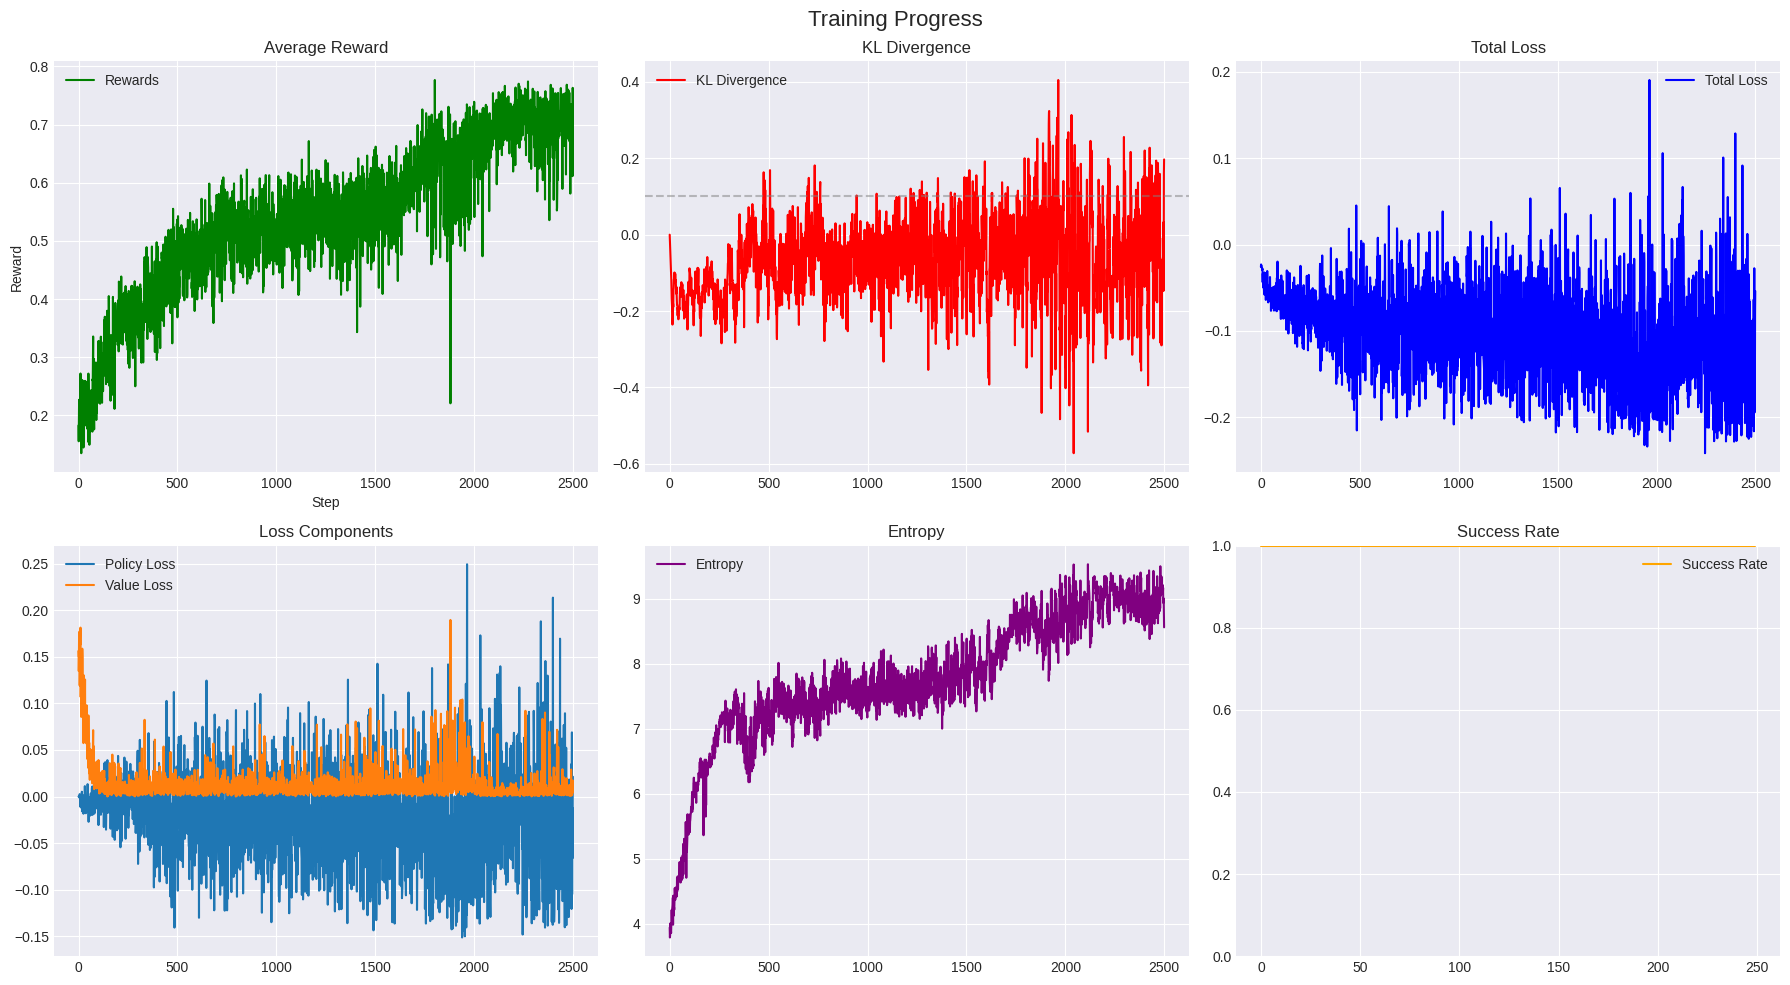

Checkpoint saved at genrec_rlhf_checkpoint_final.

Training completed successfully.

Do you want to run the interactive demo? (y/n): n
Finished all tasks. GPU memory cleared.


In [ ]:
#  MAIN EXECUTION
if __name__ == "__main__":
    import gc
    import os
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

    # Optional: Load or regenerate products
    load_more_products()

    # Begin training
    model, tokenizer, trainer = train_recommendation_rlhf()

    # Optional: interactive demo
    print("\n" + "=" * 60)
    choice = input("Do you want to run the interactive demo? (y/n): ").lower()
    if choice == 'y':
        reward_fn = PersuasiveRecommendationReward()
        run_interactive_demo(model, tokenizer, reward_fn)

    # Final cleanup
    torch.cuda.empty_cache()
    gc.collect()
    print("Finished all tasks. GPU memory cleared.")
